# **Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# **Deafult Settings**

Some general settings used on the notebook

In [2]:
# Set aspects of the visual theme for all matplotlib and seaborn plots.
sns.set()

# **Loading and Processing Datasets**

In [3]:
goalscorers = pd.read_csv('goalscorers.csv')
shootouts = pd.read_csv('shootouts.csv')
results = pd.read_csv('results.csv')

## **Goalscorers**

In [4]:
# Change type of date column to datetime
goalscorers['date'] = pd.to_datetime(goalscorers.date)
# Add column year
goalscorers['year'] = goalscorers.date.map(lambda x: x.year)
goalscorers.head(5)

date  home_team away_team       team            scorer  minute  \
0 1916-07-02      Chile   Uruguay    Uruguay   José Piendibene    44.0   
1 1916-07-02      Chile   Uruguay    Uruguay  Isabelino Gradín    55.0   
2 1916-07-02      Chile   Uruguay    Uruguay  Isabelino Gradín    70.0   
3 1916-07-02      Chile   Uruguay    Uruguay   José Piendibene    75.0   
4 1916-07-06  Argentina     Chile  Argentina     Alberto Ohaco     2.0   

   own_goal  penalty  year  
0     False    False  1916  
1     False    False  1916  
2     False    False  1916  
3     False    False  1916  
4     False    False  1916

## **Shootouts**

In [5]:
shootouts.head(5)

date    home_team         away_team       winner
0  1967-08-22        India            Taiwan       Taiwan
1  1971-11-14  South Korea  Vietnam Republic  South Korea
2  1972-05-07  South Korea              Iraq         Iraq
3  1972-05-17     Thailand       South Korea  South Korea
4  1972-05-19     Thailand          Cambodia     Thailand

## **Results**

In [6]:
# Create a goal_dif column
results['goal_dif'] = results['home_score'] - results['away_score']
# Create a total_goals column
results['total_goals'] = results['home_score'] + results['away_score']
# Change type of date column to datetime
results['date'] = pd.to_datetime(results.date)
# Add column year
results['year'] = results.date.map(lambda x: x.year)
results.head(10)

date home_team away_team  home_score  away_score tournament     city  \
0 1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1 1873-03-08   England  Scotland           4           2   Friendly   London   
2 1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
3 1875-03-06   England  Scotland           2           2   Friendly   London   
4 1876-03-04  Scotland   England           3           0   Friendly  Glasgow   
5 1876-03-25  Scotland     Wales           4           0   Friendly  Glasgow   
6 1877-03-03   England  Scotland           1           3   Friendly   London   
7 1877-03-05     Wales  Scotland           0           2   Friendly  Wrexham   
8 1878-03-02  Scotland   England           7           2   Friendly  Glasgow   
9 1878-03-23  Scotland     Wales           9           0   Friendly  Glasgow   

    country  neutral  goal_dif  total_goals  year  
0  Scotland    False         0            0  1872  
1   England    False         2            6  1873  
2  Scotland    False         1            3  1874  
3   England    False         0            4  1875  
4  Scotland    False         3            3  1876  
5  Scotland    False         4            4  1876  
6   England    False        -2            4  1877  
7     Wales    False        -2            2  1877  
8  Scotland    False         5            9  1878  
9  Scotland    False         9            9  1878

## **Bonus - Elo Ranking**

The World Football Elo Ratings are based on the Elo rating system. This system is used by FIDE, the international chess federation, to rate chess players.

We can apply the Elo rating system to international football, by adding a weighting for the kind of match, an adjustment for the home team advantage, and an adjustment for goal difference in the match result.

All teams must start with 1500 points.

The ratings are based on the following formulas:

Rn = Ro + G x K × (W - We)

- Rn is the new rating, Ro is the old (pre-match) rating.
- G is a goal difference index
    - If 0 or 1: 1
    - If 2: 3/2
    - If 3 or more: (11 + goal_dif) / 8
- K is the weight constant for the tournament played (We made an adjustmant from the reference):
    - 60 for World Cup Matches;
    - 50 for continental championships and major intercontinental tournaments;
    - 40 for World Cup qualifiers and major tournaments;
    - 30 for Continental qualifiers and major tournaments;
    - 20 for Friendly and other tournaments
- W is the result of the game (1 for a win, 0.5 for a draw, and 0 for a loss).
- We is the expected result (win expectancy), either from the chart or the following formula:
    - We = 1 / (10**(-dr/400) + 1)
    - dr equals the difference in ratings plus 100 points for a team playing at home.
    
Reference: https://www.eloratings.net/about

### **Functions implementation**

In [7]:
# Return expected result probabilty
def expected_result(ranking_a, ranking_b, home_advantage):
    return 1 / (10**(-((ranking_a+home_advantage)-ranking_b)/400) + 1)

# Return result by goal diference
def result(goal_dif):
    # return 0 to lost
    if goal_dif < 0:
        return 0
    # return 0.5 to draw
    elif goal_dif == 0:
        return 0.5
    # return 1 to win
    return 1


# The number of goals is taken into account by use of a goal difference index
def goal_index(goal_dif):
    goal_dif = abs(goal_dif)
    if goal_dif <= 1:
        return 1
    elif goal_dif == 2:
        return 3/2
    else:
        return (11 + goal_dif) / 8


# Return tournament weight constant
def tournament_weight(tournament):
    # 60 points
    world_cup = 'FIFA World Cup'
    # 50 points
    continental = ['AFC Asian Cup', 'Africa Cup of Nations',
                  'CONCACAF Gold Cup', 'Copa América', 'OFC Nations Cup',
                  'UEFA European Championship', 'CONCACAF Cup', 'AFC Solidarity Cup',
                  'AFC Challenge Cup', 'Confederations Cup', 'CONMEBOL–UEFA Cup of Champions']
    # 40 points
    international_qualifiers_and_majors = ['UEFA Nations League', 'FIFA World Cup qualification',  
                                           'CONCACAF Nations League', 'African Nations Championship']
    # 30 points
    continental_qualifiers = ['UEFA Euro qualification', 'African Cup of Nations qualification', 'AFC Asian Cup qualification',
                              'Copa América qualification']
    # 20 points + others
    friendly = 'Friendly'
    
    if tournament == world_cup:
        return 60
    elif tournament in continental:
        return 50
    elif tournament in international_qualifiers_and_majors:
        return 40
    elif tournament in continental_qualifiers:
        return 30
    elif tournament == friendly:
        return 20
    else:
        return 20


# Calculate change of points
def points_change(ranking_a, ranking_b, goal_dif, tournament, home_advantage=100):
    g = goal_index(goal_dif)
    k = tournament_weight(tournament)
    w = result(goal_dif)
    we = expected_result(ranking_a, ranking_b, home_advantage)
    return g * k * (w - we)


# Return a tuple with the ranking of A and the ranking of B
def elo(ranking_a, ranking_b, goal_dif, tournament, neutral):
    
    if neutral:
        points = points_change(ranking_a, ranking_b, goal_dif, tournament, home_advantage=0)
    else:
        points = points_change(ranking_a, ranking_b, goal_dif, tournament, home_advantage=100)
    
    return ranking_a + points, ranking_b - points

### **Data Processing**

In [8]:
# Create a goal_dif column
results['goal_dif'] = results['home_score'] - results['away_score']
# Create a total_goals column
results['total_goals'] = results['home_score'] + results['away_score']
# Change type of date column to datetime
results['date'] = pd.to_datetime(results.date)
# Add column year
results['year'] = results.date.map(lambda x: x.year)


# Assigning default rating of 1500 to each team
unique_team_list = np.unique(pd.concat([results.home_team, results.away_team], ignore_index=True))
rating_dict = {team:1500 for team in unique_team_list}
# Assign each year of dataset
year_list = results.year.unique()
year_dict = dict()

# Itarate years to calculate elo ranking
for year in year_list:
    # Select mask with year of the iteration
    mask = results['year'] == year
    results_temp = results[mask][['home_team', 'away_team', 'goal_dif', 'tournament', 'neutral']]
    
    # Iterate dataframe to calculate elo ranking changes
    for index, row in results_temp.iterrows():
        
        # Get home and away teams names
        home_team = row.home_team
        away_team = row.away_team
        
        # Get other informations
        goal_dif = row.goal_dif
        tournament = row.tournament
        neutral = row.neutral
        
        # Get home and away teams scores
        home_team_score = rating_dict[home_team]
        away_team_score = rating_dict[away_team]
        
        # Calculate new scores according to result of the match
        home_team_score, away_team_score = elo(home_team_score, away_team_score, goal_dif, tournament, neutral)
        
        # Assign new scores
        rating_dict[home_team] = home_team_score
        rating_dict[away_team] = away_team_score

    # Transform rating_dict into DataFrame
    year_dict[year] = rating_dict.copy()

country_ranking = pd.DataFrame.from_dict(year_dict)
country_ranking = country_ranking.reset_index().rename(columns={'index': 'country'})
country_ranking.head()

country    1872    1873    1874    1875    1876    1877    1878  \
0     Abkhazia  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0   
1  Afghanistan  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0   
2      Albania  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0   
3     Alderney  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0   
4      Algeria  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0  1500.0   

     1879    1880  ...         2014         2015         2016         2017  \
0  1500.0  1500.0  ...  1495.933727  1495.933727  1541.988144  1536.597870   
1  1500.0  1500.0  ...  1285.742074  1309.722983  1313.441091  1321.562707   
2  1500.0  1500.0  ...  1607.064865  1630.177782  1596.914714  1624.582143   
3  1500.0  1500.0  ...  1399.481222  1355.675185  1355.675185  1343.731168   
4  1500.0  1500.0  ...  1740.572990  1738.971650  1710.647093  1652.414608   

          2018         2019         2020         2021         2022  \
0  1573.682634  1590.633376  1590.633376  1590.633376  1590.633376   
1  1314.735193  1310.864965  1310.864965  1315.257412  1279.155143   
2  1536.531153  1551.969675  1576.881358  1607.633618  1569.770664   
3  1343.731168  1336.859702  1336.859702  1336.859702  1336.859702   
4  1614.162237  1741.221947  1756.721522  1818.896327  1796.483943   

          2023  
0  1590.633376  
1  1279.155143  
2  1566.368467  
3  1336.859702  
4  1800.388304  

[5 rows x 153 columns]

### **Adding features**

In [9]:
# Add country confederation
country_confederation = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/fifa/fifa_countries_audience.csv')
country_confederation_country = np.array(country_confederation.country)
country_confederation_confed = np.array(country_confederation.confederation)
country_confederation_dict = dict(zip(country_confederation_country, country_confederation_confed))
country_confederation_dict['England'] = 'UEFA'
country_confederation_dict['Scotland'] = 'UEFA'
country_ranking['confederation'] = country_ranking['country'].apply(lambda x : country_confederation_dict.get(x))
country_ranking.confederation.fillna('Not Found', inplace=True)

# Add country shortcode
country_shortcode = pd.read_csv('https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv')
country_code_name = np.array(country_shortcode.name)
country_code_alpha = np.array(country_shortcode['alpha-2'])
country_code_dict = dict(zip(country_code_name, country_code_alpha))
country_ranking['code'] = country_ranking['country'].apply(lambda x : country_code_dict.get(x))
country_ranking.code = ':' + country_ranking.code.str.lower() + ':'
country_ranking[['country', 2023, 'confederation', 'code']].head()

country         2023 confederation  code
0     Abkhazia  1590.633376     Not Found   NaN
1  Afghanistan  1279.155143           AFC  :af:
2      Albania  1566.368467          UEFA  :al:
3     Alderney  1336.859702     Not Found   NaN
4      Algeria  1800.388304           CAF  :dz:

# **Scatter plot**

## Separating history into time intervals marked by major events from 1916 to the present day (from the *goalscorers* table)

In [10]:
goalscorers
goalscorers = goalscorers.dropna()

### 1916-1919:

Easter Rising in Ireland

Entry of the United States into World War I

Russian revolution

End of World War I

Treaty of Versailles

Text(0.5, 1.0, 'Analysis of the minute when the goal was scored')

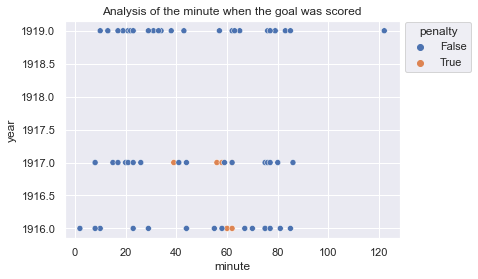

In [11]:
filtro1 = (goalscorers['year'] >= 1916) & (goalscorers['year'] < 1920)
df_filtrado1 = goalscorers.loc[filtro1]
ax = sns.scatterplot(data = df_filtrado1, x='minute', y='year', hue='penalty')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1.02))
ax.set_title('Analysis of the minute when the goal was scored')

### 1920-1945:

New York stock market crash and onset of the Great Depression

Adolf Hitler is appointed Chancellor of Germany

Beginning of World War II

Japanese attack on Pearl Harbor

End of World War II and creation of the United Nations (UN)

Text(0.5, 1.0, 'Analysis of the minute when the goal was scored')

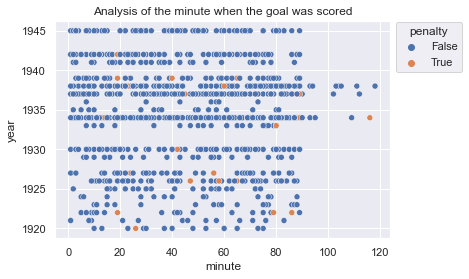

In [12]:
filtro2 = (goalscorers['year'] >= 1920) & (goalscorers['year'] < 1946)
df_filtrado2 = goalscorers.loc[filtro2]
bx = sns.scatterplot(data = df_filtrado2, x='minute', y='year', hue='penalty')
sns.move_legend(bx, "upper left", bbox_to_anchor=(1,1.02))
bx.set_title('Analysis of the minute when the goal was scored')

### 1946-1955:

marshall plan

Creation of the People's Republic of China

Beginning of the Korean War

End of the Korean War

bandung conference

Text(0.5, 1.0, 'Analysis of the minute when the goal was scored')

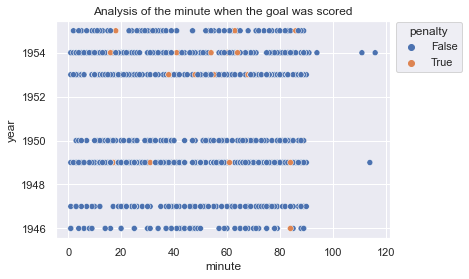

In [13]:
filtro3 = (goalscorers['year'] >= 1946) & (goalscorers['year'] < 1956)
df_filtrado3 = goalscorers.loc[filtro3]
cx = sns.scatterplot(data = df_filtrado3, x='minute', y='year', hue='penalty')
sns.move_legend(cx, "upper left", bbox_to_anchor=(1,1.02))
cx.set_title('Analysis of the minute when the goal was scored')

### 1956-1964:

Construction of the Berlin Wall begins

Cuban Missile Crisis

Assassination of John F. Kennedy

Military coup in Brazil

Text(0.5, 1.0, 'Analysis of the minute when the goal was scored')

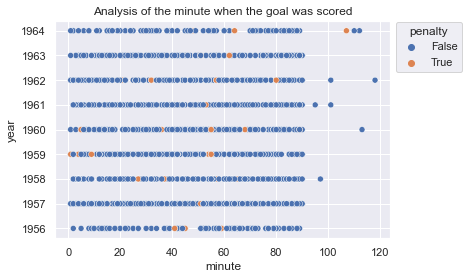

In [14]:
filtro4 = (goalscorers['year'] >= 1956) & (goalscorers['year'] < 1965)
df_filtrado4 = goalscorers.loc[filtro4]
dx= sns.scatterplot(data = df_filtrado4, x='minute', y='year', hue='penalty')
sns.move_legend(dx, "upper left", bbox_to_anchor=(1,1.02))
dx.set_title('Analysis of the minute when the goal was scored')

### 1965-1975:

Vietnam War

Civil rights movements in the United States

Cultural Revolution in China

Text(0.5, 1.0, 'Analysis of the minute when the goal was scored')

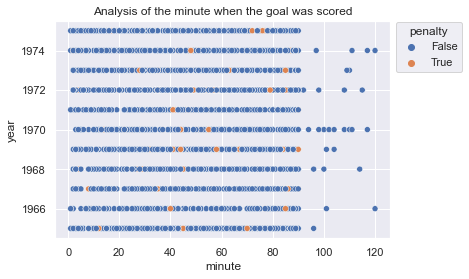

In [15]:
filtro5 = (goalscorers['year'] >= 1965) & (goalscorers['year'] < 1976)
df_filtrado5 = goalscorers.loc[filtro5]
ex= sns.scatterplot(data = df_filtrado5, x='minute', y='year', hue='penalty')
sns.move_legend(ex, "upper left", bbox_to_anchor=(1,1.02))
ex.set_title('Analysis of the minute when the goal was scored')

### 1976-1991:

Islamic Revolution in Iran

Cold War peaks

Fall of the Berlin Wall

Dissolution of the Soviet Union

Text(0.5, 1.0, 'Analysis of the minute when the goal was scored')

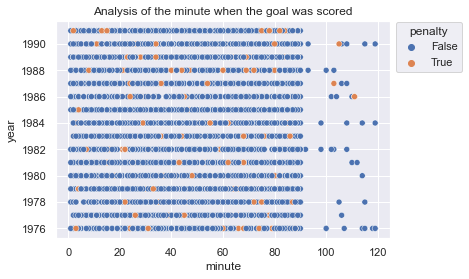

In [16]:
filtro6 = (goalscorers['year'] >= 1976) & (goalscorers['year'] < 1992)
df_filtrado6 = goalscorers.loc[filtro6]
fx= sns.scatterplot(data = df_filtrado6, x='minute', y='year', hue='penalty')
sns.move_legend(fx, "upper left", bbox_to_anchor=(1,1.02))
fx.set_title('Analysis of the minute when the goal was scored')

### 1992-2003:

Genocide in Rwanda

Oslo Accords for the Middle East

Terrorist attacks in New York and Washington D.C. on September 11, 2001

War in iraq

Text(0.5, 1.0, 'Analysis of the minute when the goal was scored')

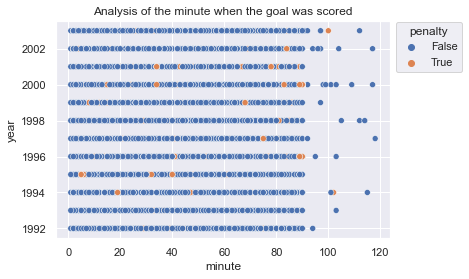

In [17]:
filtro7 = (goalscorers['year'] >= 1992) & (goalscorers['year'] <= 2003)
df_filtrado7 = goalscorers.loc[filtro7]
gx= sns.scatterplot(data = df_filtrado7, x='minute', y='year', hue='penalty')
sns.move_legend(gx, "upper left", bbox_to_anchor=(1,1.02))
gx.set_title('Analysis of the minute when the goal was scored')

### 2004-2012:


2008 United States Presidential Elections

Arab Spring

Text(0.5, 1.0, 'Analysis of the minute when the goal was scored')

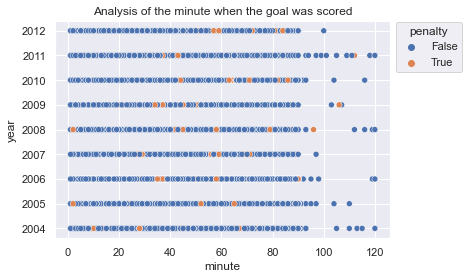

In [18]:
filtro8 = (goalscorers['year'] >= 2004) & (goalscorers['year'] <= 2012)
df_filtrado8 = goalscorers.loc[filtro8]
hx= sns.scatterplot(data = df_filtrado8, x='minute', y='year', hue='penalty')
sns.move_legend(hx, "upper left", bbox_to_anchor=(1,1.02))
hx.set_title('Analysis of the minute when the goal was scored')

## Scatter plot between variables *home_score* and *away_score* in relation to *total_goals*(Table *results*)

Text(0.5, 1.0, 'Total goals analysis')

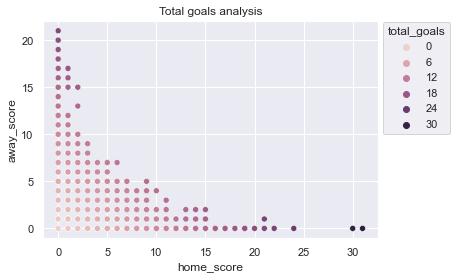

In [19]:
ax_r = sns.scatterplot(data = results, x='home_score', y='away_score', hue='total_goals')
sns.move_legend(ax_r, "upper left", bbox_to_anchor=(1,1.02))
ax_r.set_title('Total goals analysis')

# **Histogram**

## **Goalscorers**

In [20]:
goalscorers['date'] = pd.to_datetime(goalscorers['date'])
goalscorers['date'] = goalscorers['date'].dt.strftime('%Y')
goalscorers

date  home_team away_team       team            scorer  minute  \
0      1916      Chile   Uruguay    Uruguay   José Piendibene    44.0   
1      1916      Chile   Uruguay    Uruguay  Isabelino Gradín    55.0   
2      1916      Chile   Uruguay    Uruguay  Isabelino Gradín    70.0   
3      1916      Chile   Uruguay    Uruguay   José Piendibene    75.0   
4      1916  Argentina     Chile  Argentina     Alberto Ohaco     2.0   
...     ...        ...       ...        ...               ...     ...   
41003  2022  Argentina    France  Argentina    Ángel Di María    36.0   
41004  2022  Argentina    France     France     Kylian Mbappé    80.0   
41005  2022  Argentina    France     France     Kylian Mbappé    81.0   
41006  2022  Argentina    France  Argentina      Lionel Messi   109.0   
41007  2022  Argentina    France     France     Kylian Mbappé   118.0   

       own_goal  penalty  year  
0         False    False  1916  
1         False    False  1916  
2         False    False  1916  
3         False    False  1916  
4         False    False  1916  
...         ...      ...   ...  
41003     False    False  2022  
41004     False     True  2022  
41005     False    False  2022  
41006     False    False  2022  
41007     False     True  2022  

[40750 rows x 9 columns]

### **Analysis of Frequencies by Years comprising World Events**

#### **Until 1918**

Below we can see the most frequent home teams until 1918 (end of World War I)

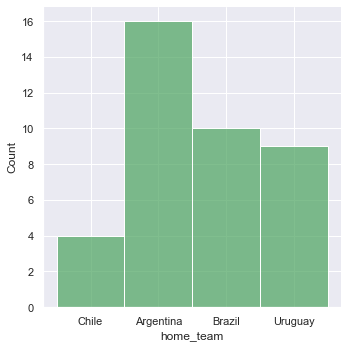

In [21]:
home_team = goalscorers[goalscorers['date'] <= '1918']
sns.displot(data=home_team, x='home_team', color='g')

Below we can see the most frequent away teams until 1918 (end of World War I)

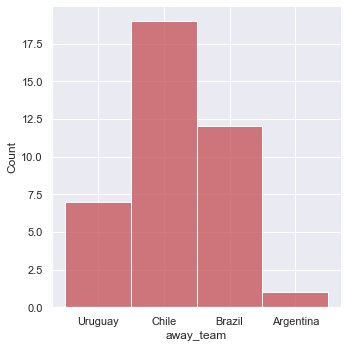

In [22]:
away_team = goalscorers[goalscorers['date'] <= '1918']
sns.displot(data=away_team, x='away_team', color='r')

Below we can see the teams that scored the most goals until 1918 (end of World War I)

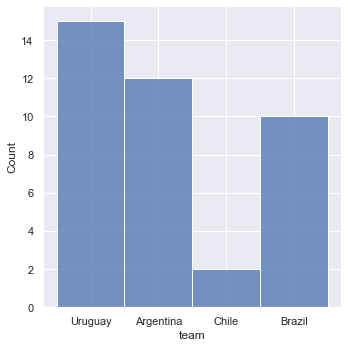

In [23]:
goal_dist = goalscorers[goalscorers['date'] <= '1918']
sns.displot(data=goal_dist, x='team', color='b')

#### **From 1918 to 1939**

Below we can see the most frequent home teams from 1918 to 1939, where this period is known as the "interwar period".

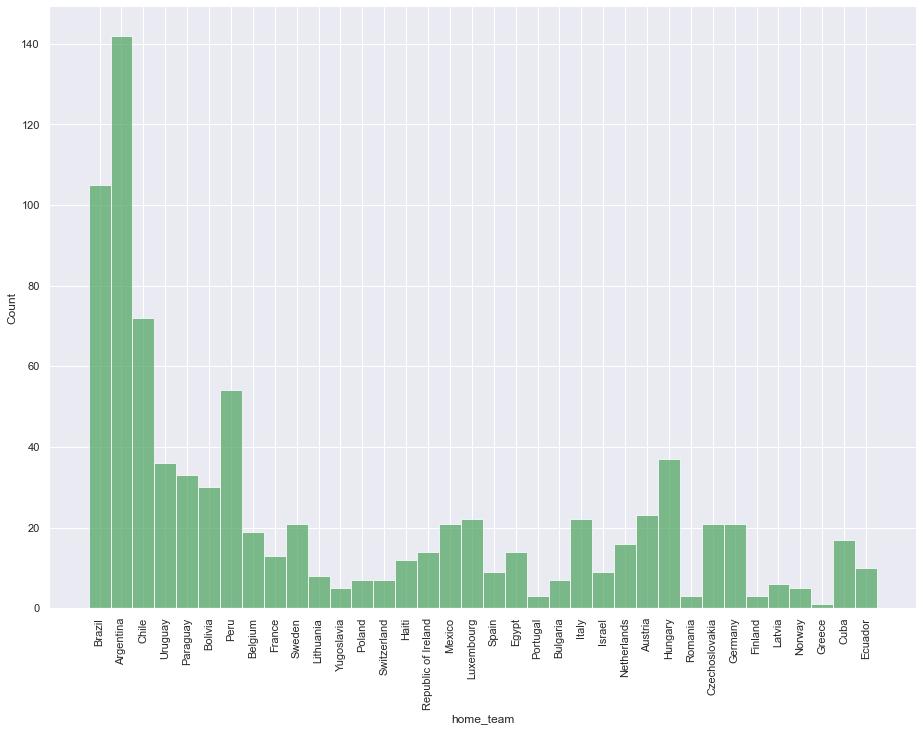

In [24]:
home_team = goalscorers[goalscorers['date'] <= '1939']
home_team = home_team[home_team['date'] > '1918']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(15,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 1918 to 1939, where this period is known as the "interwar period".

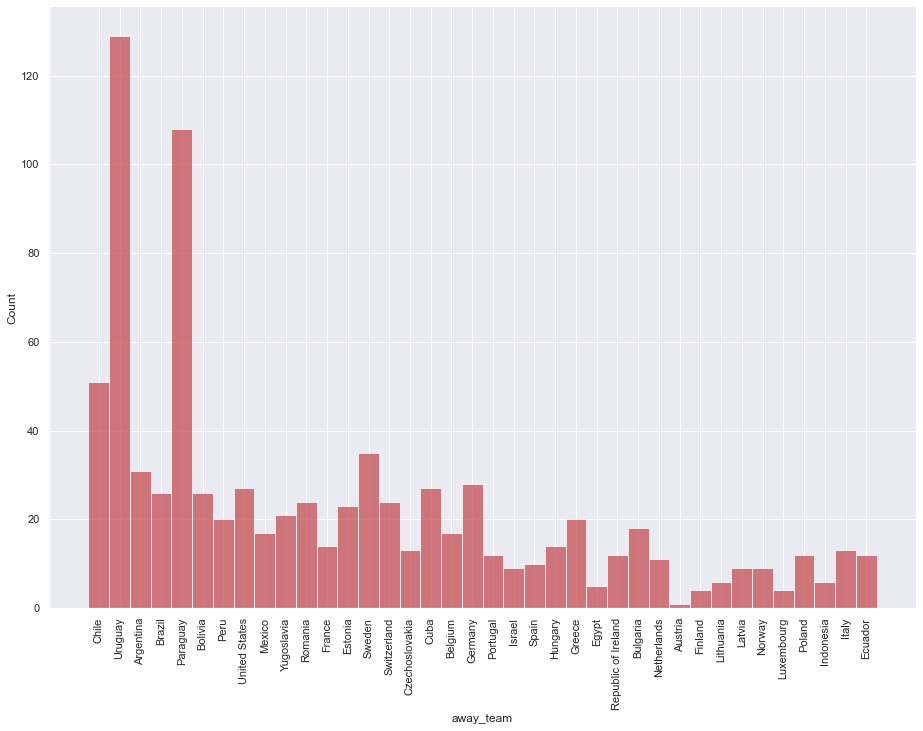

In [25]:
away_team = goalscorers[goalscorers['date'] <= '1939']
away_team = away_team[away_team['date'] > '1918']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(15,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 1918 to 1939, a period known as the "period between wars".

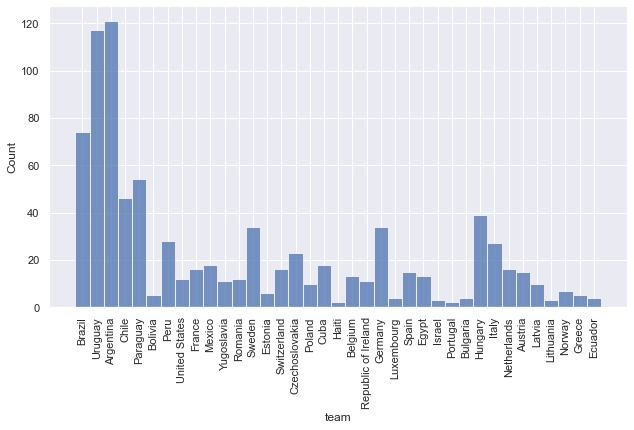

In [26]:
goal_dist = goalscorers[goalscorers['date'] <= '1939']
goal_dist = goal_dist[goal_dist['date'] > '1918']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(10,5)
hist.set_xticklabels(rotation=90)

#### **From 1939 to 1945**

Below we can see the most frequent home teams between 1939 to 1945 (World War II).

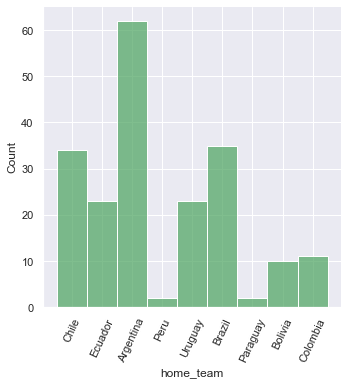

In [27]:
home_team = goalscorers[goalscorers['date'] <= '1945']
home_team = home_team[home_team['date'] > '1939']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.set_xticklabels(rotation=65)

Below we can see the most frequent away teams between 1939 to 1945 (World War II).

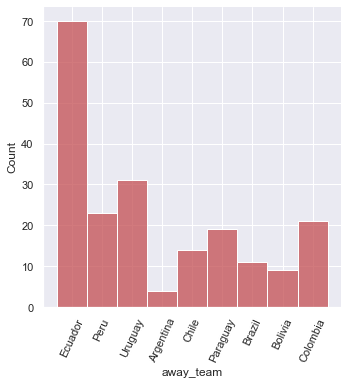

In [28]:
away_team = goalscorers[goalscorers['date'] <= '1945']
away_team = away_team[away_team['date'] > '1939']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.set_xticklabels(rotation=65)

Below we can see the teams that scored the most goals between 1939 and 1945 (World War II).

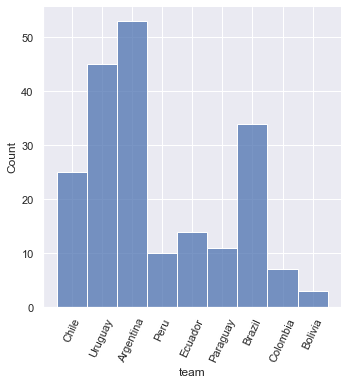

In [29]:
goal_dist = goalscorers[goalscorers['date'] <= '1945']
goal_dist = goal_dist[goal_dist['date'] > '1939']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.set_xticklabels(rotation=65)

#### **Post-war Period 1945 to 1947**

Below we can see the most frequent home teams between the post-war period from 1945 to 1947.

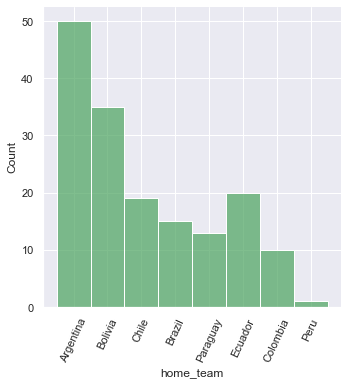

In [30]:
home_team = goalscorers[goalscorers['date'] <= '1947']
home_team = home_team[home_team['date'] > '1945']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.set_xticklabels(rotation=65)

Below we can see the most frequent away teams between the post-war period from 1945 to 1947.

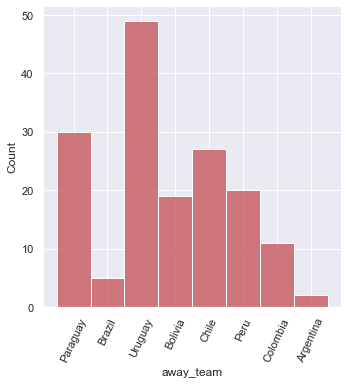

In [31]:
away_team = goalscorers[goalscorers['date'] <= '1947']
away_team = away_team[away_team['date'] > '1945']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.set_xticklabels(rotation=65)

Below we can see the teams that scored the most goals between the post-war period from 1945 to 1947.

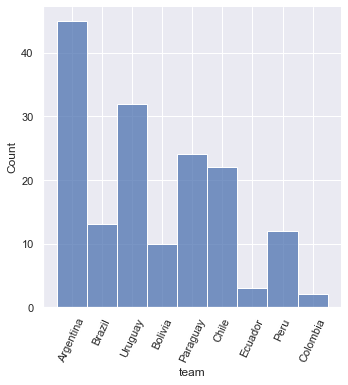

In [32]:
goal_dist = goalscorers[goalscorers['date'] <= '1947']
goal_dist = goal_dist[goal_dist['date'] > '1945']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.set_xticklabels(rotation=65)

#### **From 1947 to 1991**

Below we can see the most frequent home teams from 1947 to 1991, where this period is known as the "Cold War".

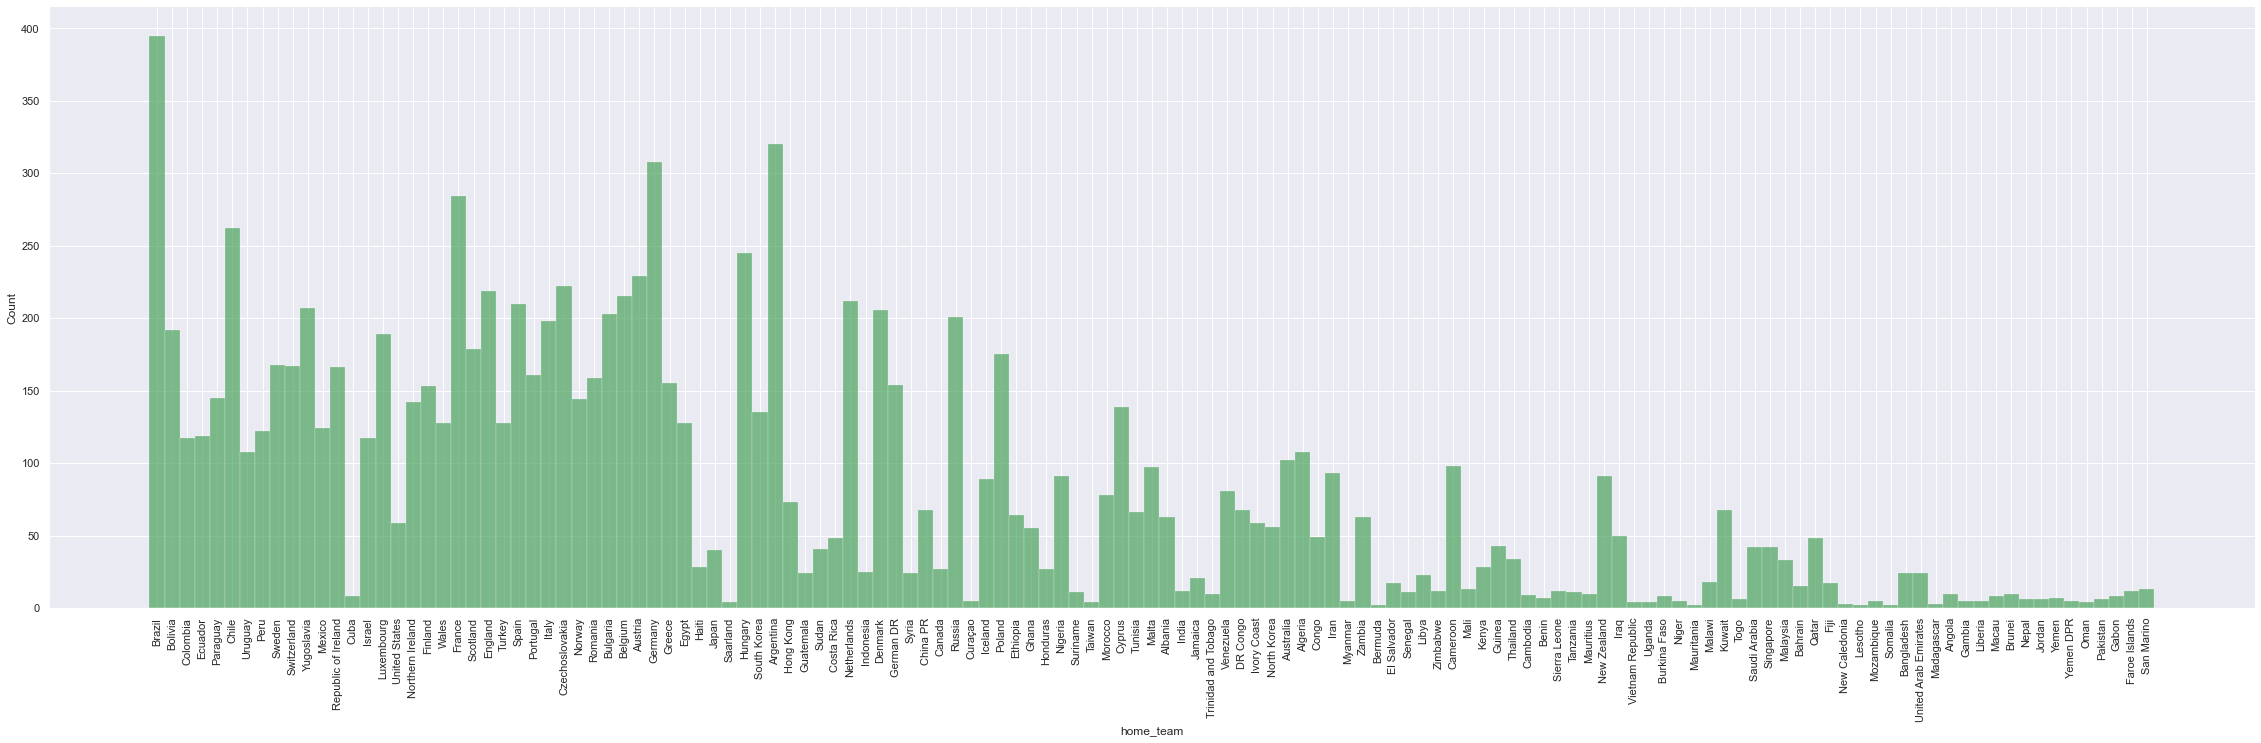

In [33]:
home_team = goalscorers[goalscorers['date'] <= '1991']
home_team = home_team[home_team['date'] > '1947']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 1947 to 1991, where this period is known as the "Cold War".

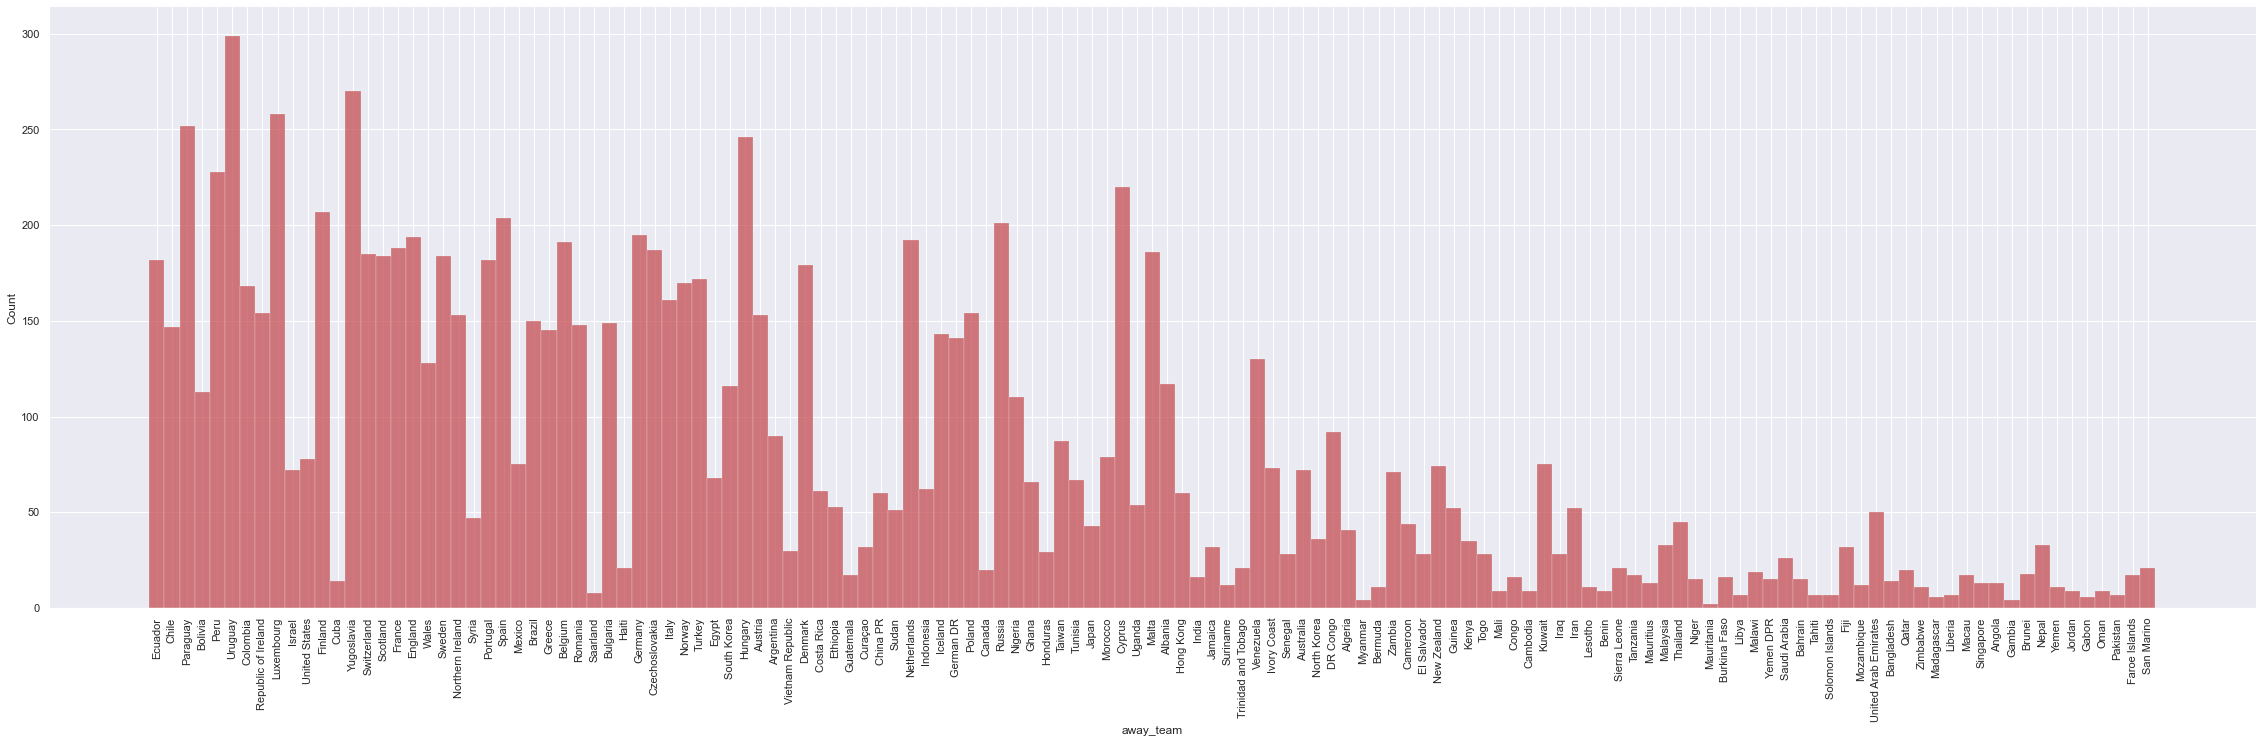

In [34]:
away_team = goalscorers[goalscorers['date'] <= '1991']
away_team = away_team[away_team['date'] > '1947']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 1947 to 1991, where this period is known as the "Cold War".

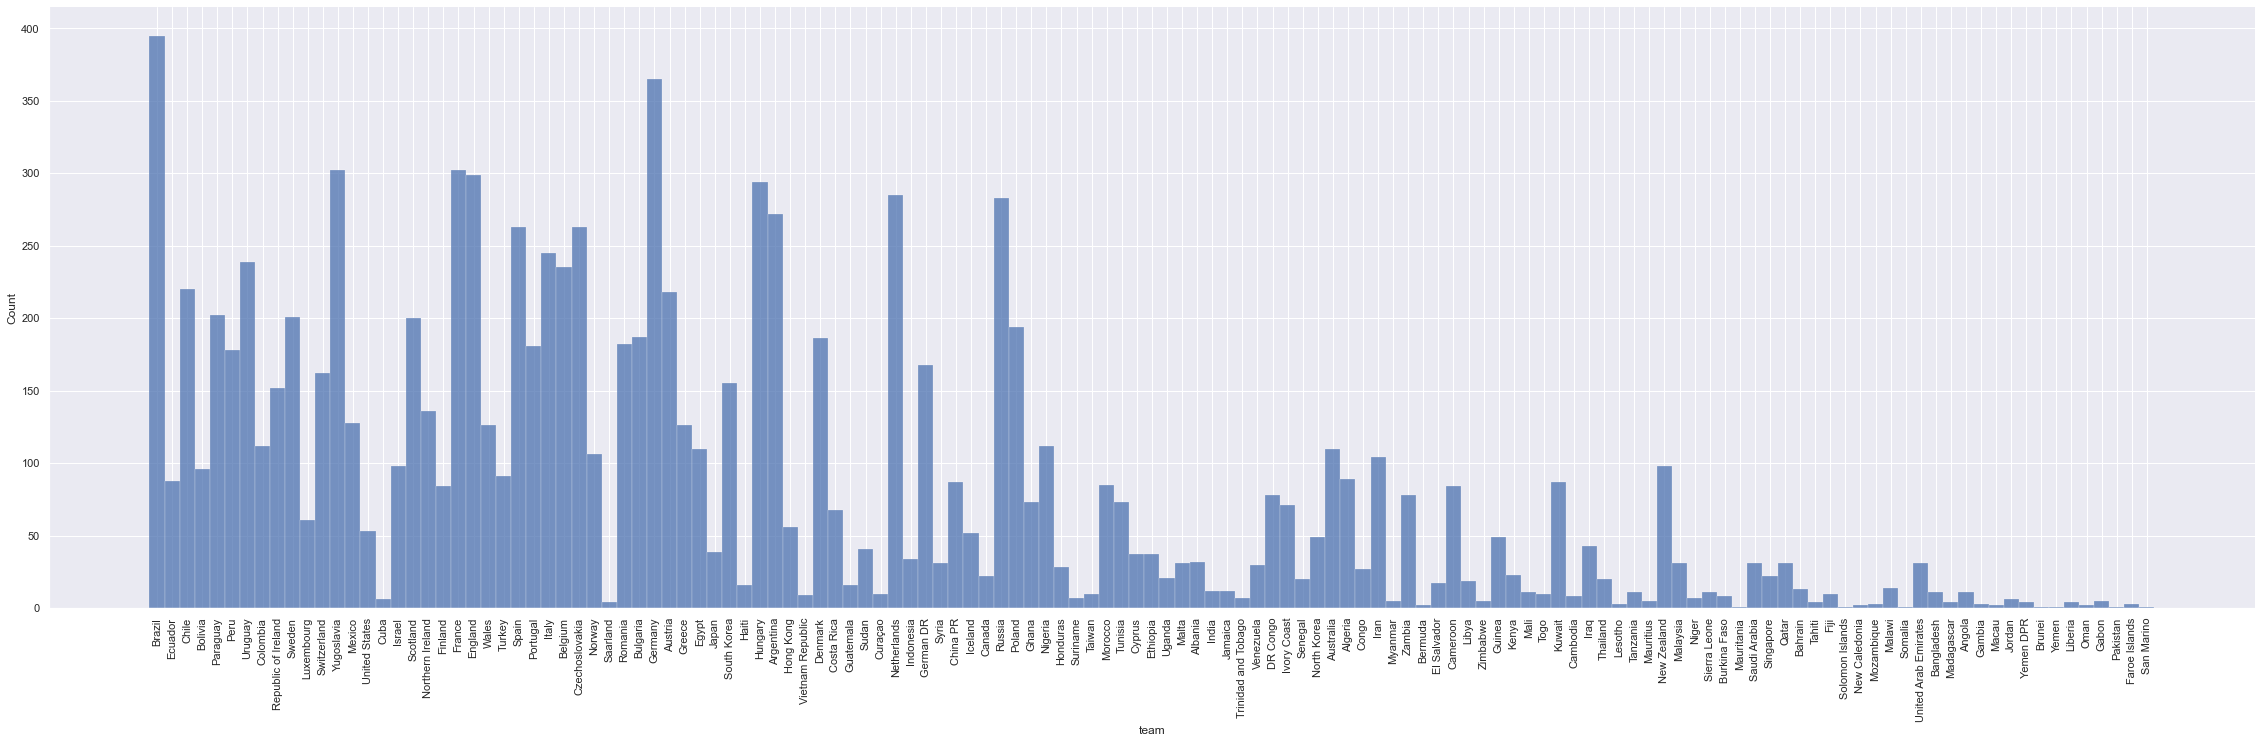

In [35]:
goal_dist = goalscorers[goalscorers['date'] <= '1991']
goal_dist = goal_dist[goal_dist['date'] > '1947']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 1992 to 1993**

Below we can see the most frequent home teams from 1992 to 1993; period in which the Maastricht Treaty was signed with the institution of the European Union.

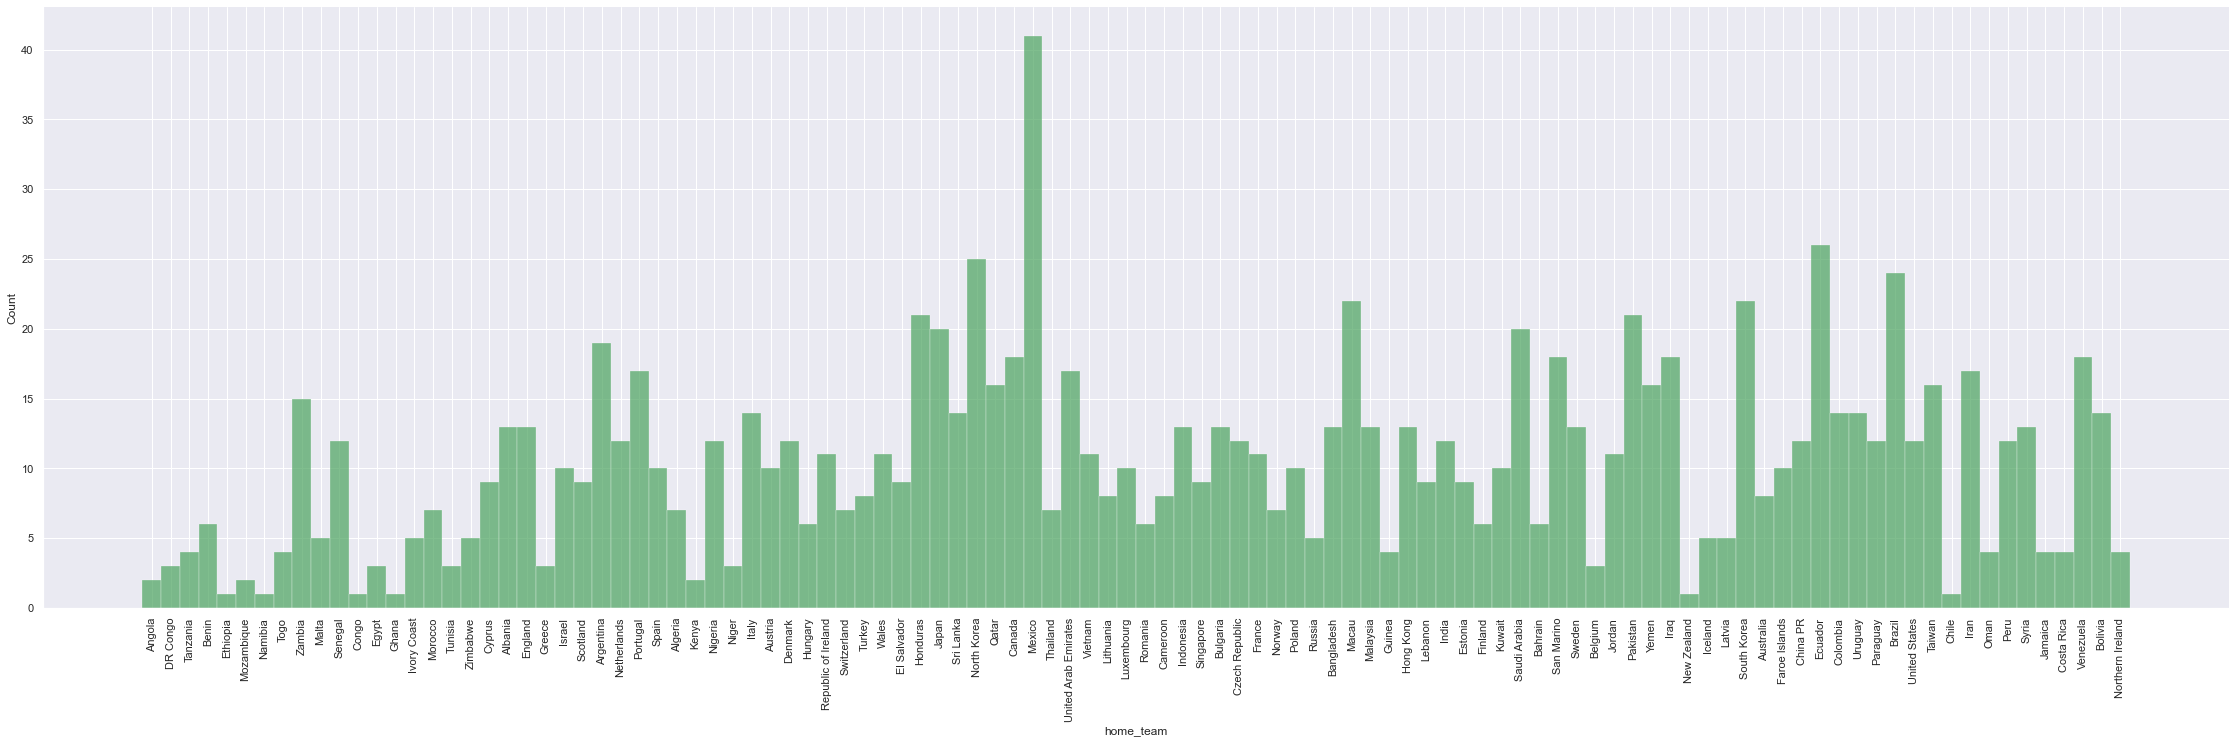

In [36]:
home_team = goalscorers[goalscorers['date'] <= '1993']
home_team = home_team[home_team['date'] > '1992']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 1992 to 1993; period in which the Maastricht Treaty was signed with the institution of the European Union.

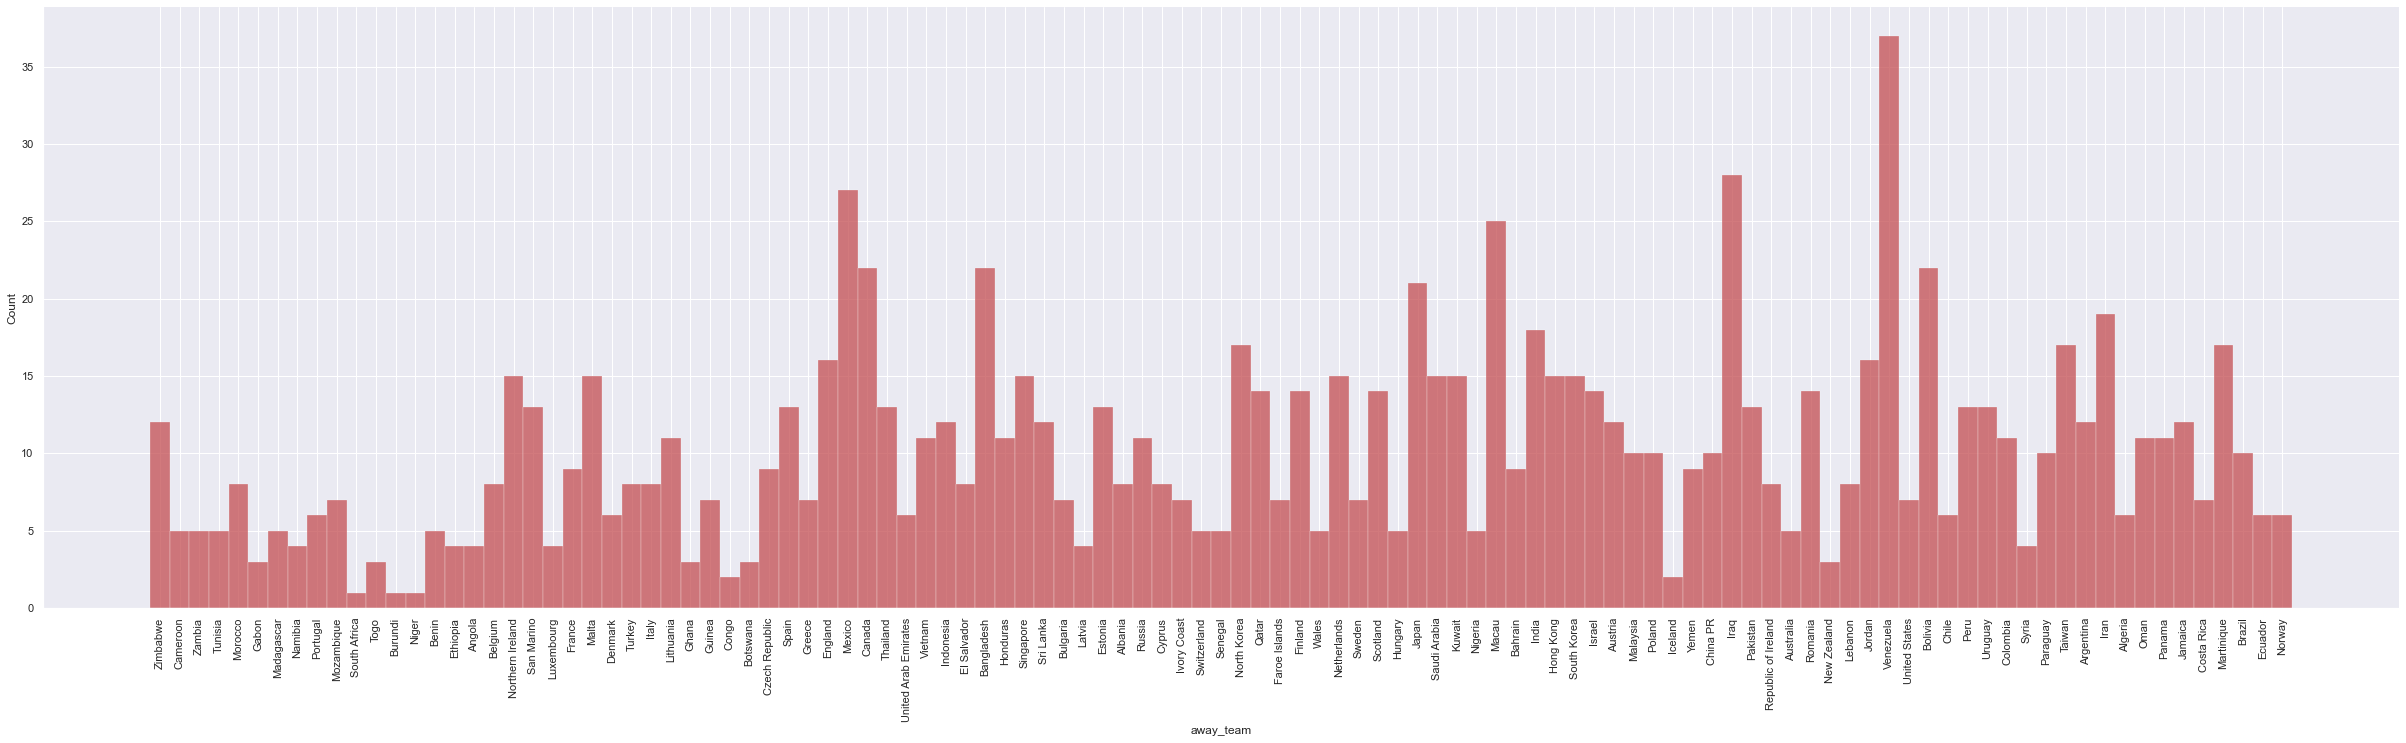

In [37]:
away_team = goalscorers[goalscorers['date'] <= '1993']
away_team = away_team[away_team['date'] > '1992']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 1992 to 1993; period in which the Maastricht Treaty was signed with the institution of the European Union.

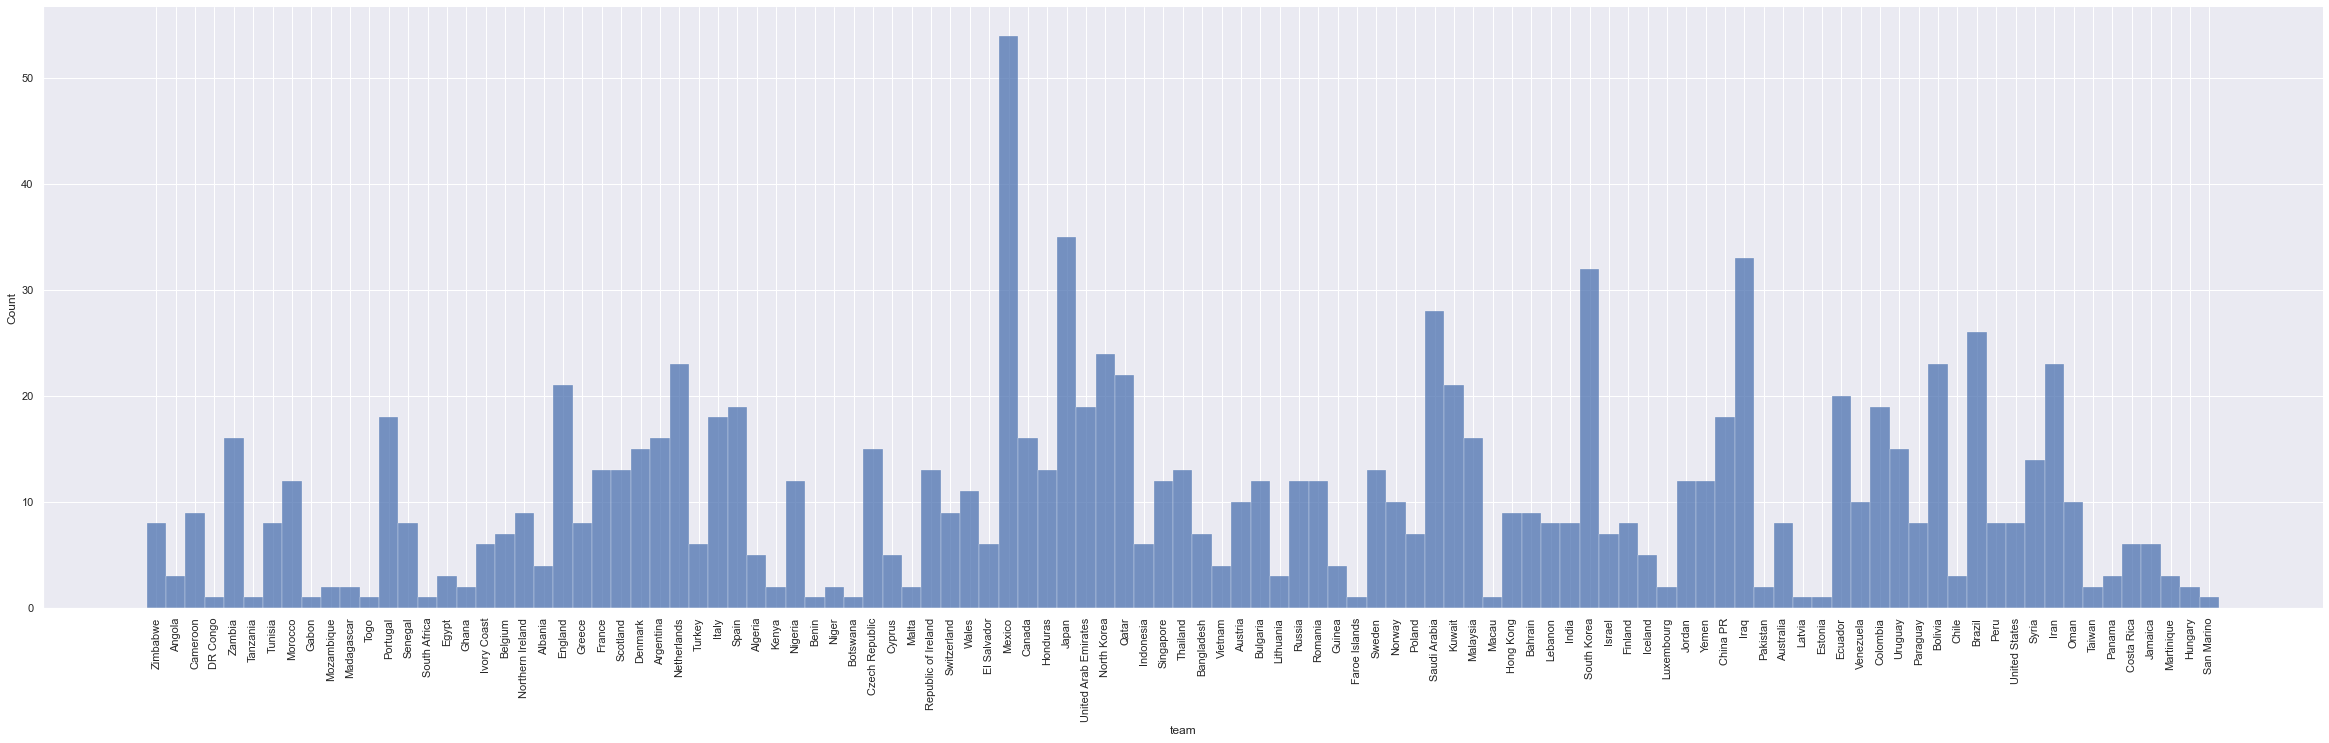

In [38]:
goal_dist = goalscorers[goalscorers['date'] <= '1993']
goal_dist = goal_dist[goal_dist['date'] > '1992']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 1994 to 1999**

Below we can see the most frequent home teams from 1994 to 1999; a period that comprises major impactful world events, such as the Genocide in Rwanda, the Attack in Oklahoma City, the Asian financial crisis, and the Kosovo War.

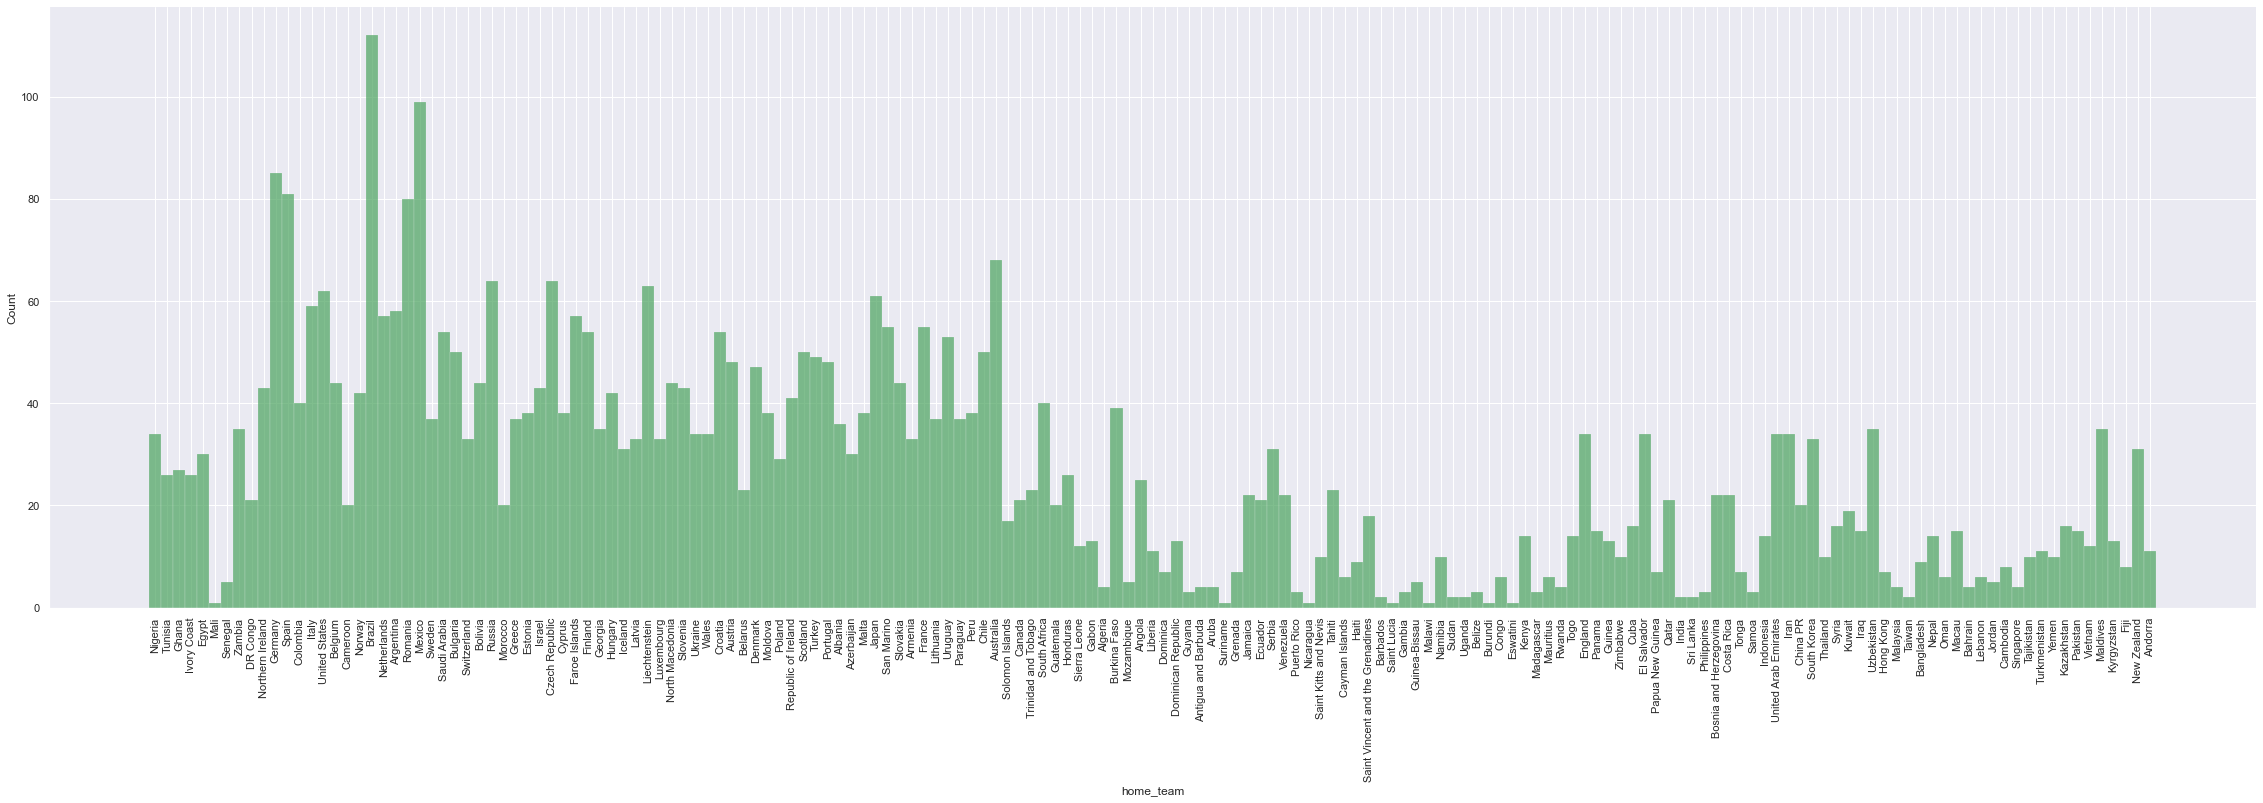

In [39]:
home_team = goalscorers[goalscorers['date'] <= '1999']
home_team = home_team[home_team['date'] >= '1994']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 1994 to 1999; a period that comprises major impactful world events, such as the Genocide in Rwanda, the Attack in Oklahoma City, the Asian financial crisis, and the Kosovo War.

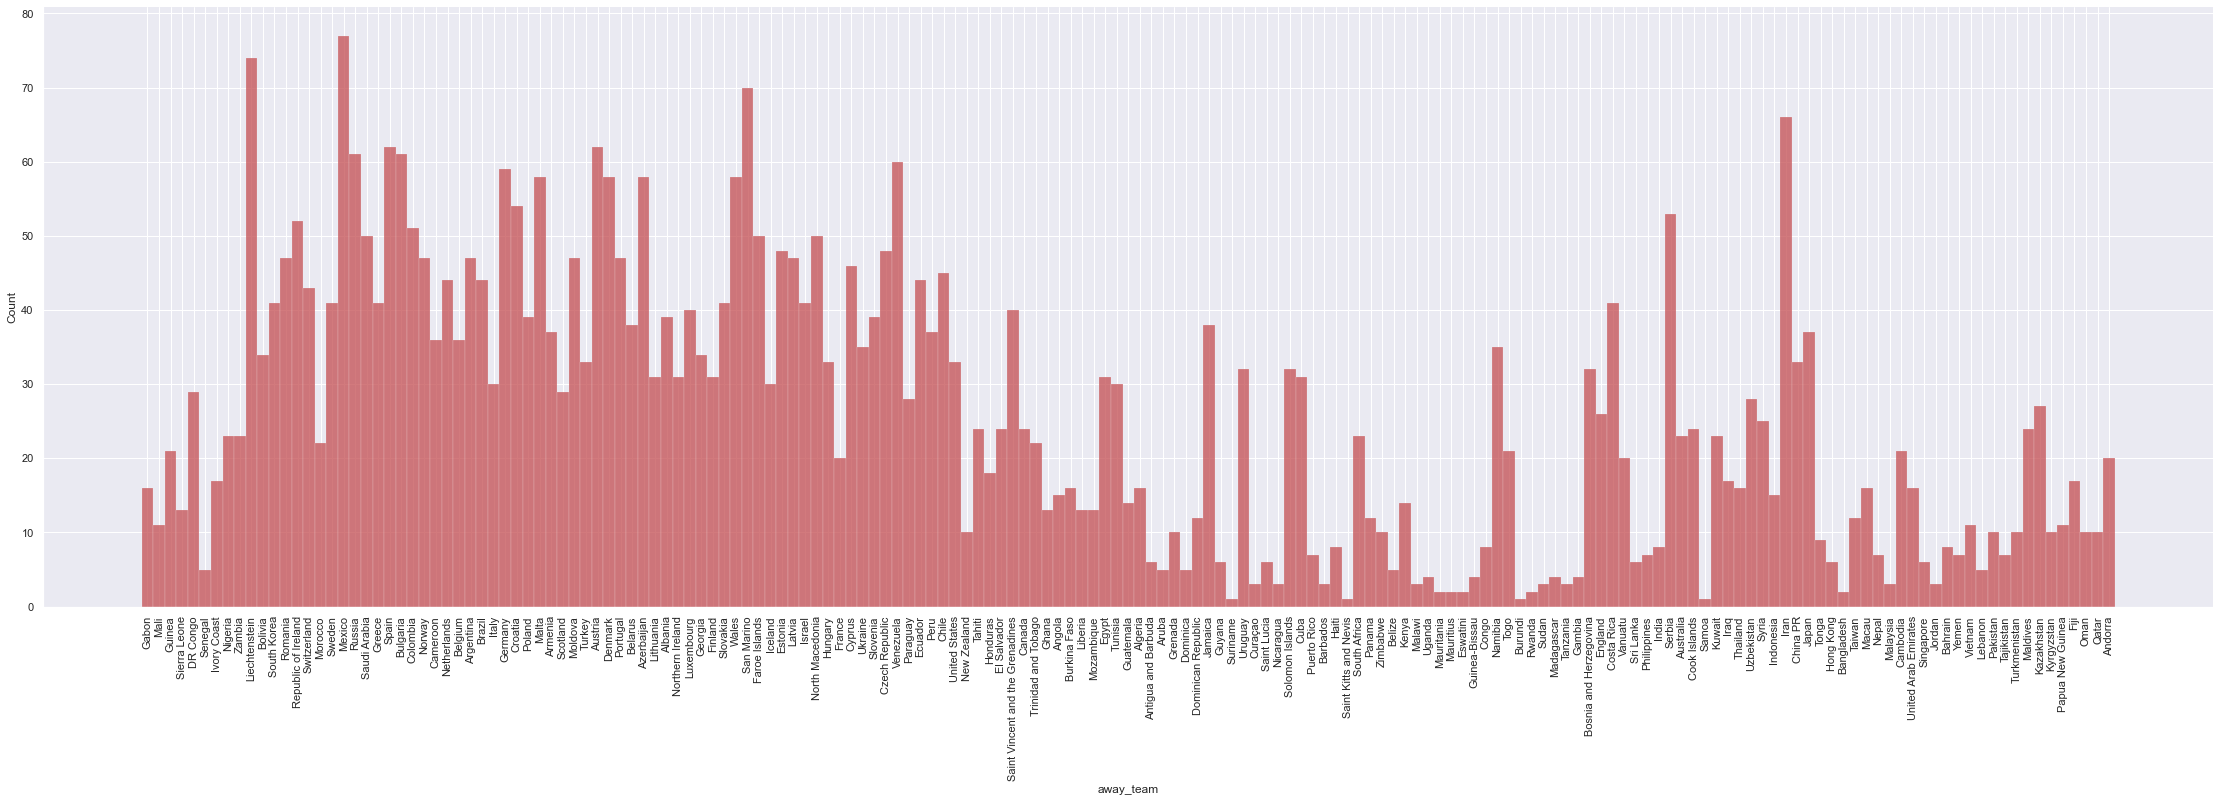

In [40]:
away_team = goalscorers[goalscorers['date'] <= '1999']
away_team = away_team[away_team['date'] >= '1994']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 1994 to 1999; a period that includes major world events of impact, such as the Genocide in Rwanda, the Attack on Oklahoma City, the Asian financial crisis and the Kosovo War.

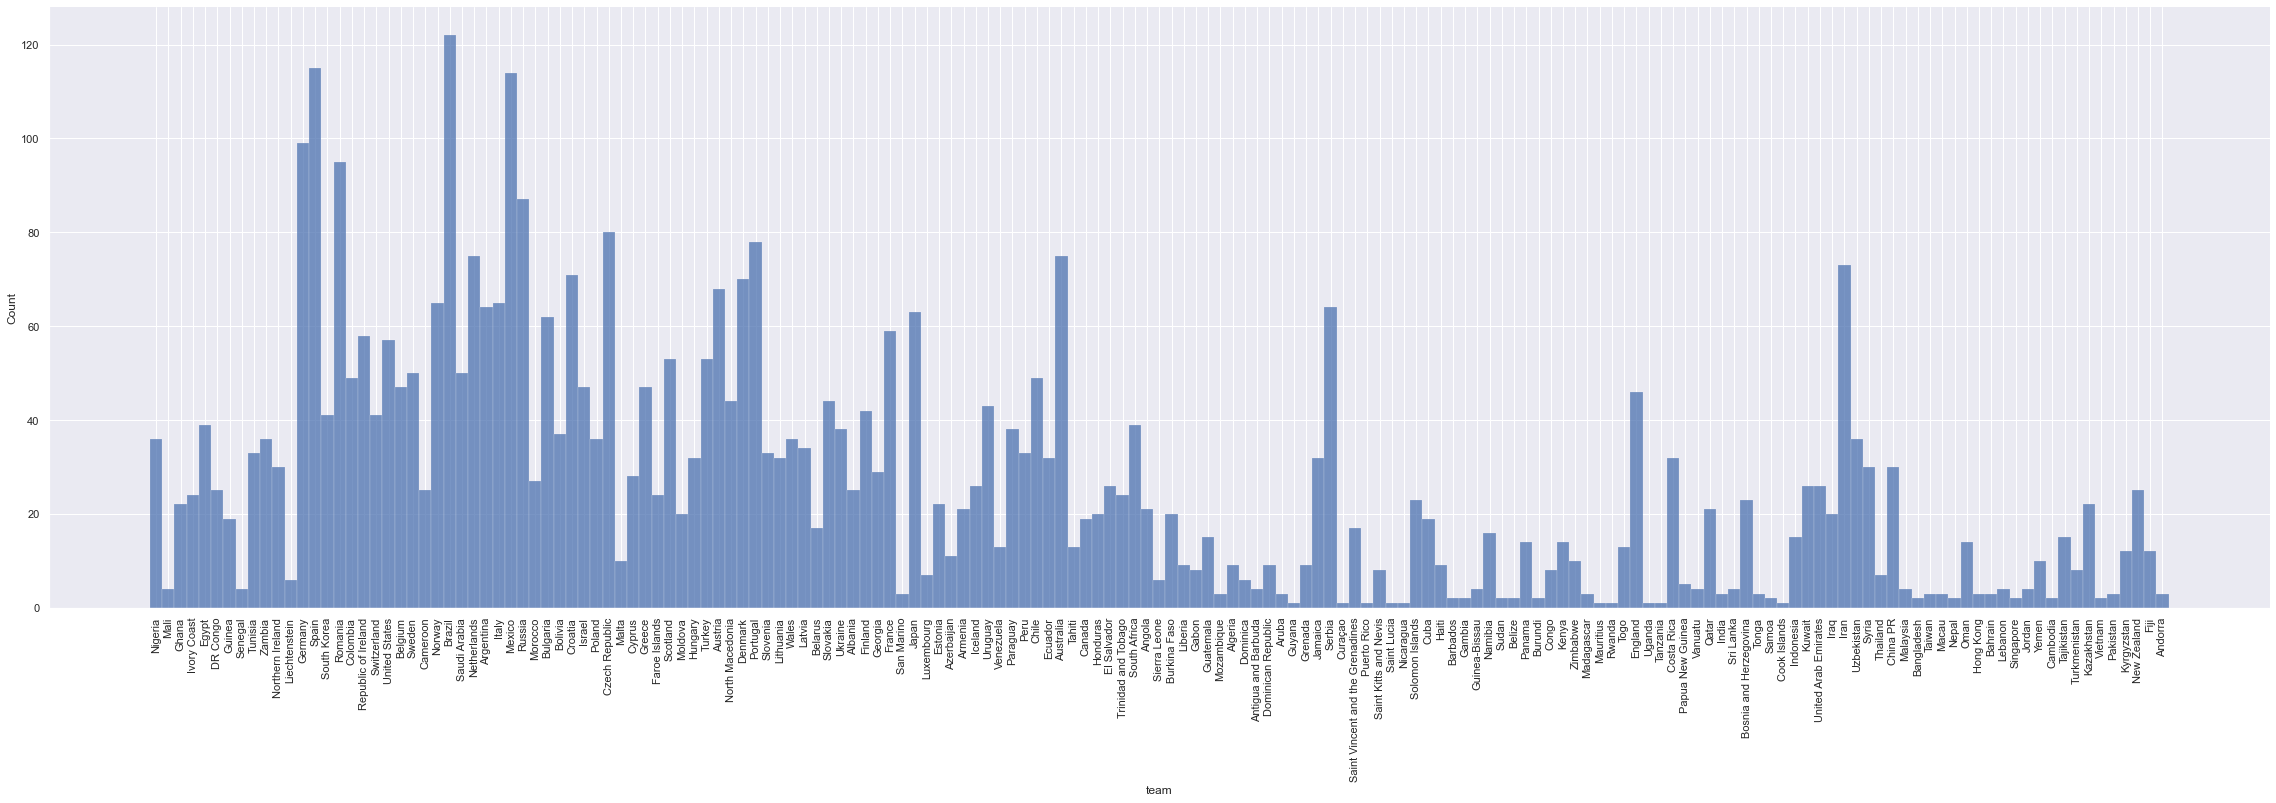

In [41]:
goal_dist = goalscorers[goalscorers['date'] <= '1999']
goal_dist = goal_dist[goal_dist['date'] >= '1994']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2000 to 2003**

Below we can see the most frequent home teams from 2000 to 2003; a period that includes major impactful world events, such as the turn of the millennium, the September 11 attacks, the wars in Afghanistan and Iraq, among others.

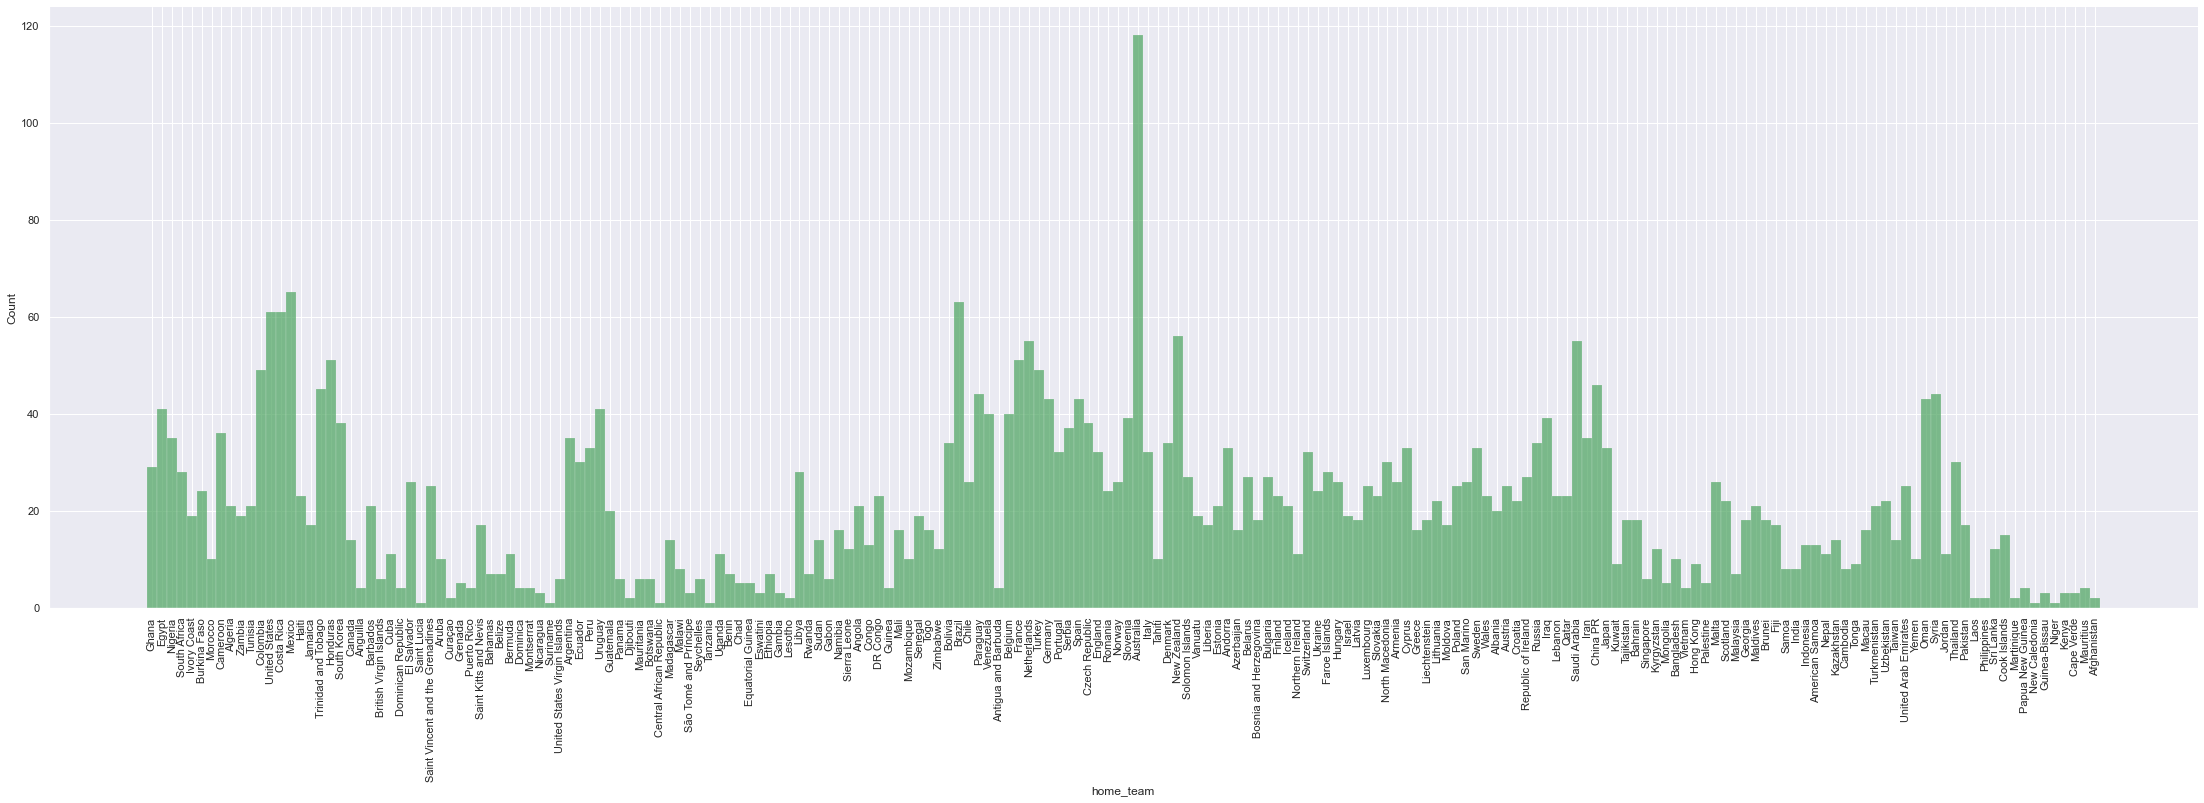

In [42]:
home_team = goalscorers[goalscorers['date'] <= '2003']
home_team = home_team[home_team['date'] >= '2000']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2000 to 2003; a period that includes major impactful world events, such as the turn of the millennium, the September 11 attacks, the wars in Afghanistan and Iraq, among others.

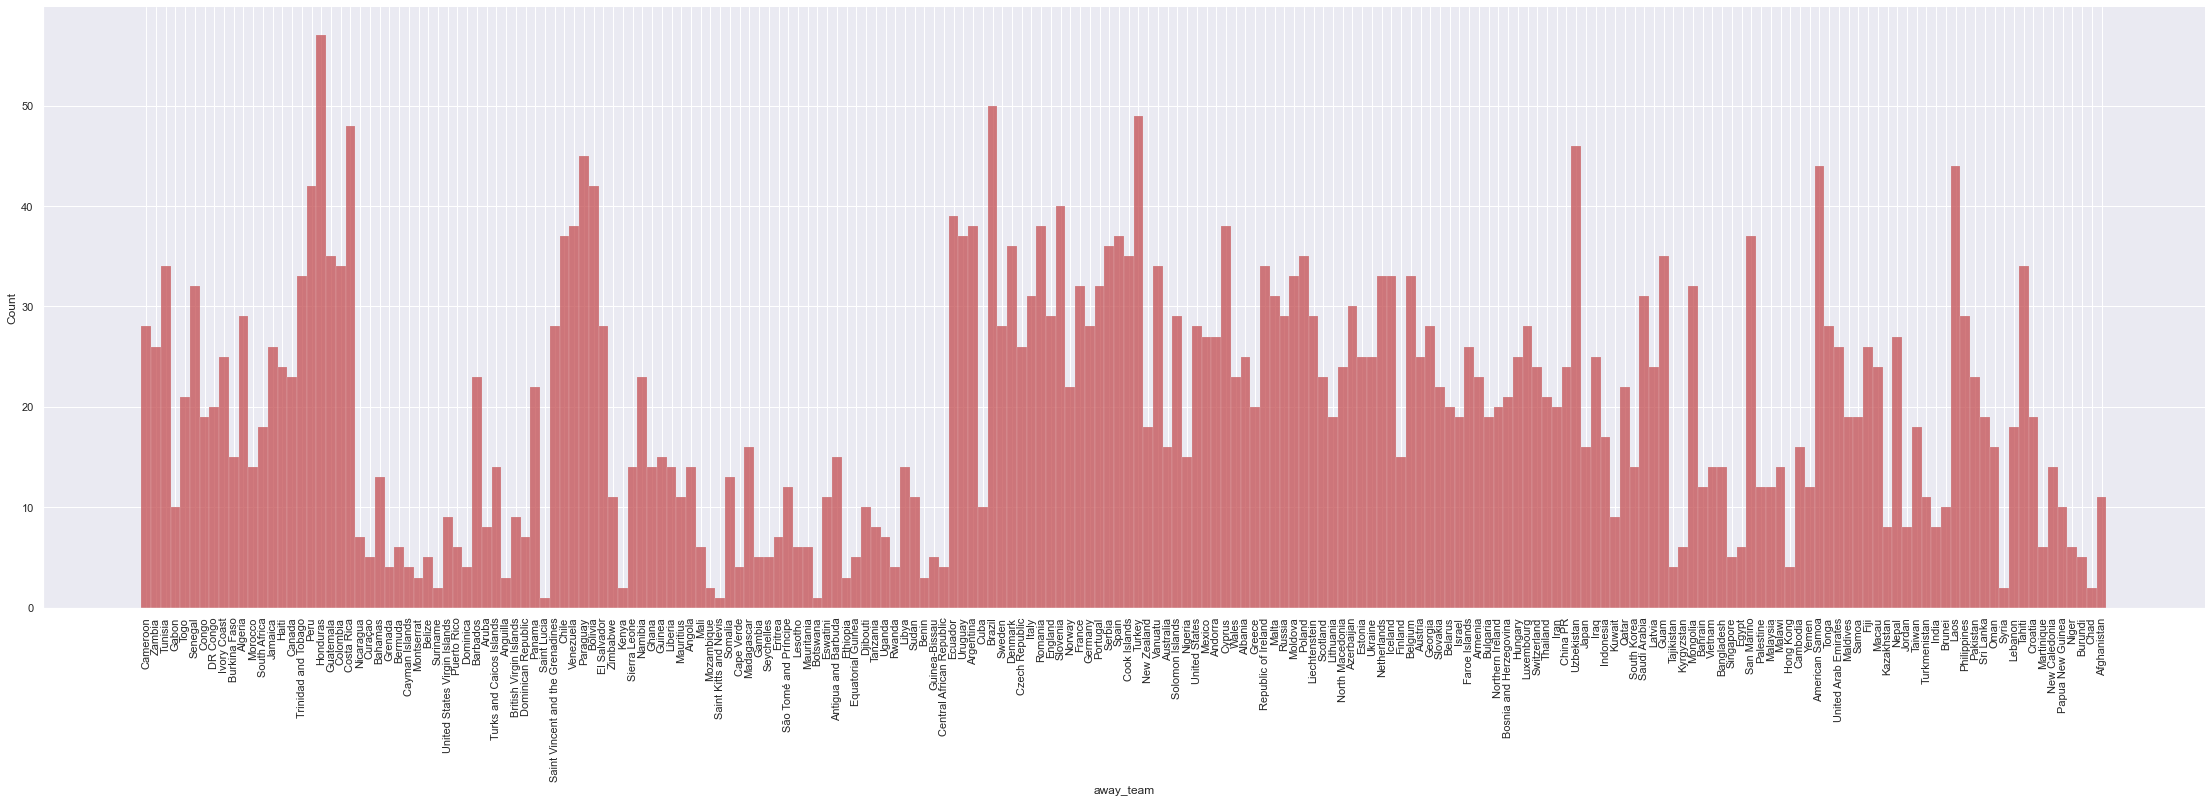

In [43]:
away_team = goalscorers[goalscorers['date'] <= '2003']
away_team = away_team[away_team['date'] >= '2000']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2000 to 2003; a period that includes major world events of impact, such as the turn of the millennium, the September 11 attacks, the wars in Afghanistan and Iraq, among others.

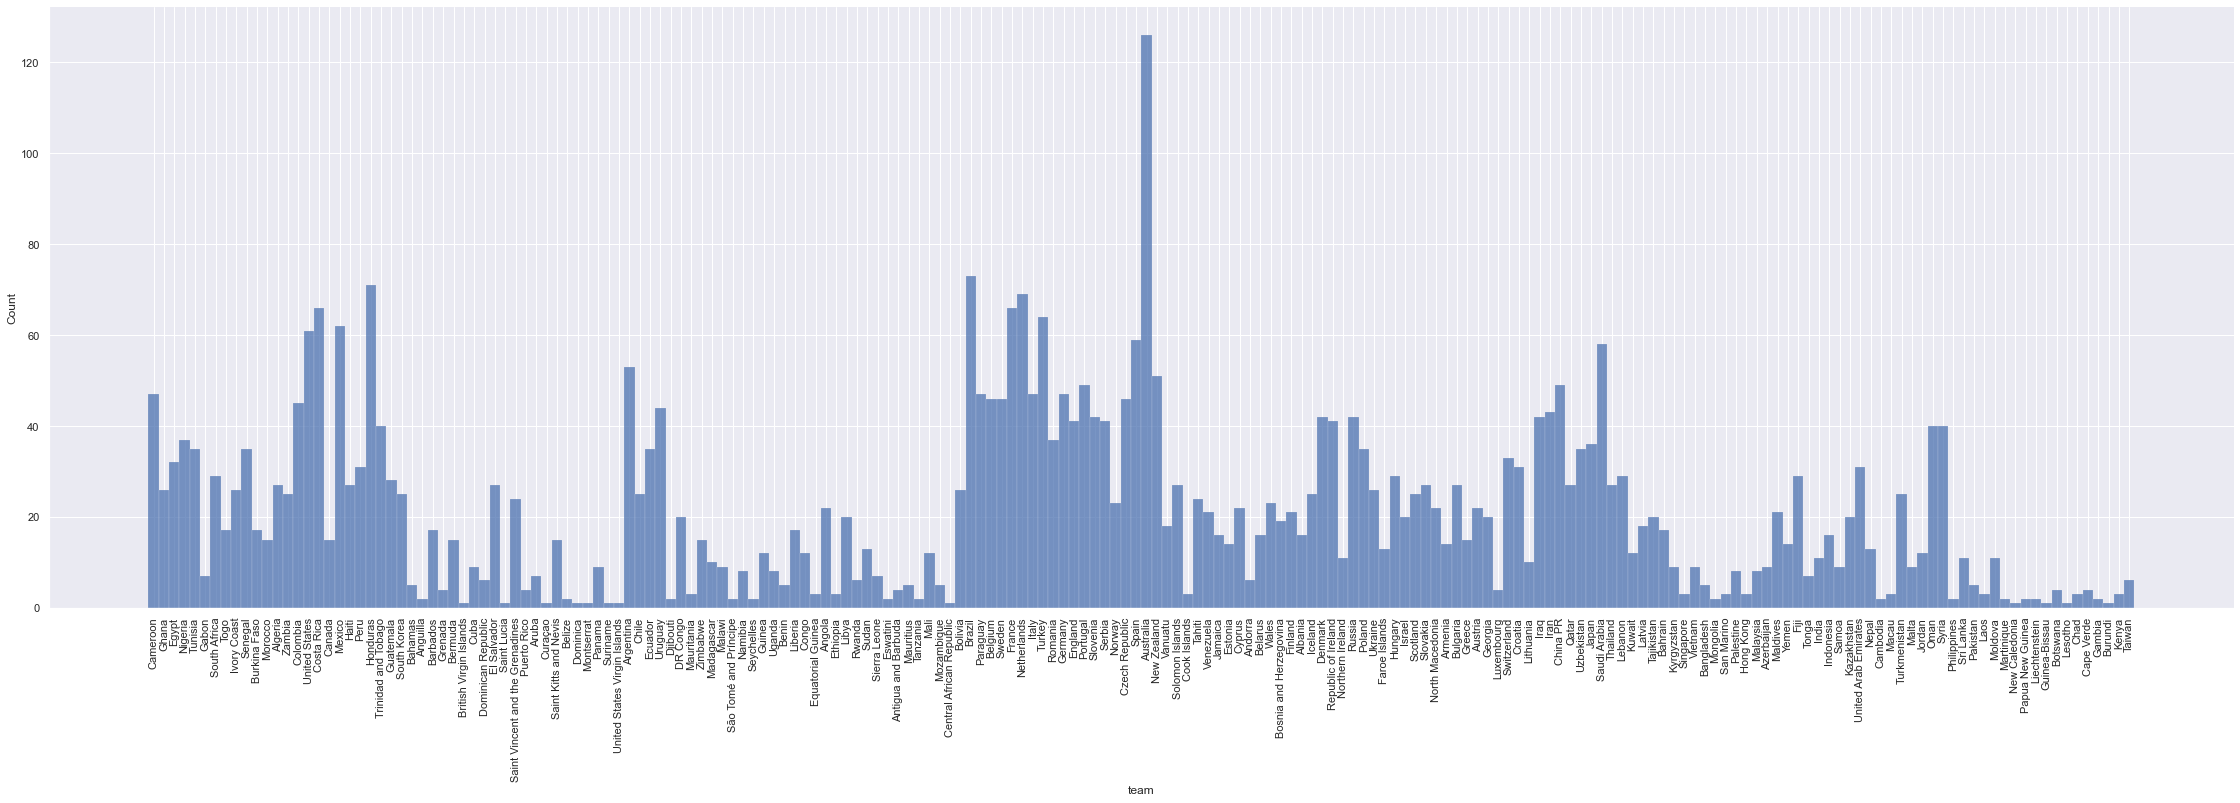

In [44]:
goal_dist = goalscorers[goalscorers['date'] <= '2003']
goal_dist = goal_dist[goal_dist['date'] >= '2000']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2004 to 2005**

Below we can see the most frequent home teams from 2004 to 2005; a period that includes major world events of impact, such as the attacks in Madrid and London.

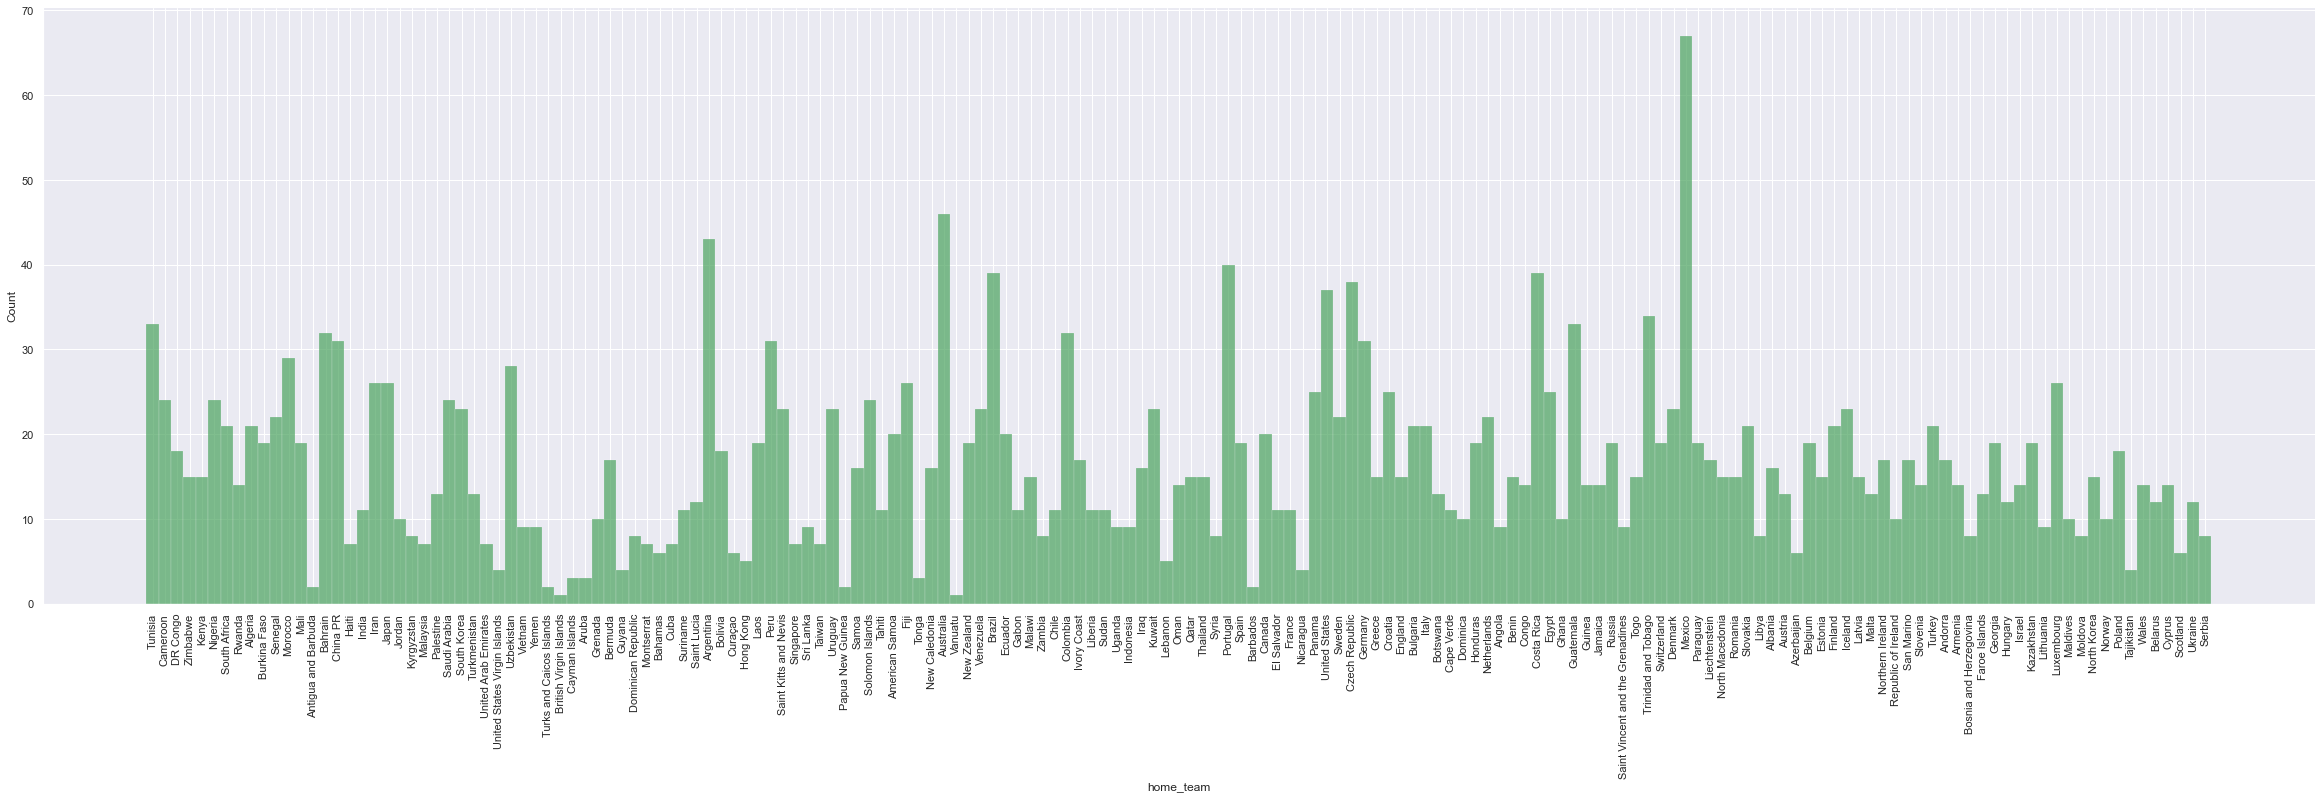

In [45]:
home_team = goalscorers[goalscorers['date'] <= '2005']
home_team = home_team[home_team['date'] >= '2004']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2004 to 2005; a period that includes major world events of impact, such as the attacks in Madrid and London.

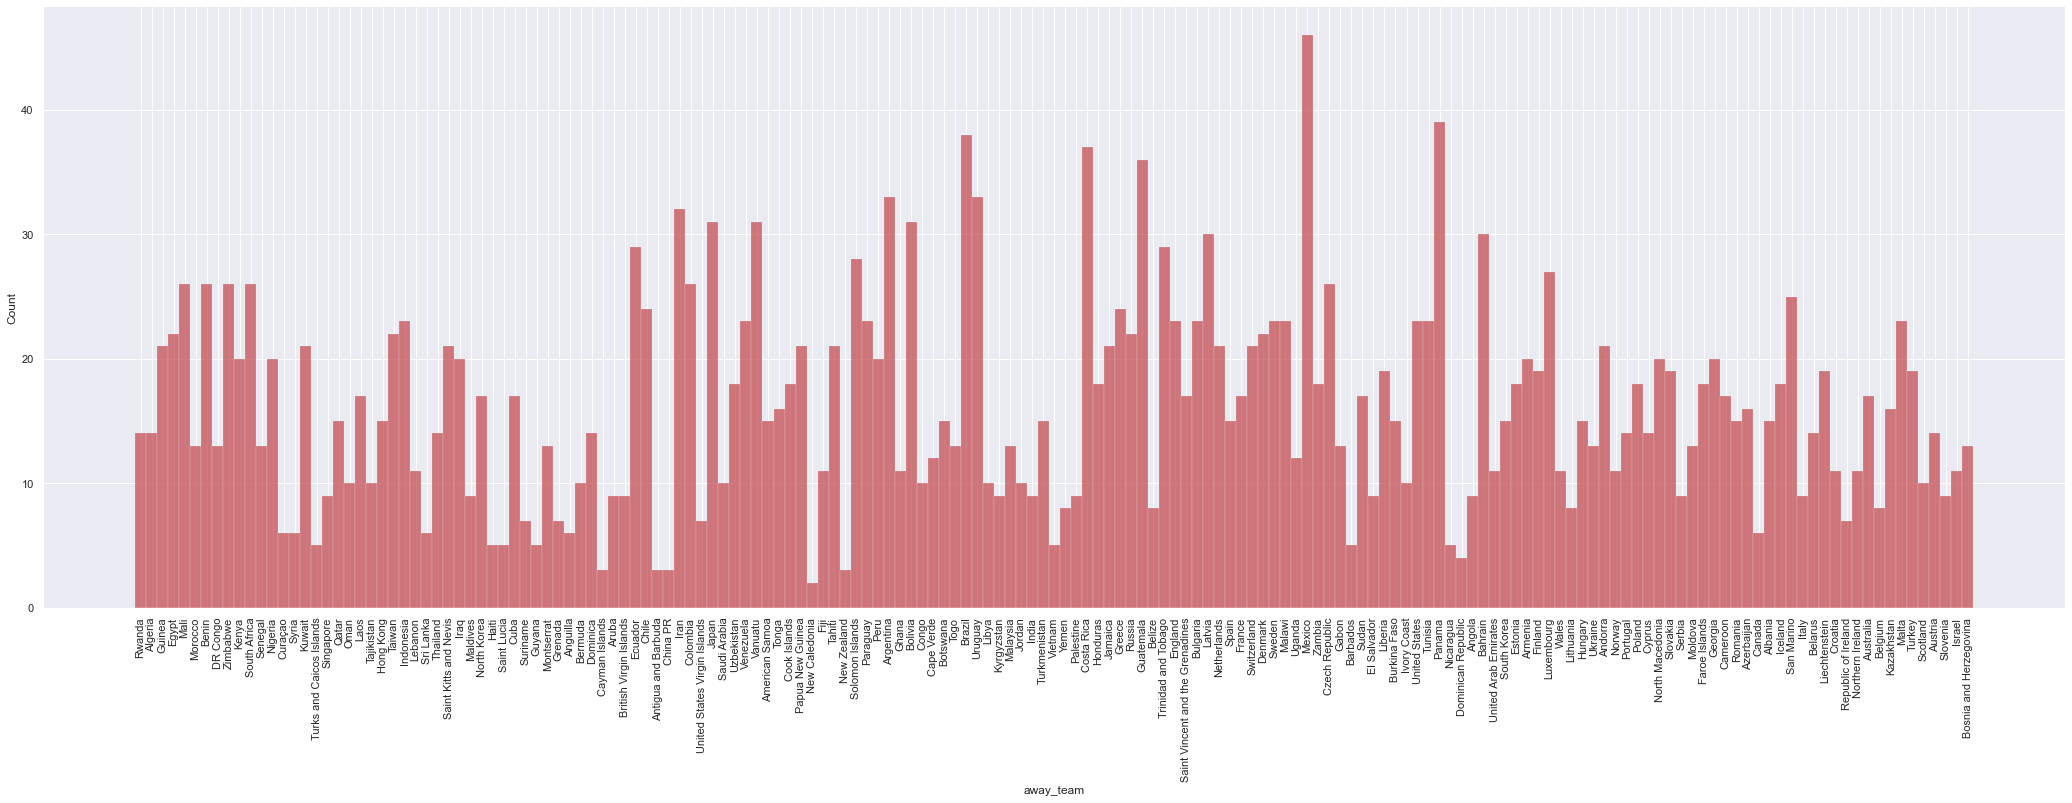

In [46]:
away_team = goalscorers[goalscorers['date'] <= '2005']
away_team = away_team[away_team['date'] >= '2004']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2004 to 2005; a period that includes major world events of impact, such as the attacks in Madrid and London.

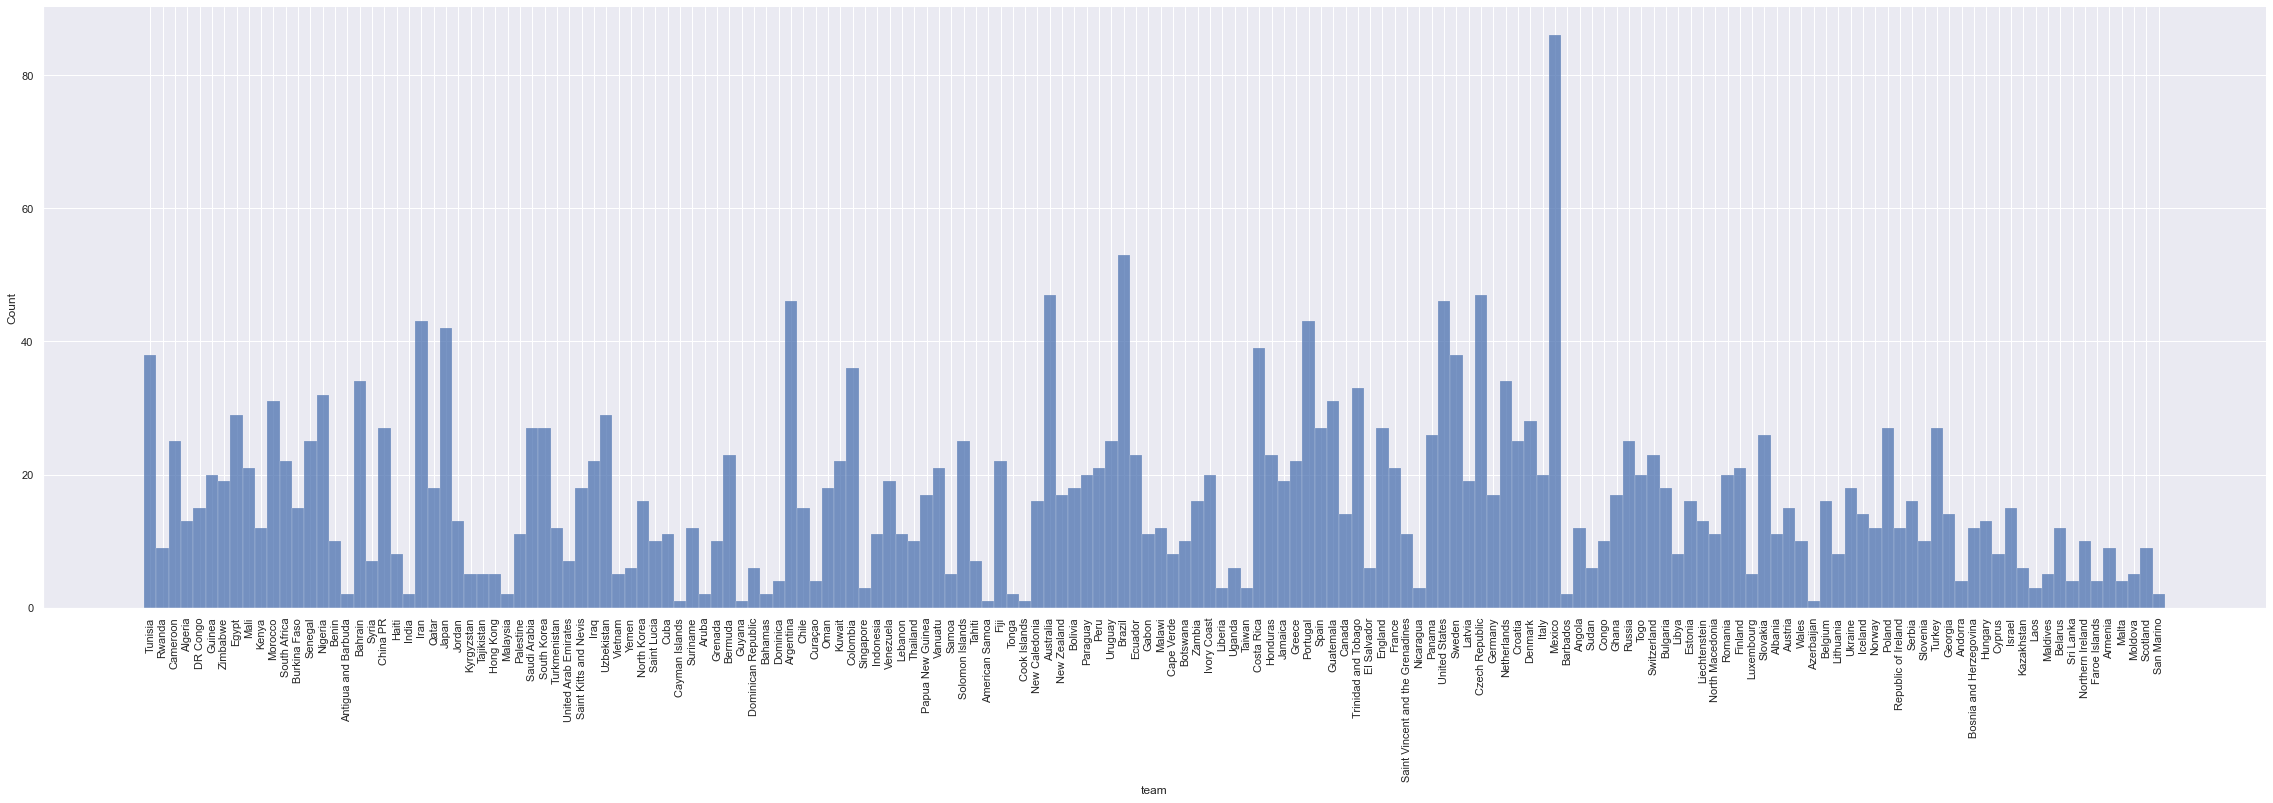

In [47]:
goal_dist = goalscorers[goalscorers['date'] <= '2005']
goal_dist = goal_dist[goal_dist['date'] >= '2004']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2006 to 2007**

Below we can see the most frequent home teams from 2006 to 2007; a period that includes major world events of impact, such as the publication of cartoons of Mohammed in a Danish newspaper and the UN release of a report indicating that human activities are responsible for climate change.

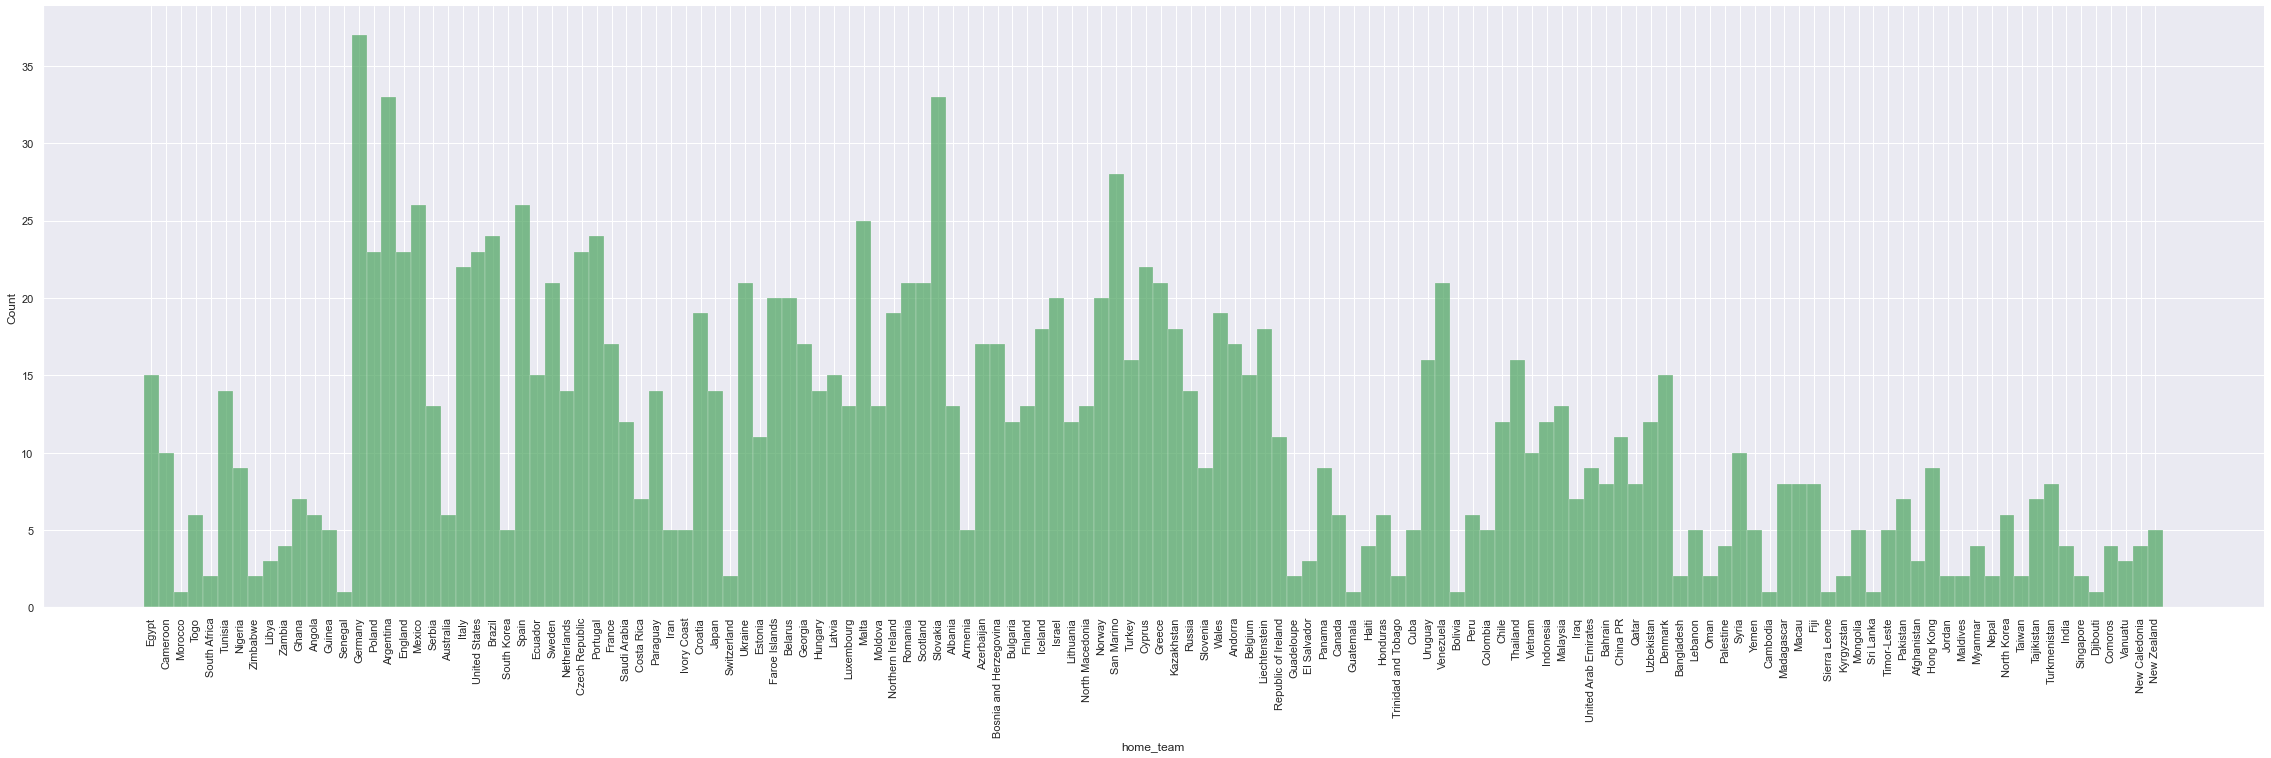

In [48]:
home_team = goalscorers[goalscorers['date'] <= '2007']
home_team = home_team[home_team['date'] >= '2006']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2006 to 2007; a period that includes major world events of impact, such as the publication of cartoons of Mohammed in a Danish newspaper and the UN release of a report indicating that human activities are responsible for climate change.

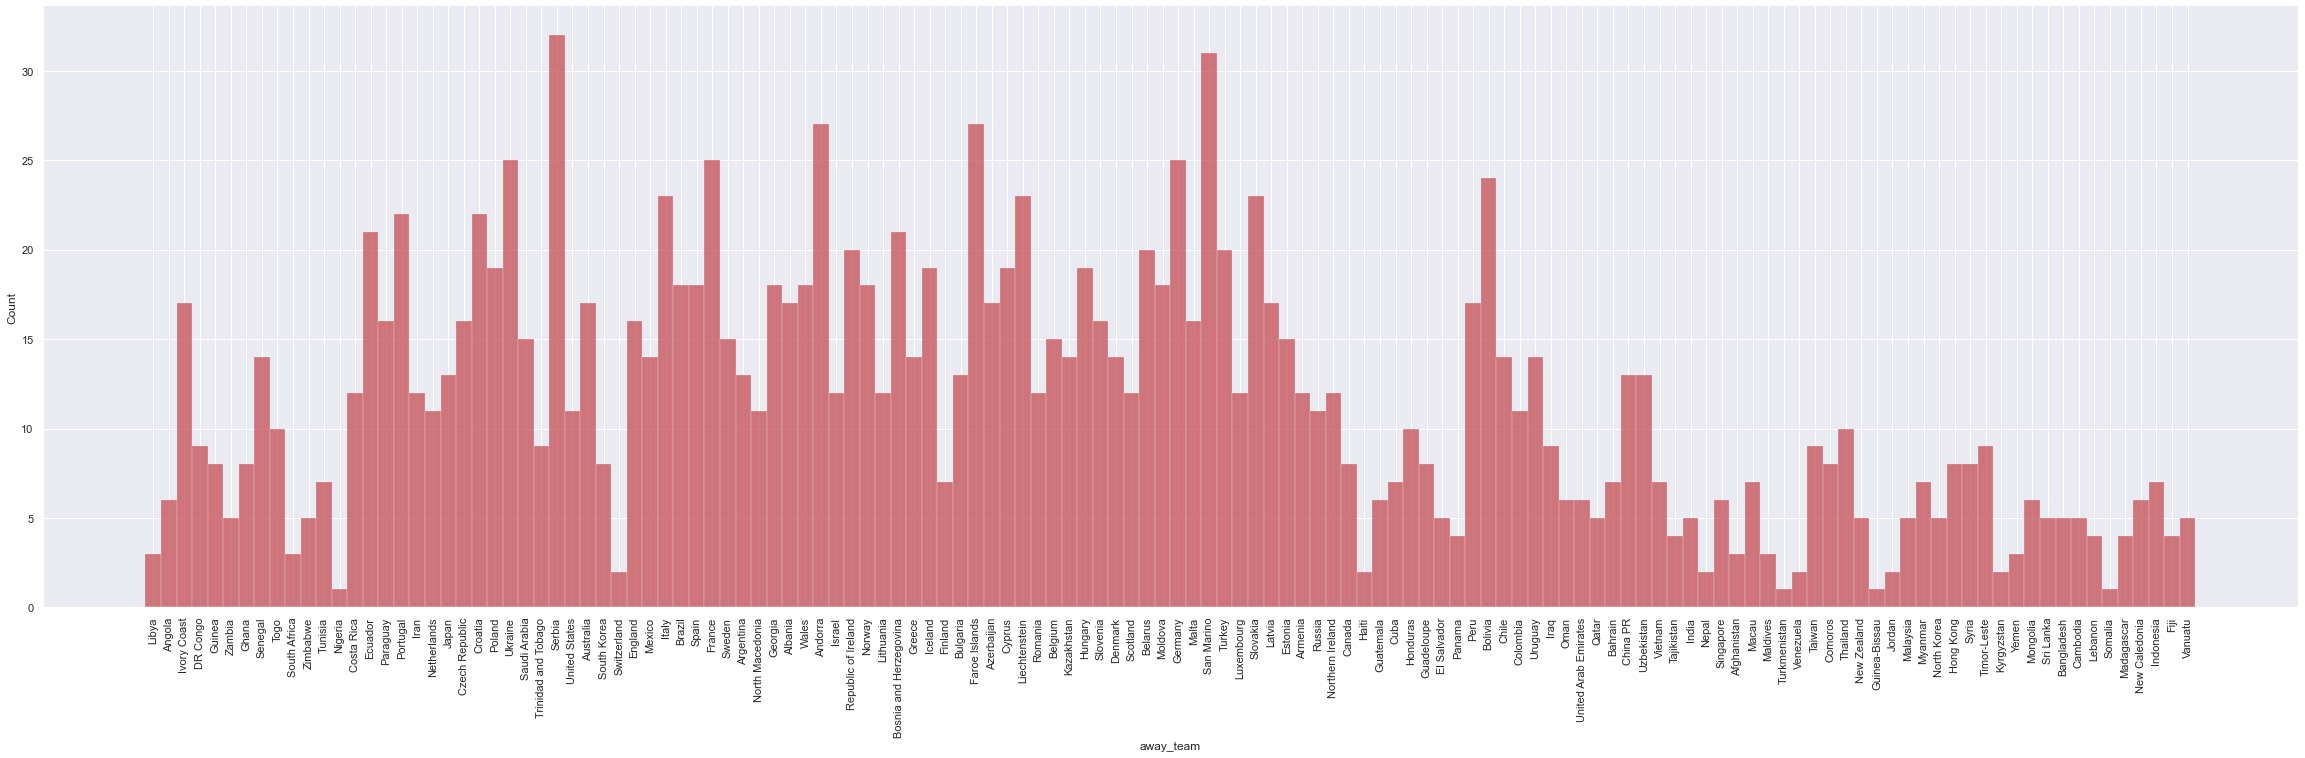

In [49]:
away_team = goalscorers[goalscorers['date'] <= '2007']
away_team = away_team[away_team['date'] >= '2006']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2006 to 2007; a period that includes major world events of impact, such as the publication of Muhammad's cartoons in a Danish newspaper and the release by the UN of a report indicating that human activities are responsible for climate change.

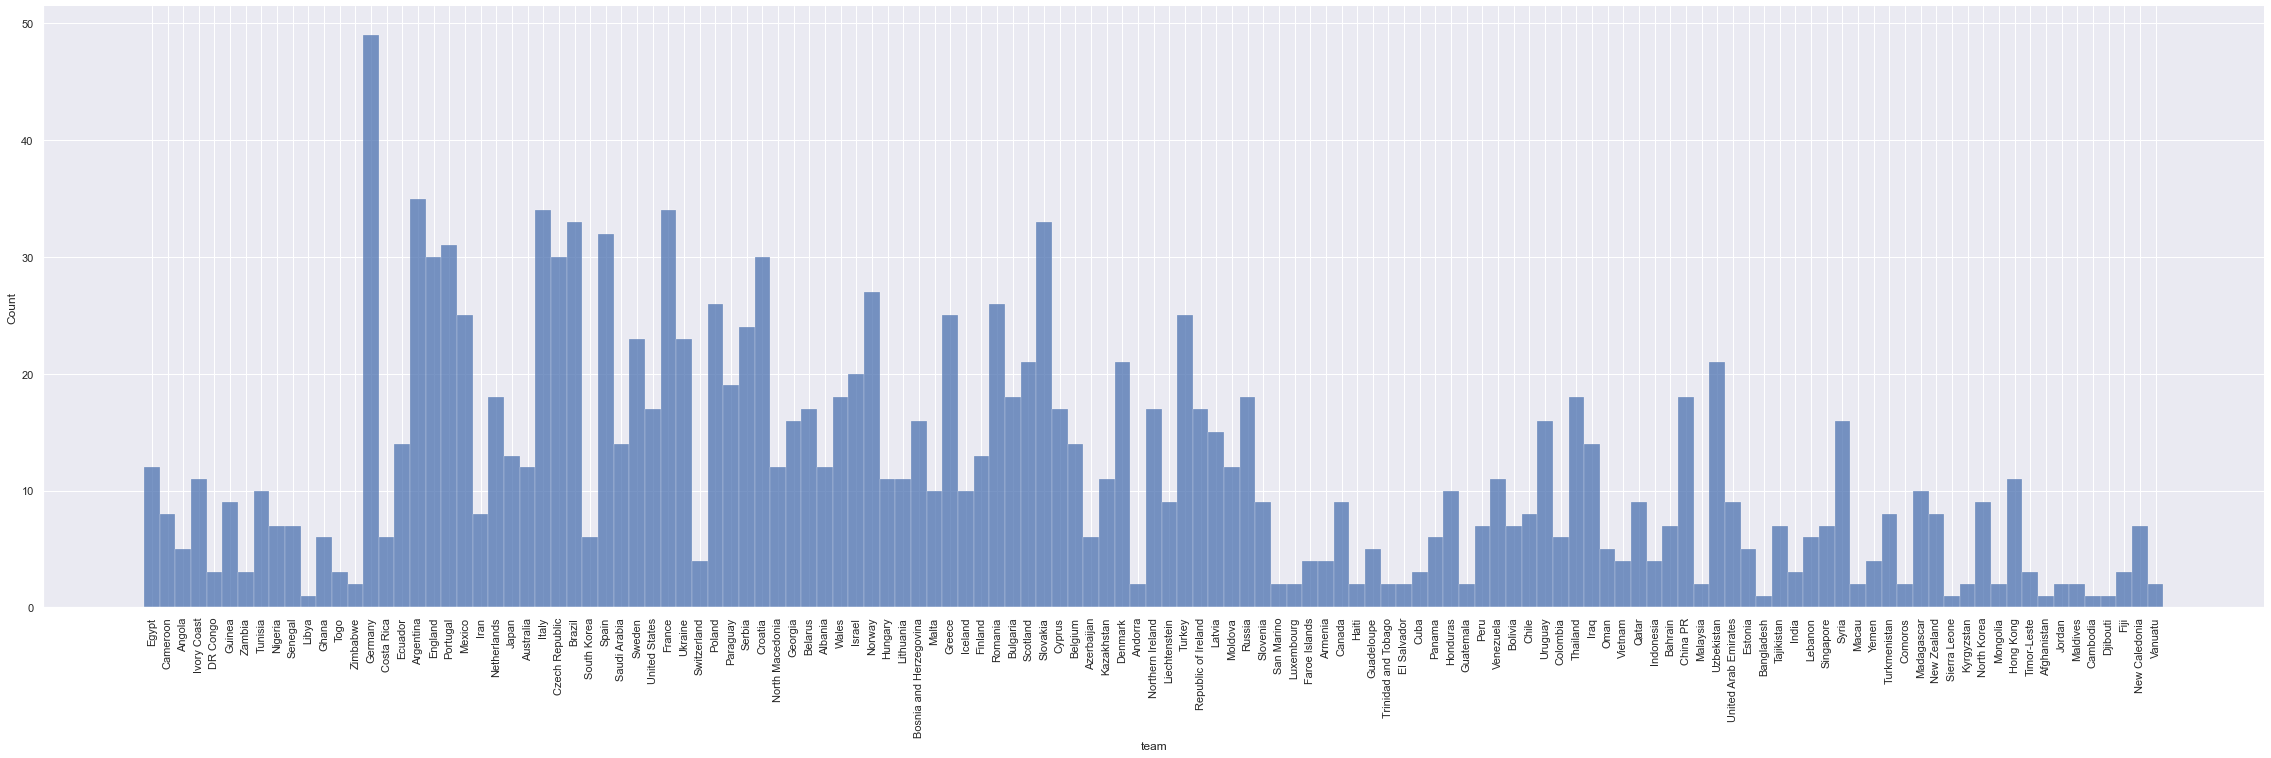

In [50]:
goal_dist = goalscorers[goalscorers['date'] <= '2007']
goal_dist = goal_dist[goal_dist['date'] >= '2006']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2007 to 2008**

Below we can see the most frequent home teams from 2007 to 2008; a period that includes major world impact events such as the global economic crisis.

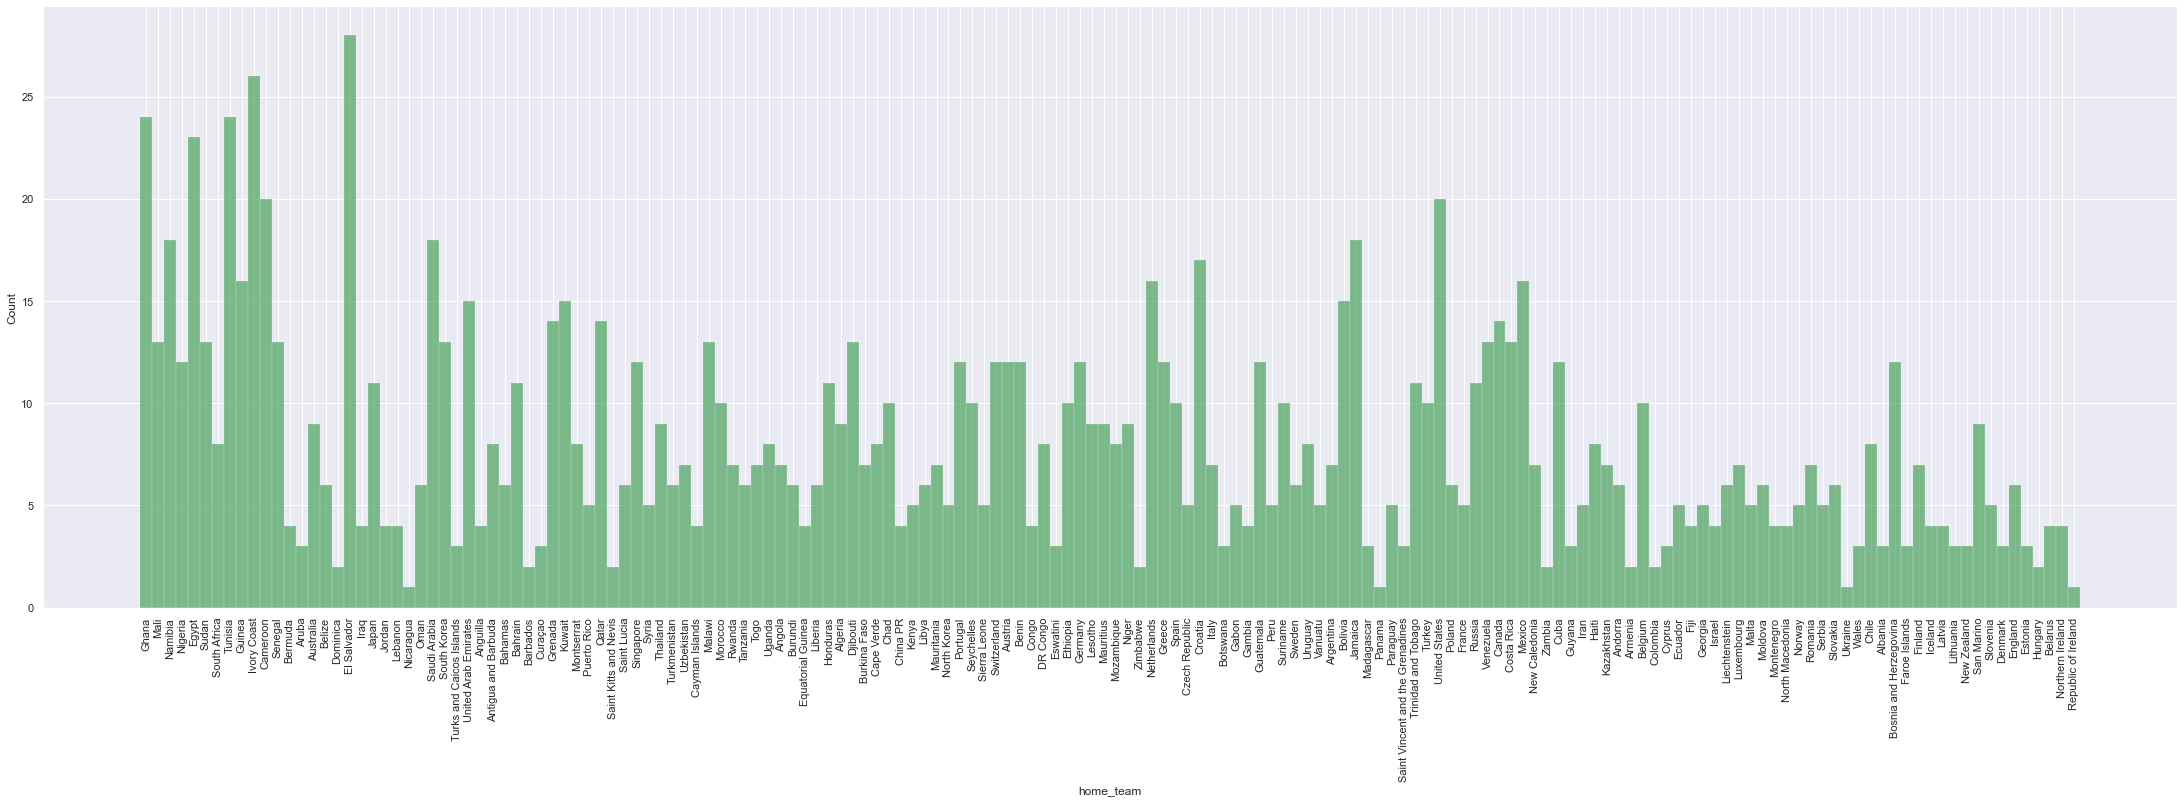

In [51]:
home_team = goalscorers[goalscorers['date'] <= '2008']
home_team = home_team[home_team['date'] > '2007']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2007 to 2008; a period that includes major world impact events such as the global economic crisis.

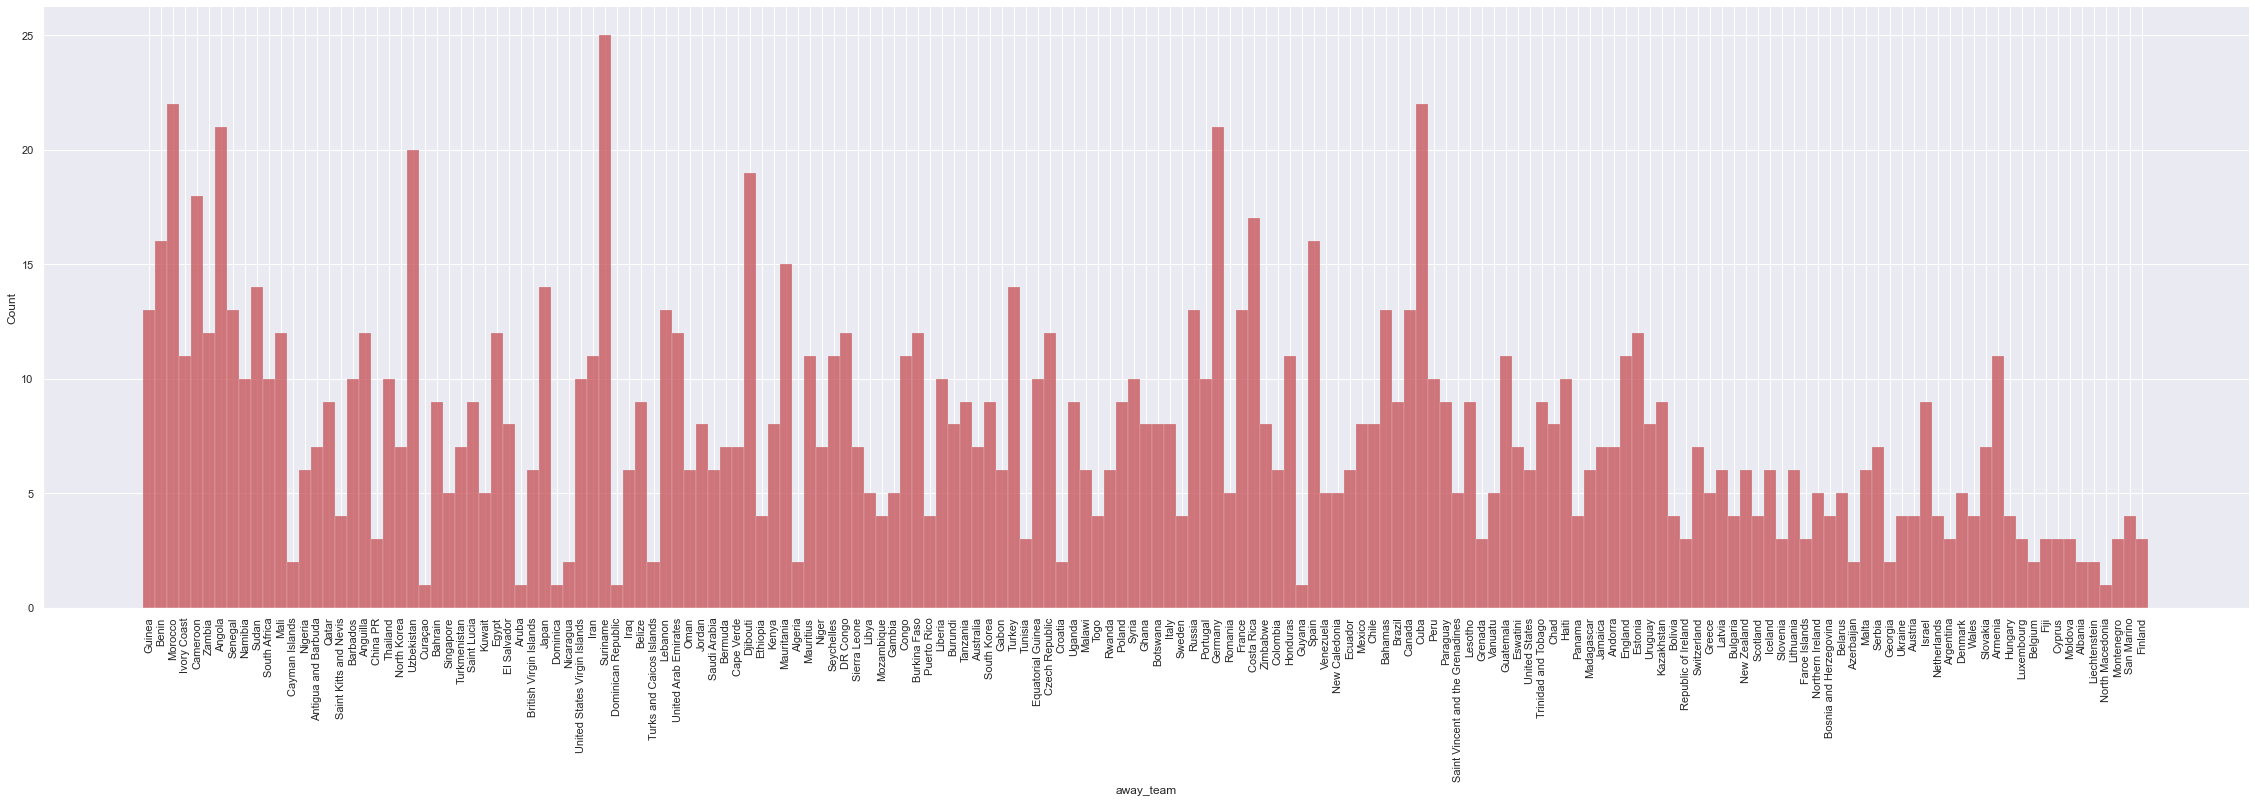

In [52]:
away_team = goalscorers[goalscorers['date'] <= '2008']
away_team = away_team[away_team['date'] > '2007']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2007 to 2008; a period that includes events of great global impact, such as the global economic crisis.

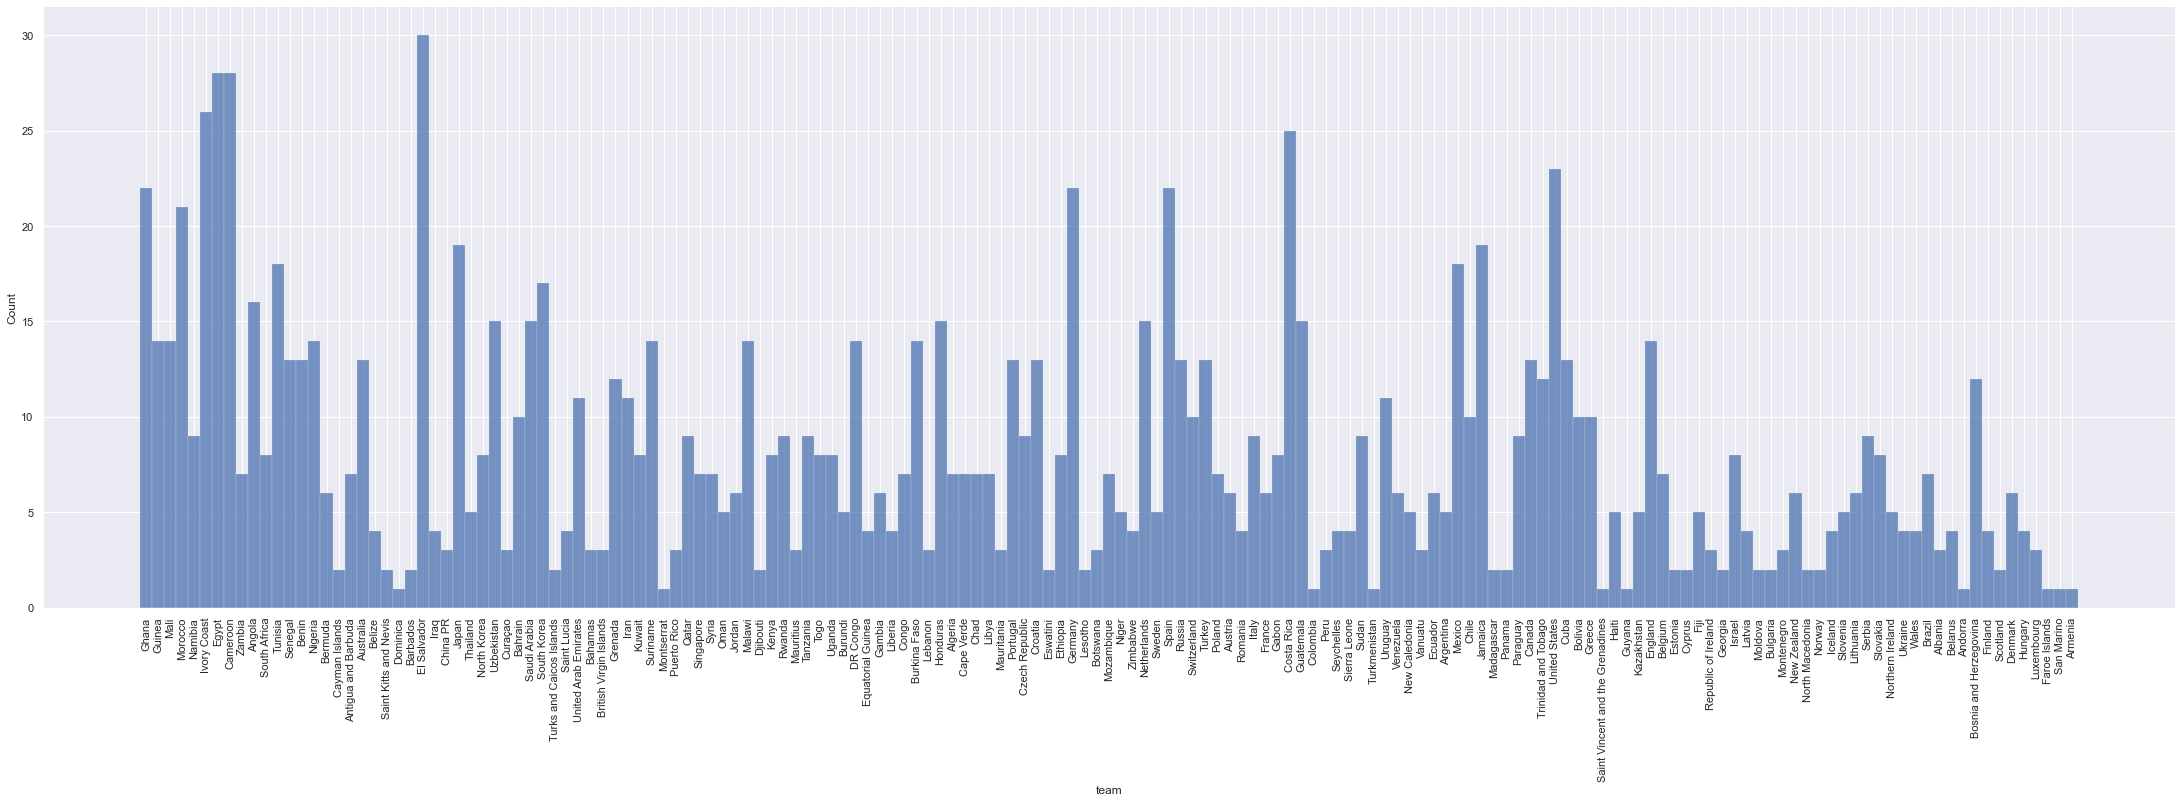

In [53]:
goal_dist = goalscorers[goalscorers['date'] <= '2008']
goal_dist = goal_dist[goal_dist['date'] > '2007']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2009 to 2010**

Below we can see the most frequent home teams from 2009 to 2010; a period that includes events of great global impact, such as the United Nations Conference on Climate Change in 2009 and the 2010 earthquake in Haiti.

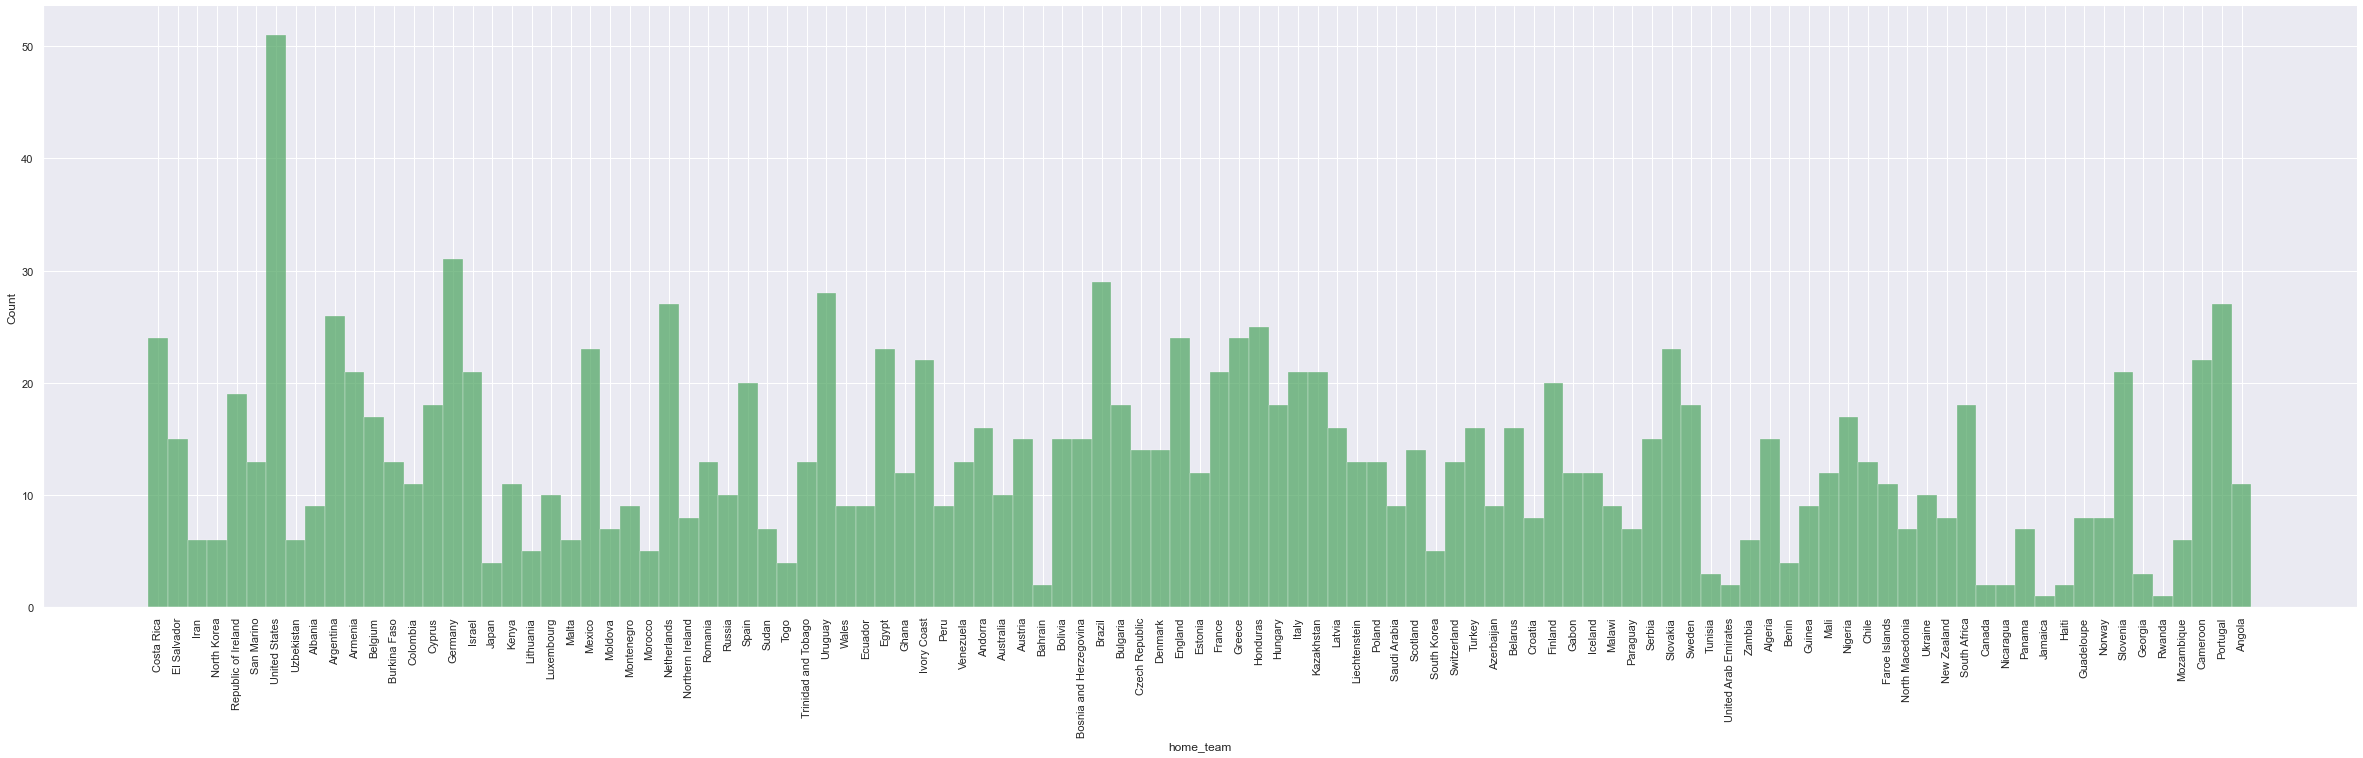

In [54]:
home_team = goalscorers[goalscorers['date'] <= '2010']
home_team = home_team[home_team['date'] >= '2009']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2009 to 2010; a period that includes events of great global impact, such as the United Nations Conference on Climate Change in 2009 and the 2010 earthquake in Haiti.

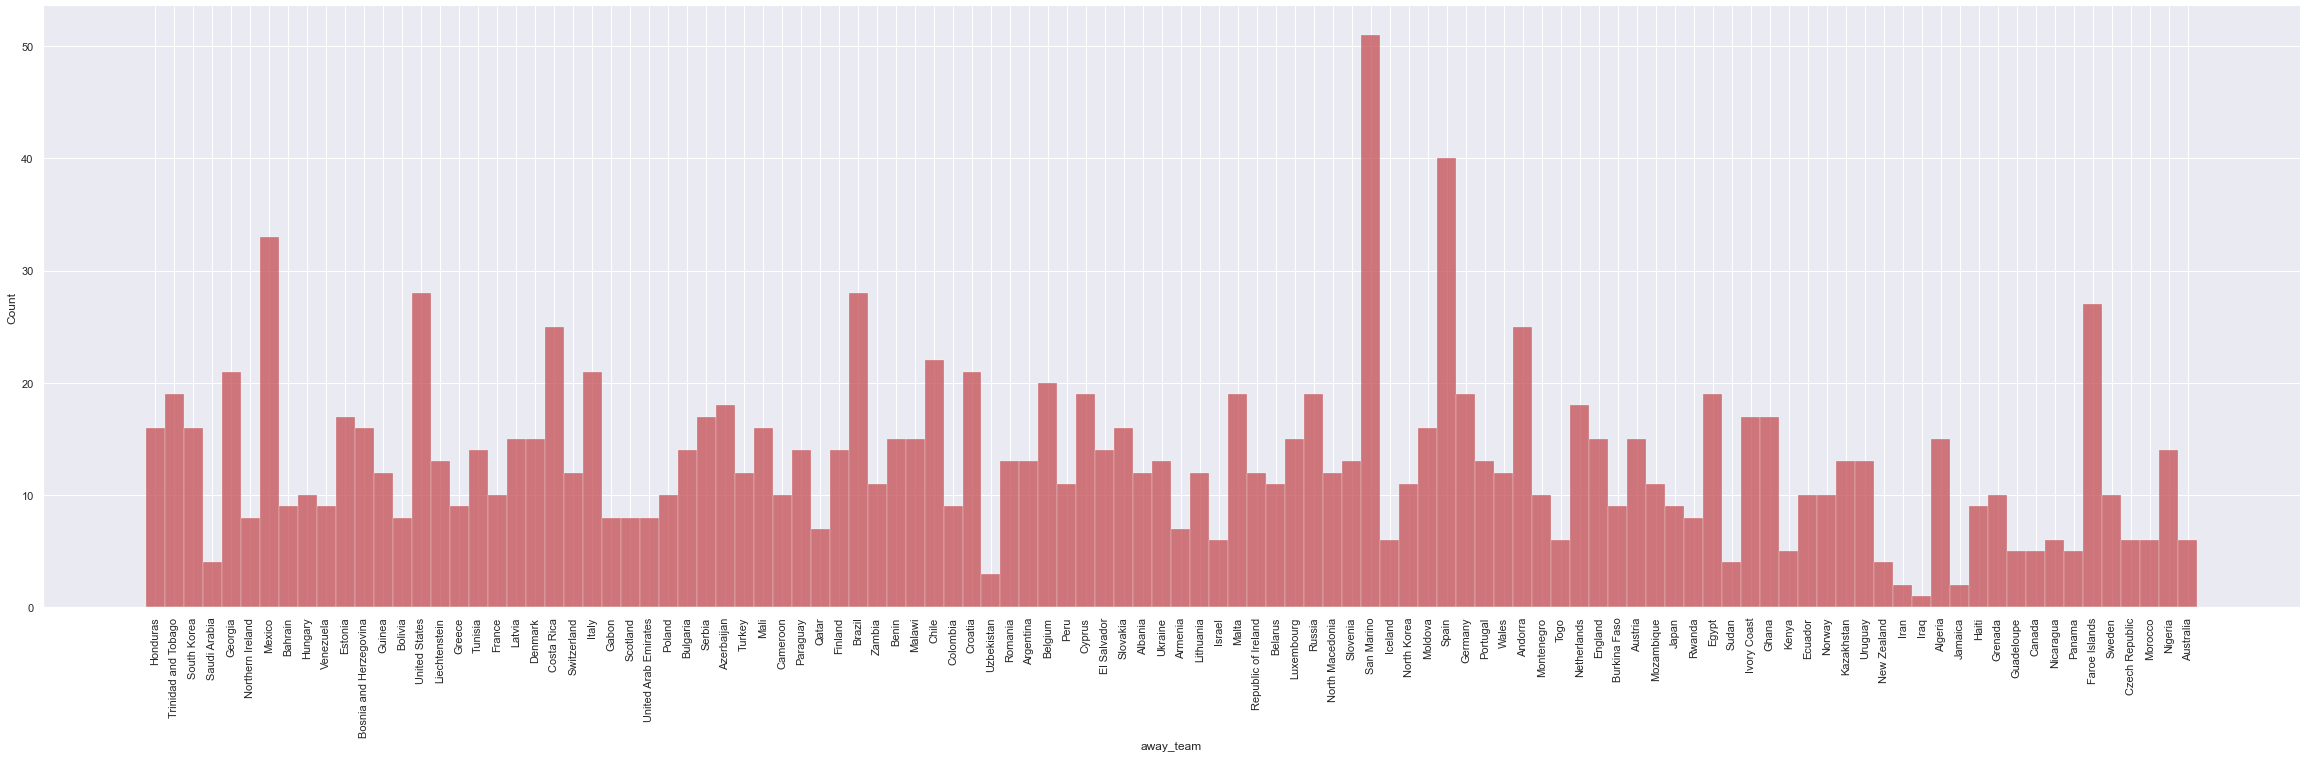

In [55]:
away_team = goalscorers[goalscorers['date'] <= '2010']
away_team = away_team[away_team['date'] >= '2009']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2009 to 2010; a period that includes events of great global impact, such as the United Nations Conference on Climate Change in 2009 and the 2010 earthquake in Haiti.

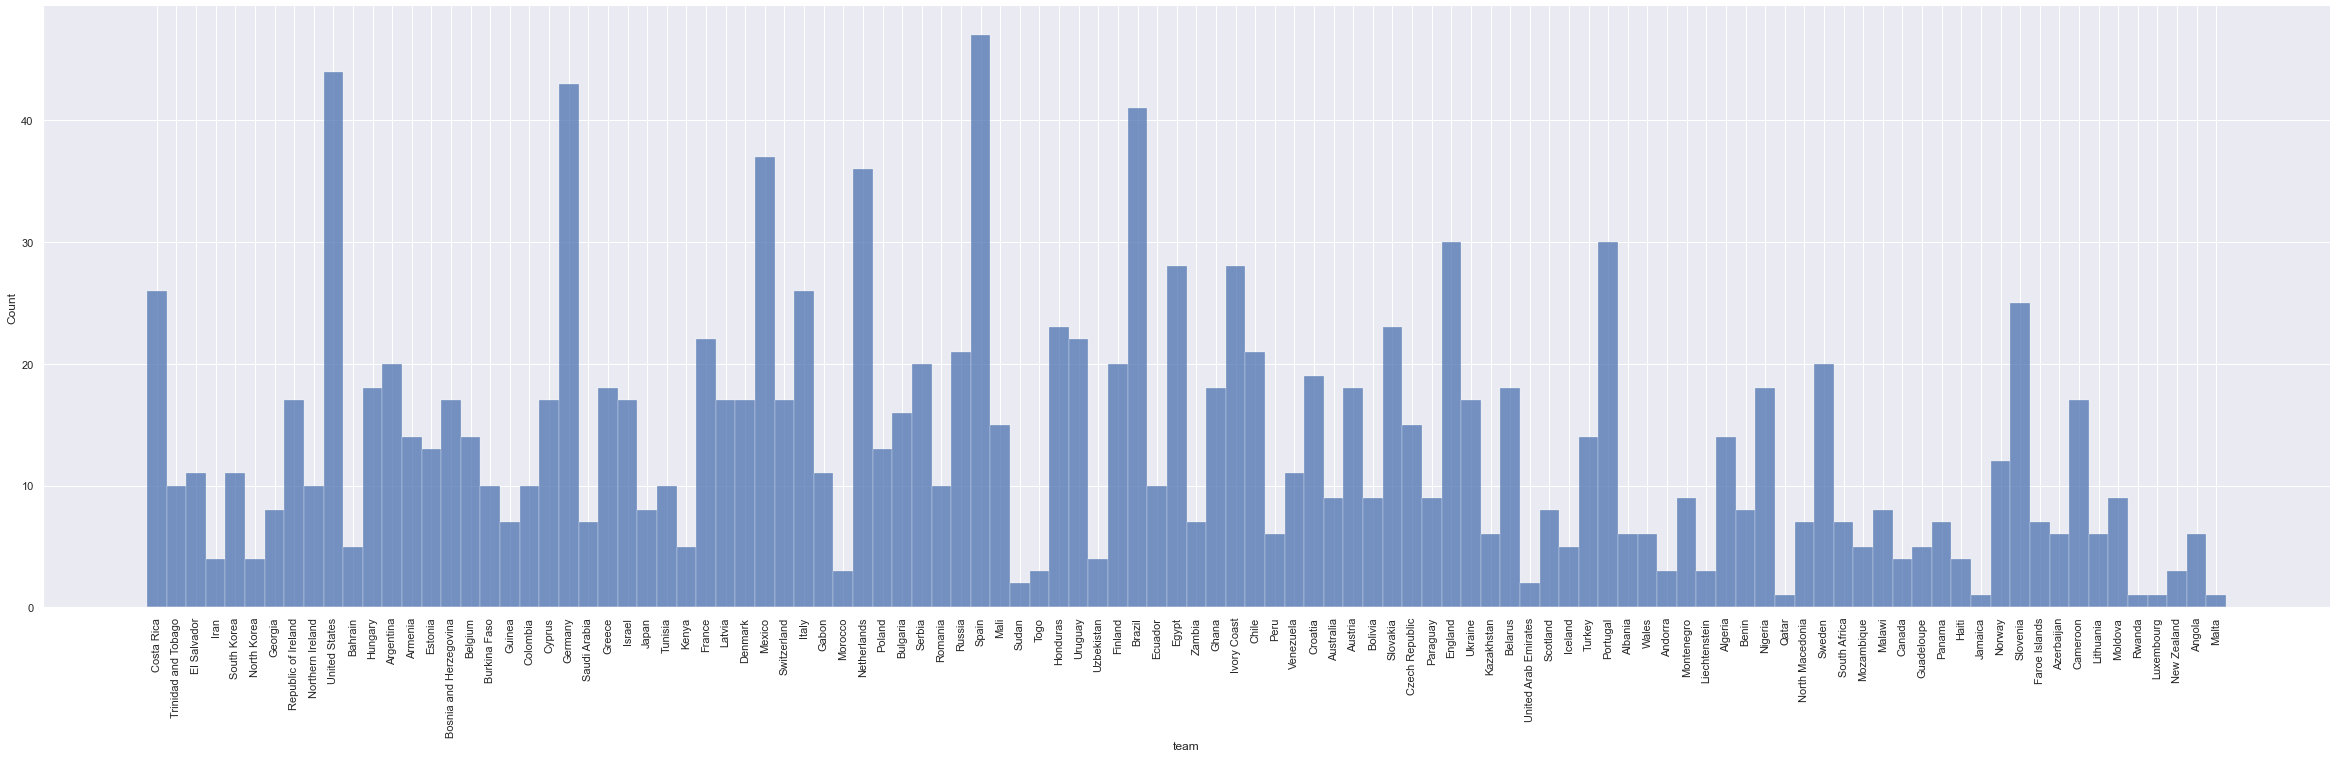

In [56]:
goal_dist = goalscorers[goalscorers['date'] <= '2010']
goal_dist = goal_dist[goal_dist['date'] >= '2009']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2011 to 2013**

Below we can see the most frequent home teams from 2011 to 2013; a period that includes events of great global impact, such as the Arab Spring, the death of Osama Bin Laden and the attack on the Boston Marathon.

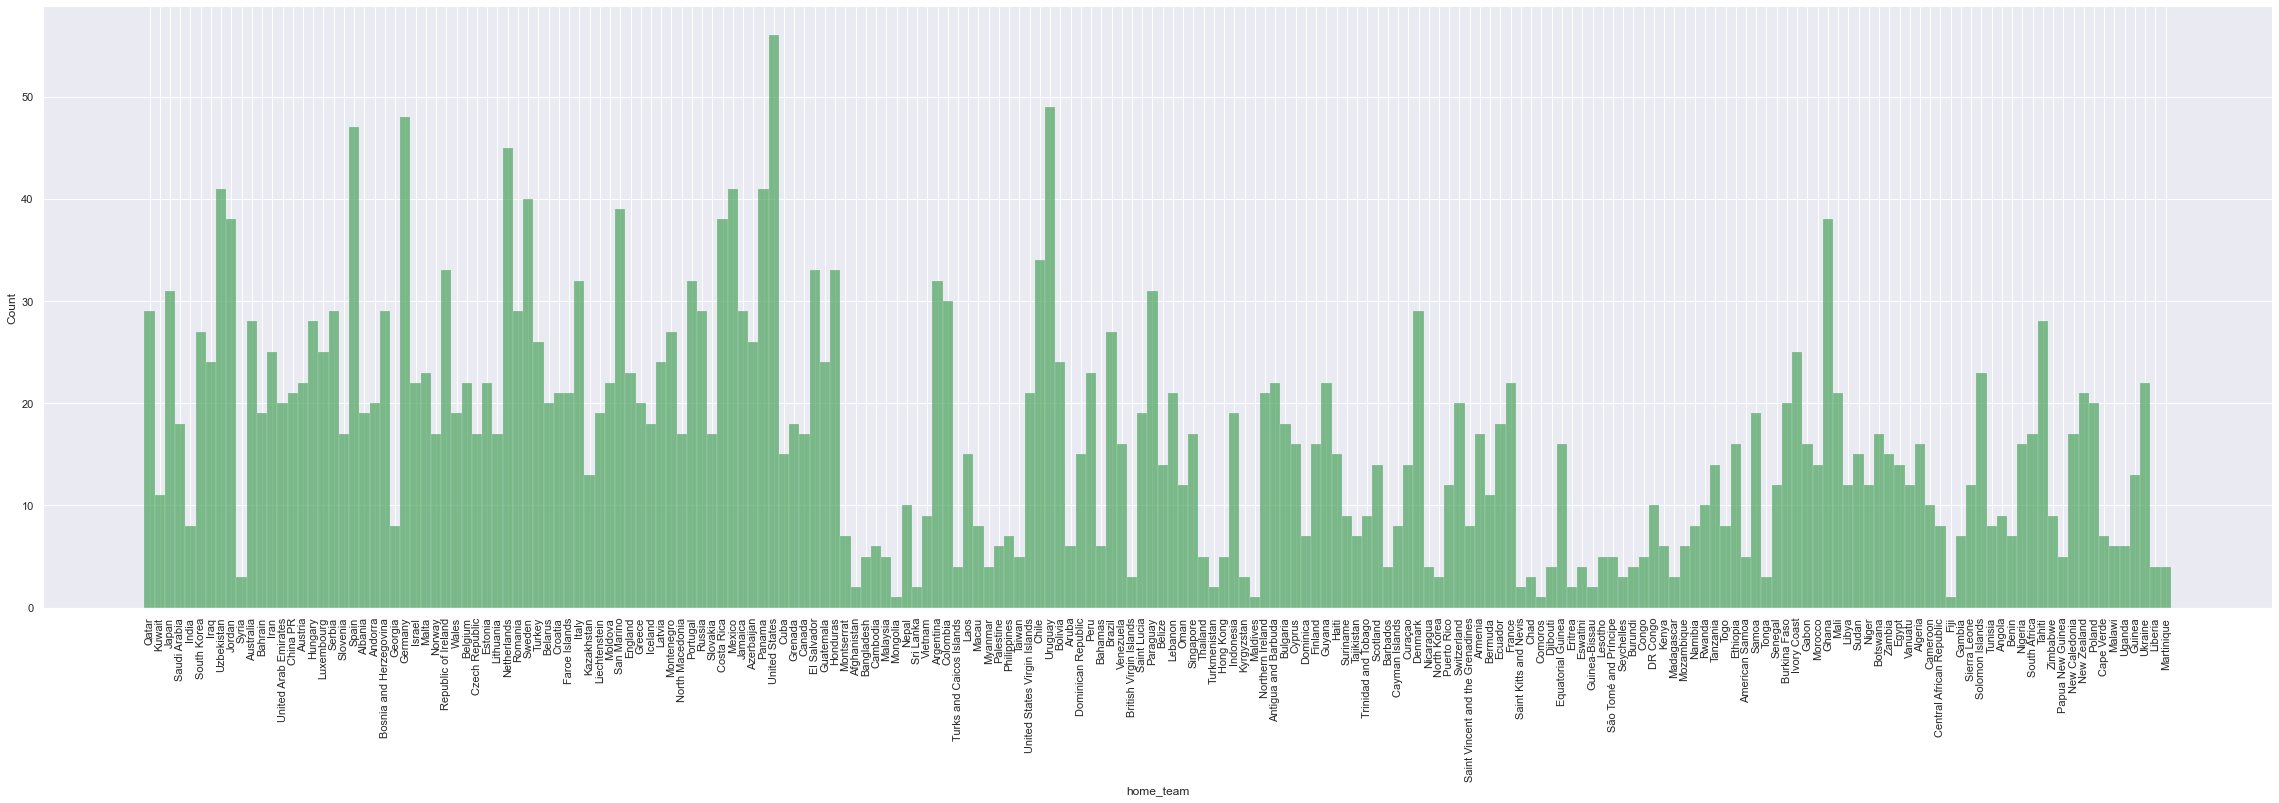

In [57]:
home_team = goalscorers[goalscorers['date'] <= '2013']
home_team = home_team[home_team['date'] >= '2011']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2011 to 2013; a period that includes events of great global impact, such as the Arab Spring, the death of Osama Bin Laden and the attack on the Boston Marathon.

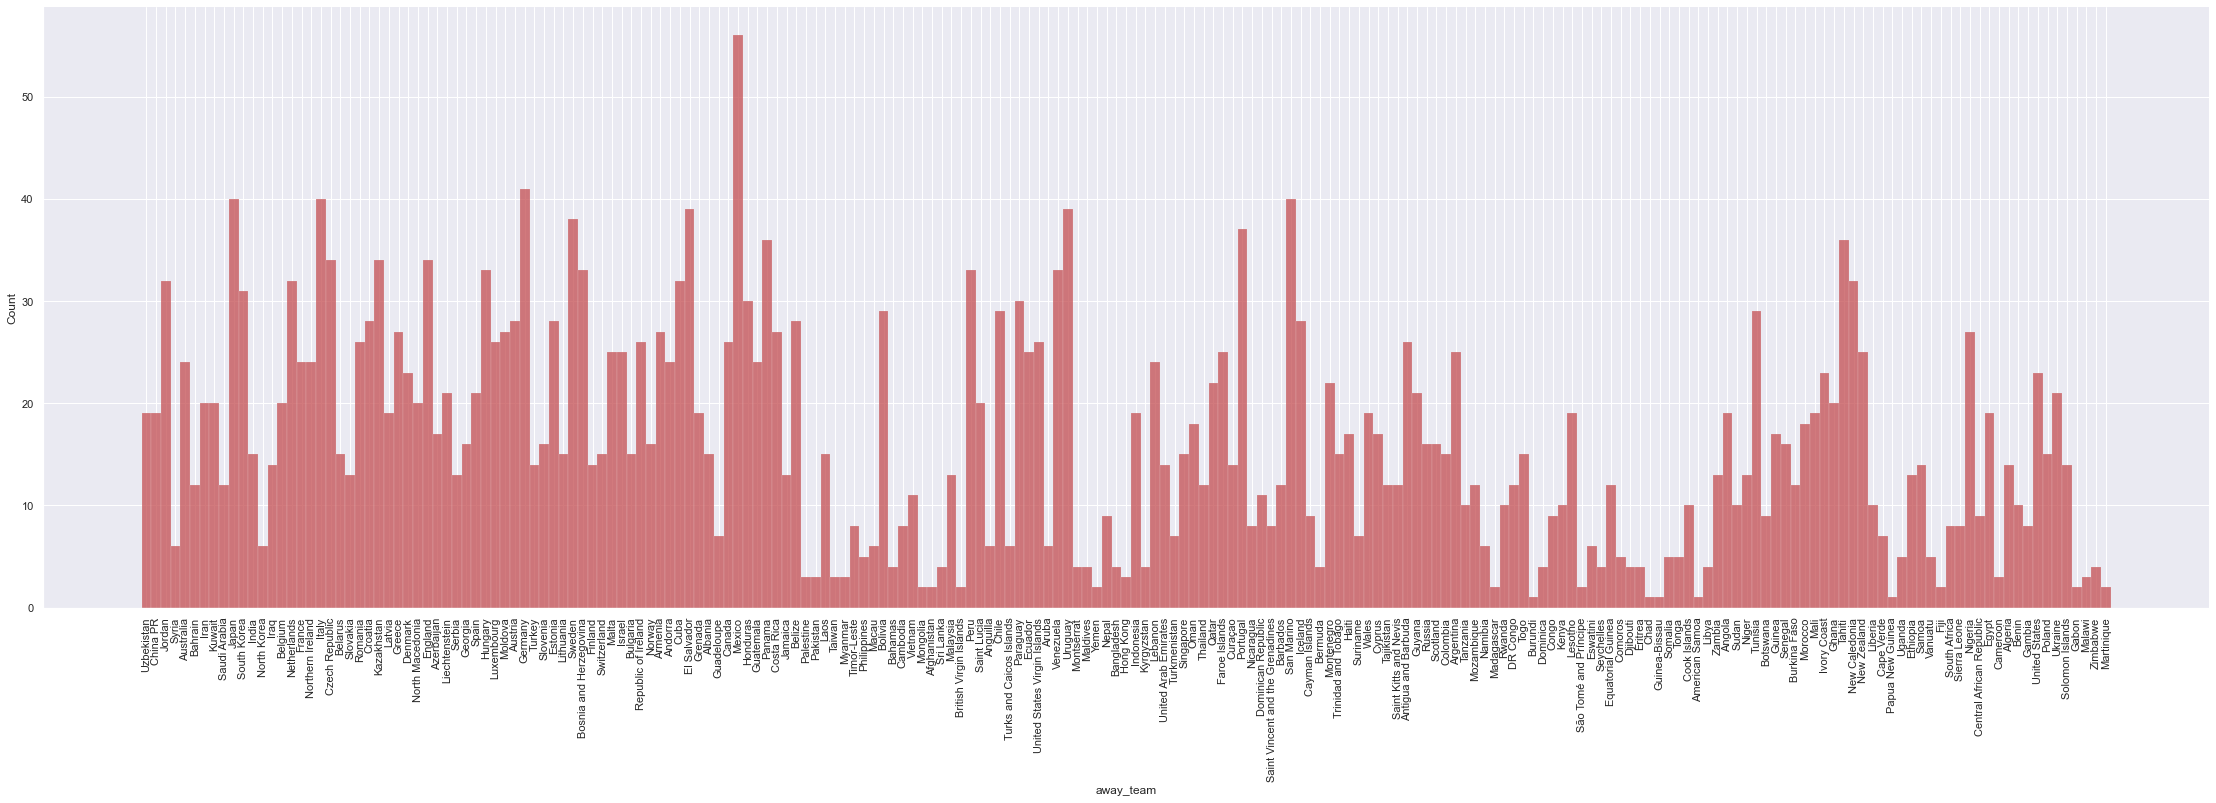

In [58]:
away_team = goalscorers[goalscorers['date'] <= '2013']
away_team = away_team[away_team['date'] >= '2011']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2011 to 2013; a period that includes events of great global impact, such as the Arab Spring, the death of Osama Bin Laden and the attack on the Boston Marathon.

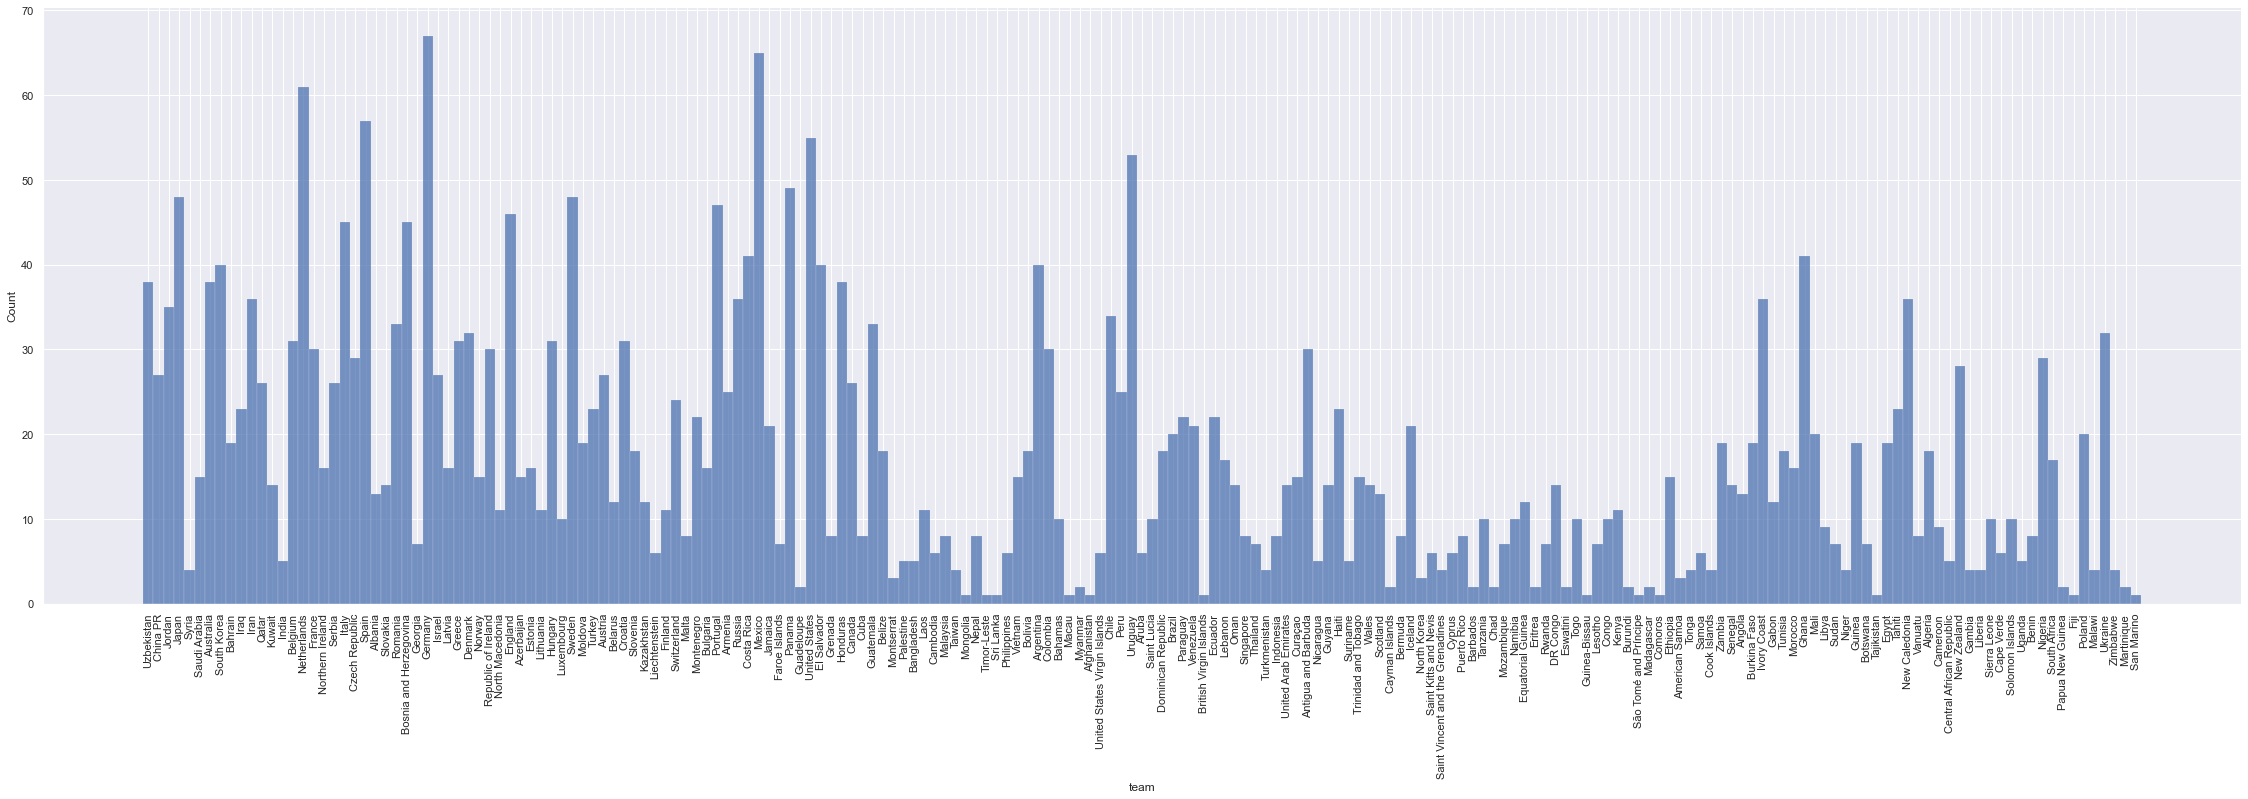

In [59]:
goal_dist = goalscorers[goalscorers['date'] <= '2013']
goal_dist = goal_dist[goal_dist['date'] >= '2011']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2014 to 2016**

Below we can see the most frequent home teams from 2014 to 2016; a period that includes events of great global impact, such as the Ebola virus epidemic, attacks in Paris and the Brexit referendum in the United Kingdom.

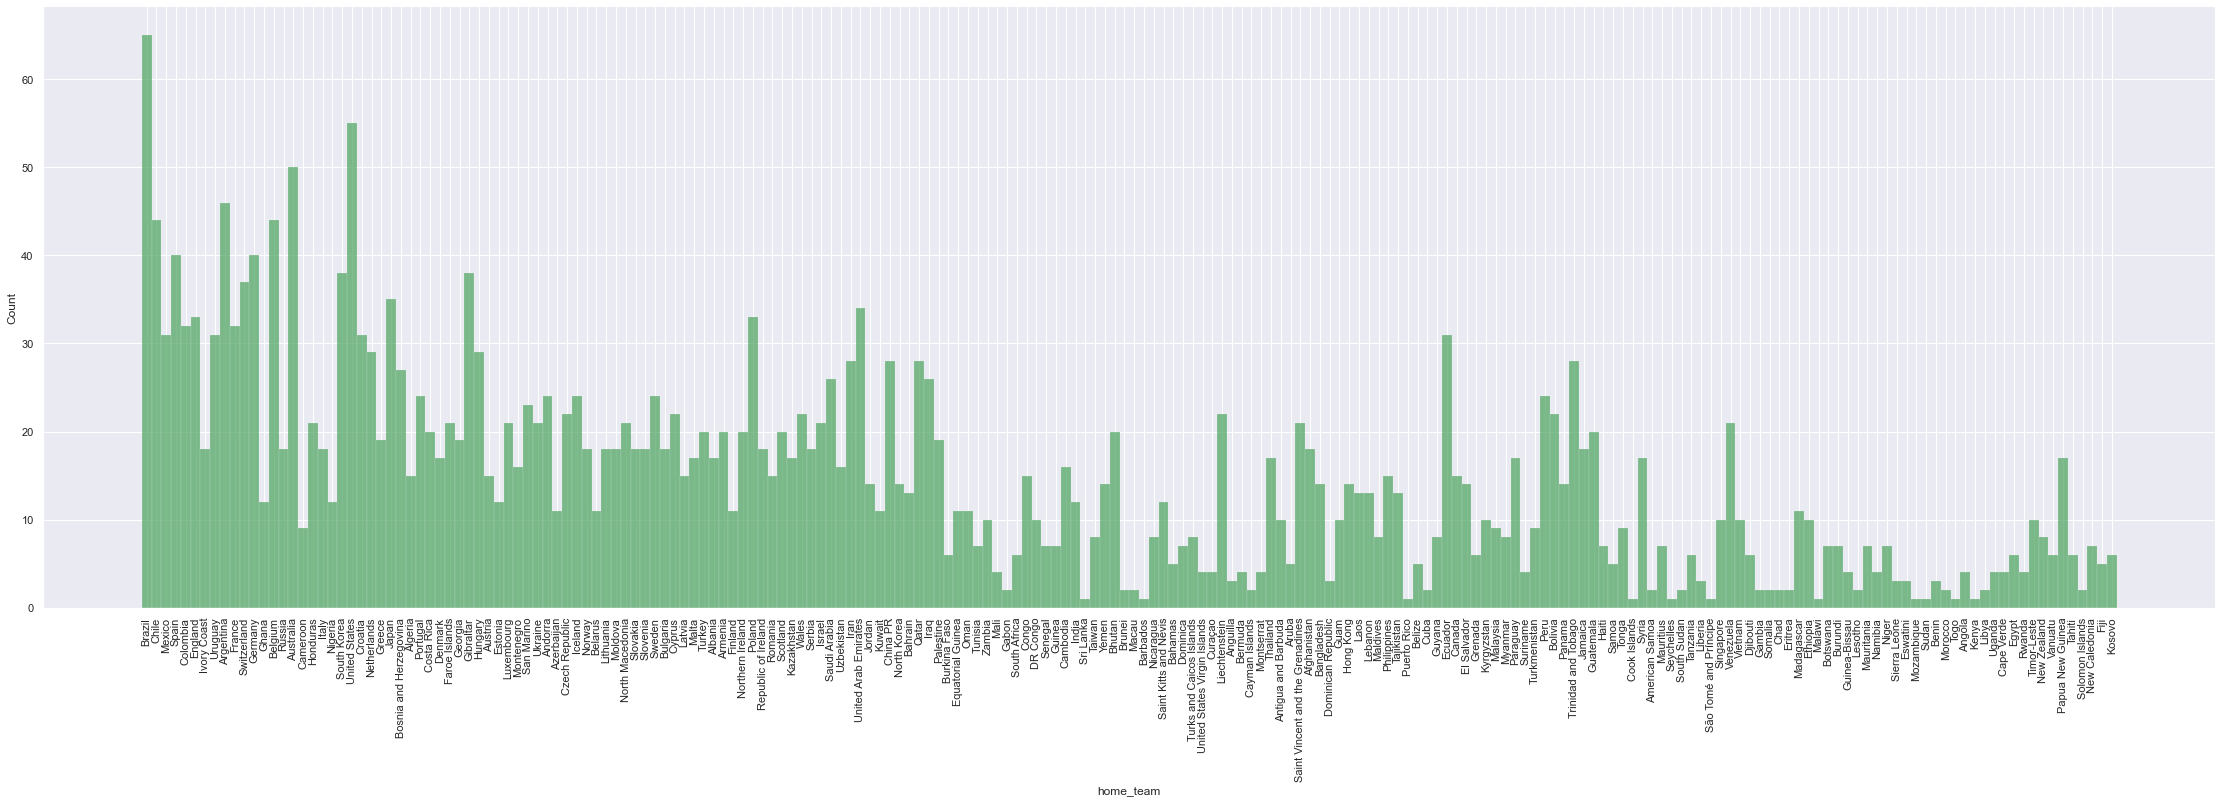

In [60]:
home_team = goalscorers[goalscorers['date'] <= '2016']
home_team = home_team[home_team['date'] >= '2014']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2014 to 2016; a period that includes events of great global impact, such as the Ebola virus epidemic, attacks in Paris and the Brexit referendum in the United Kingdom.

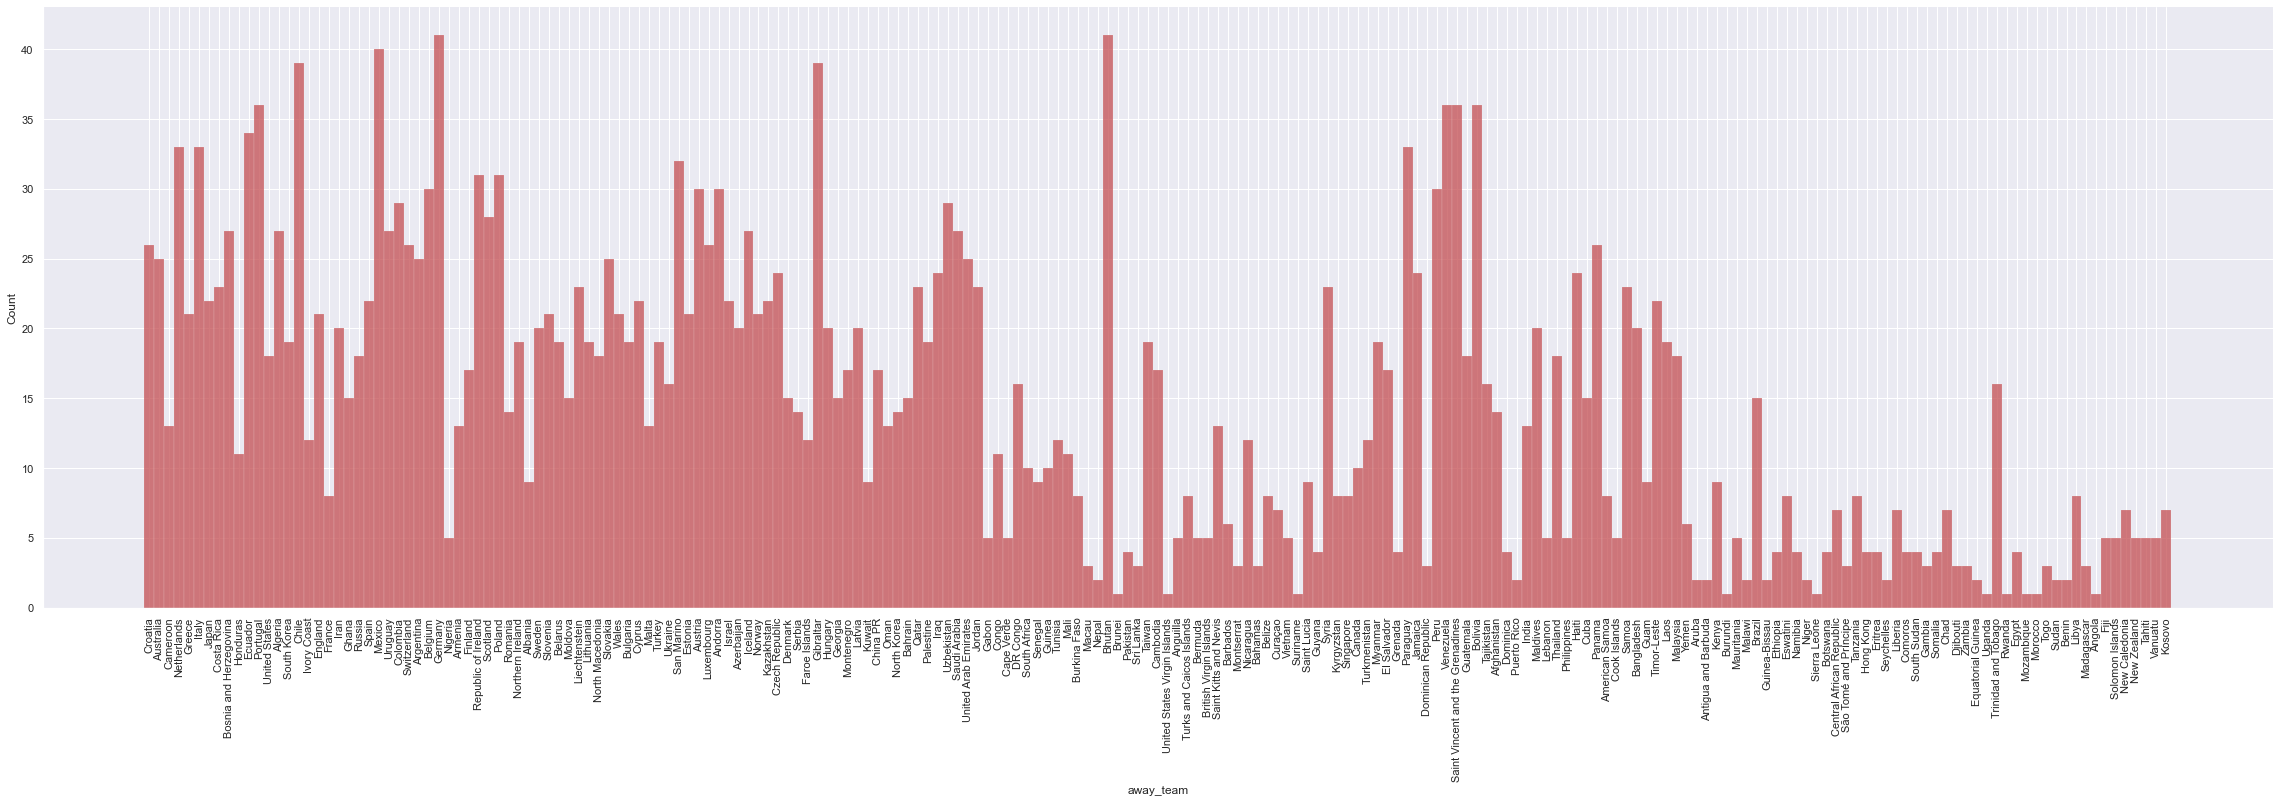

In [61]:
away_team = goalscorers[goalscorers['date'] <= '2016']
away_team = away_team[away_team['date'] >= '2014']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2014 to 2016; a period that includes events of great global impact, such as the Ebola virus epidemic, the attacks in Paris and the Brexit referendum in the United Kingdom.

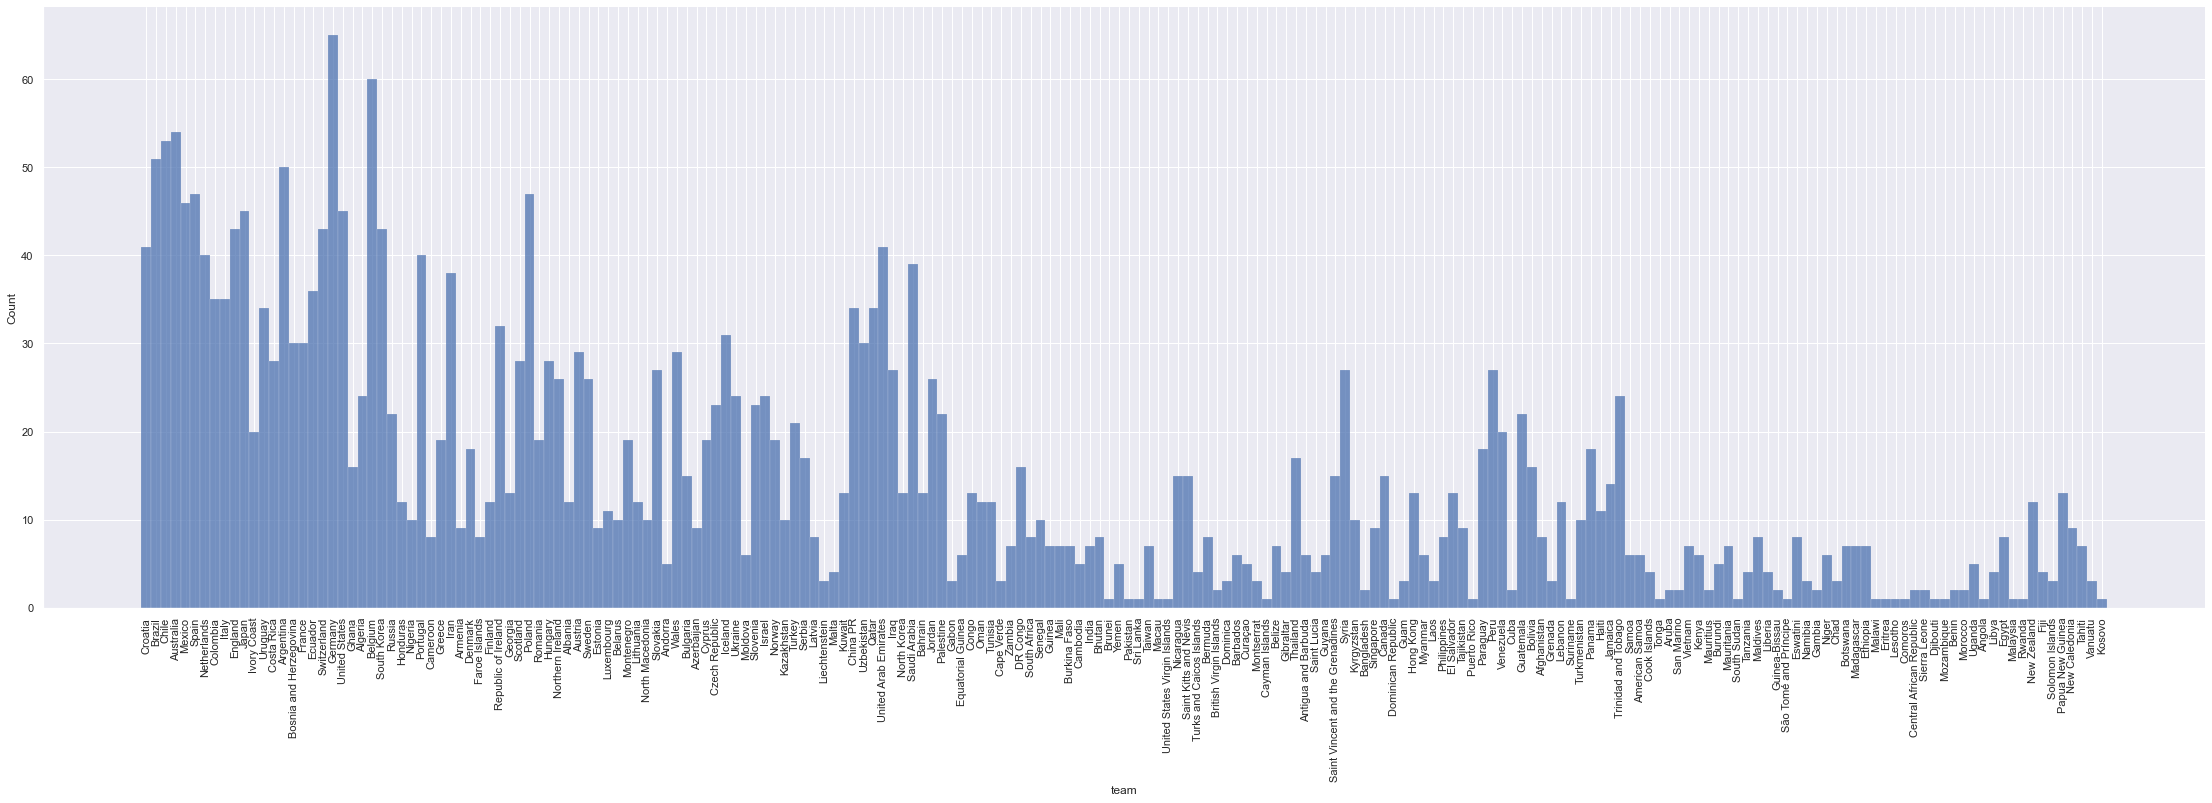

In [62]:
goal_dist = goalscorers[goalscorers['date'] <= '2016']
goal_dist = goal_dist[goal_dist['date'] >= '2014']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2018 to 2019**

Below we can see the most frequent home teams from 2018 to 2019; a period that includes events of great global impact, such as the protests in Hong Kong and the historic Summit between the United States and North Korea.

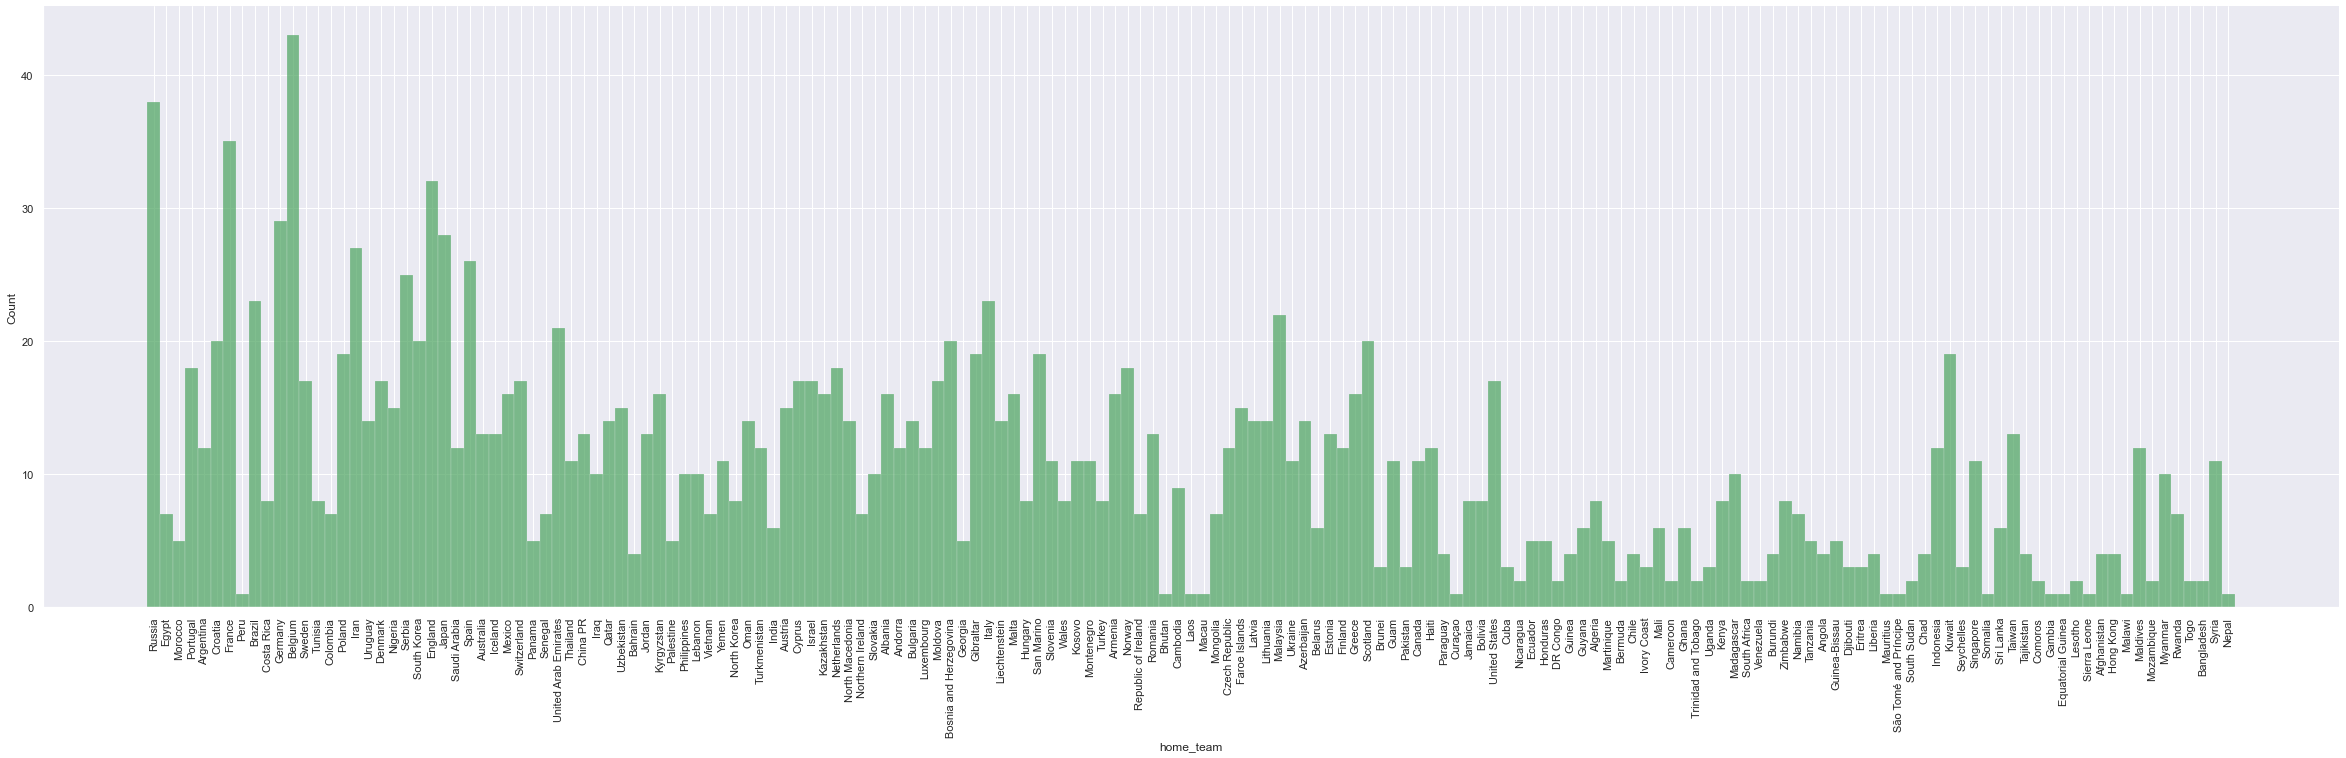

In [63]:
home_team = goalscorers[goalscorers['date'] <= '2019']
home_team = home_team[home_team['date'] >= '2018']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2018 to 2019; a period that includes events of great global impact, such as the protests in Hong Kong and the historic Summit between the United States and North Korea.

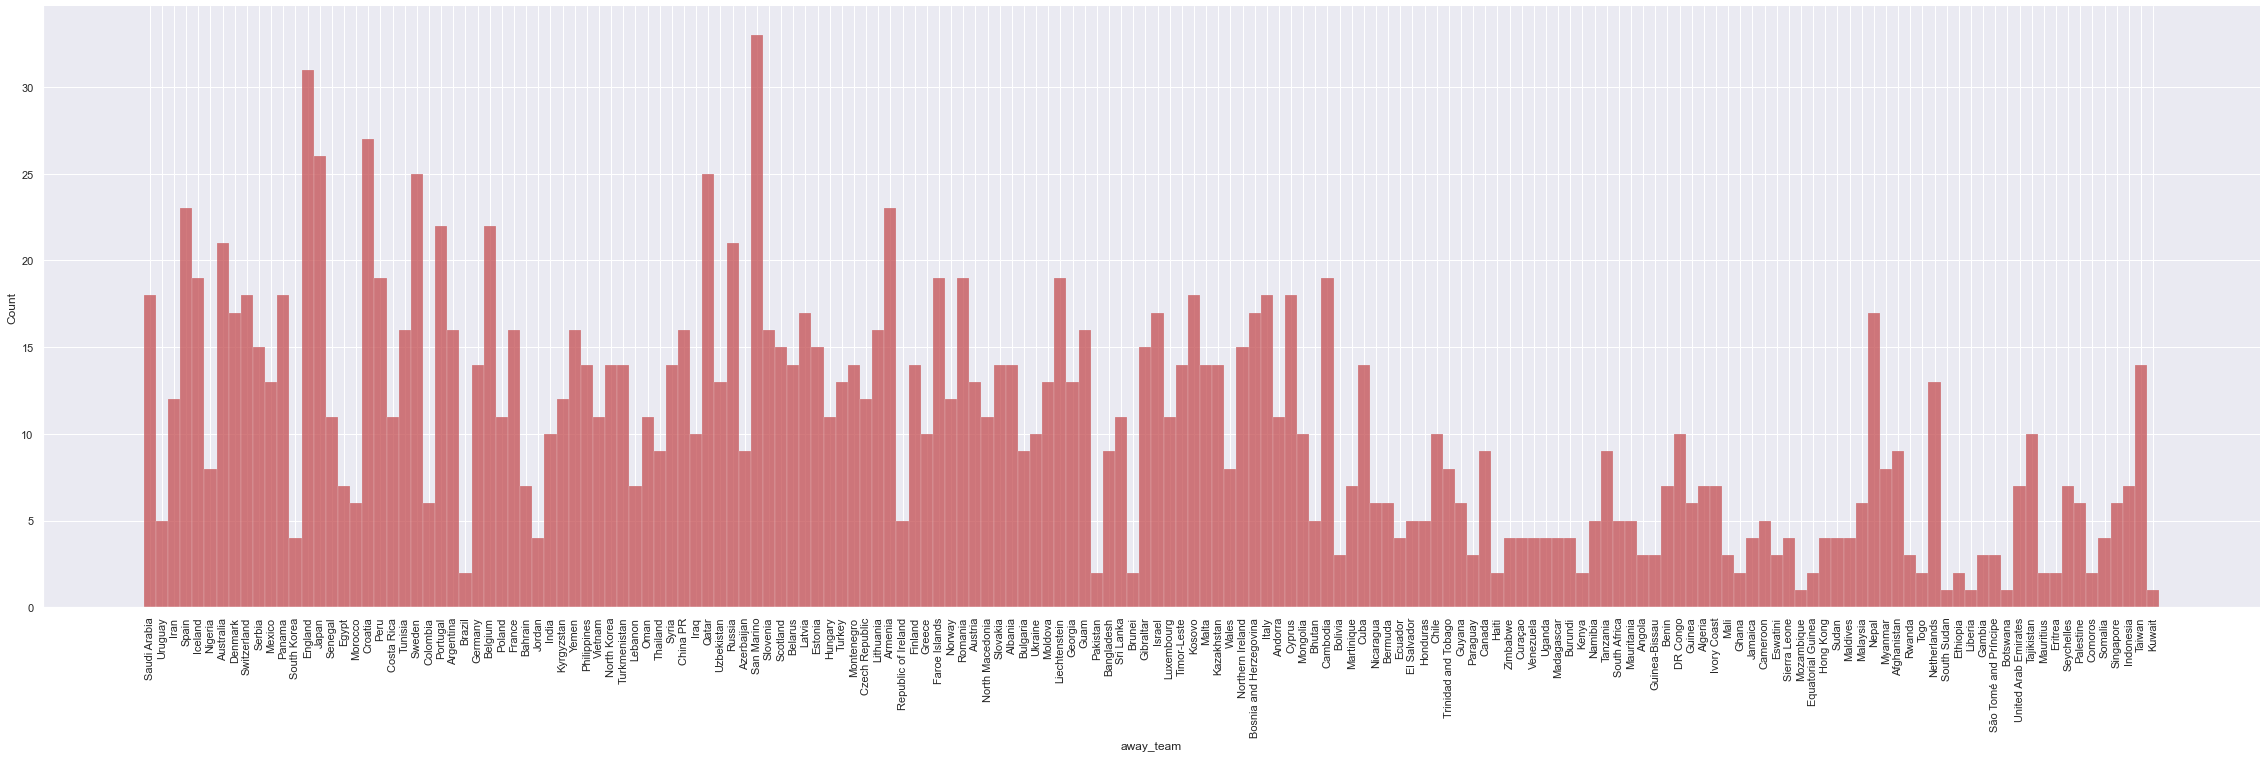

In [64]:
away_team = goalscorers[goalscorers['date'] <= '2019']
away_team = away_team[away_team['date'] >= '2018']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2018 to 2019; a period that includes events of great global impact, such as the protests in Hong Kong and the historic Summit between the United States and North Korea.

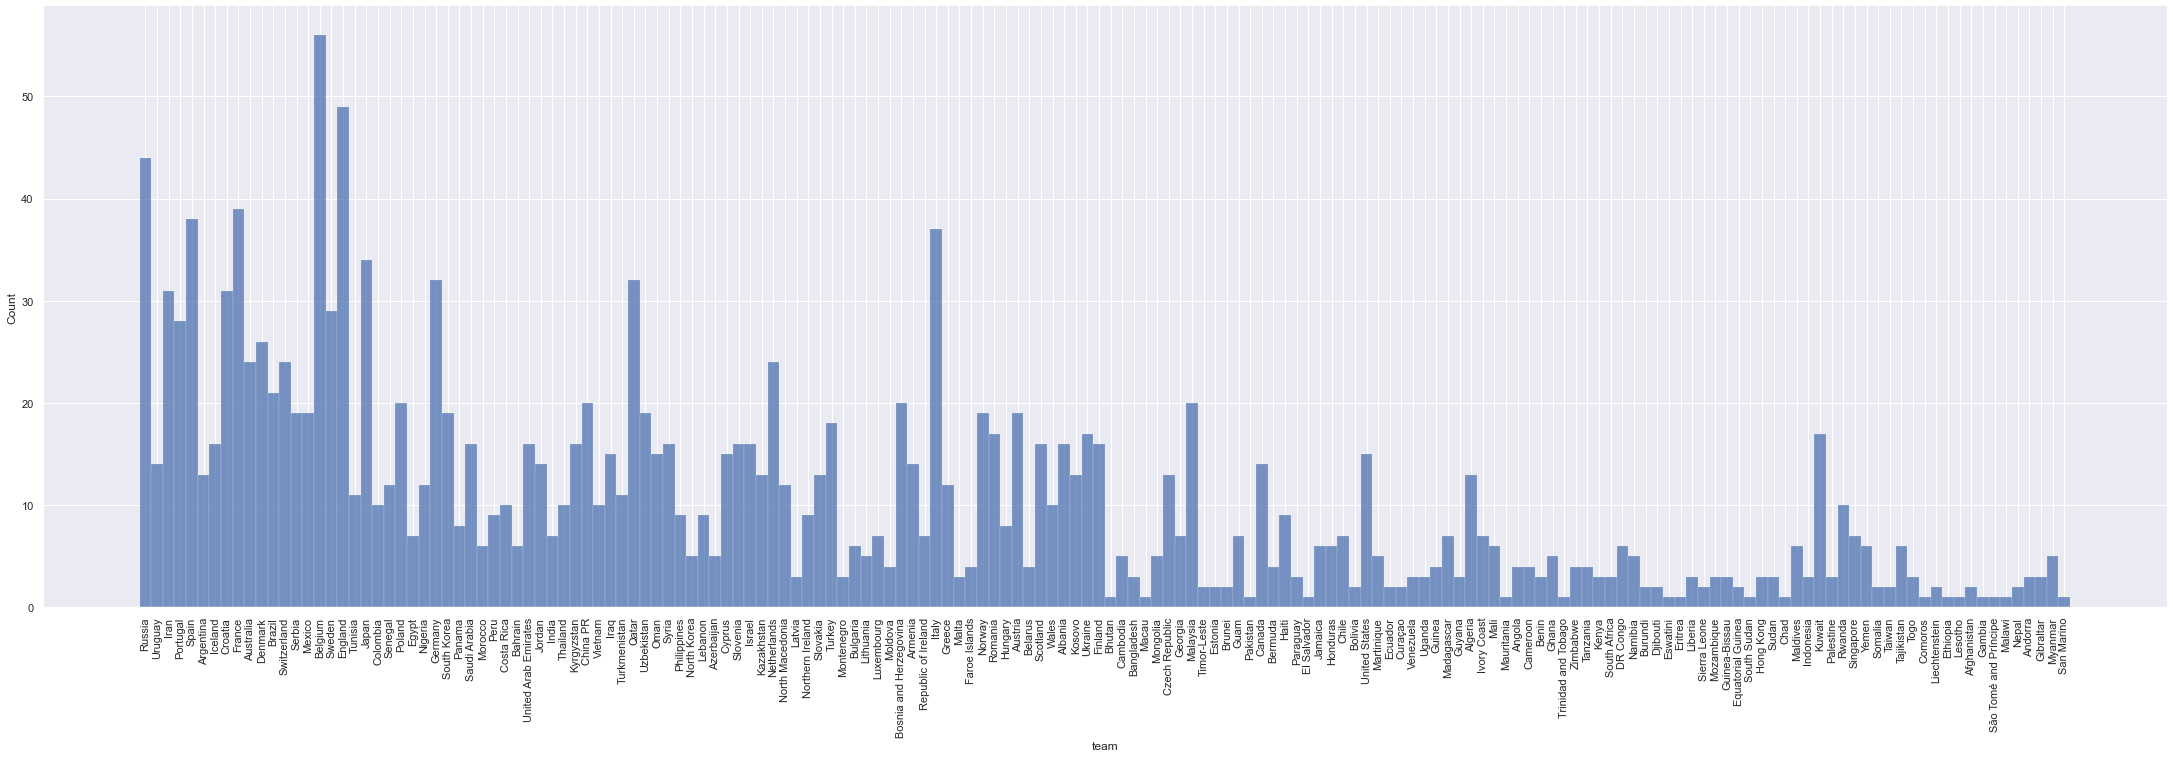

In [65]:
goal_dist = goalscorers[goalscorers['date'] <= '2019']
goal_dist = goal_dist[goal_dist['date'] >= '2018']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2020 to 2022**

Below we can see the most frequent home teams from 2020 to 2022; a period that includes events of great global impact, such as the COVID-19 pandemic, the Taliban seizure of power in Afghanistan and the Russia-Ukraine conflict.

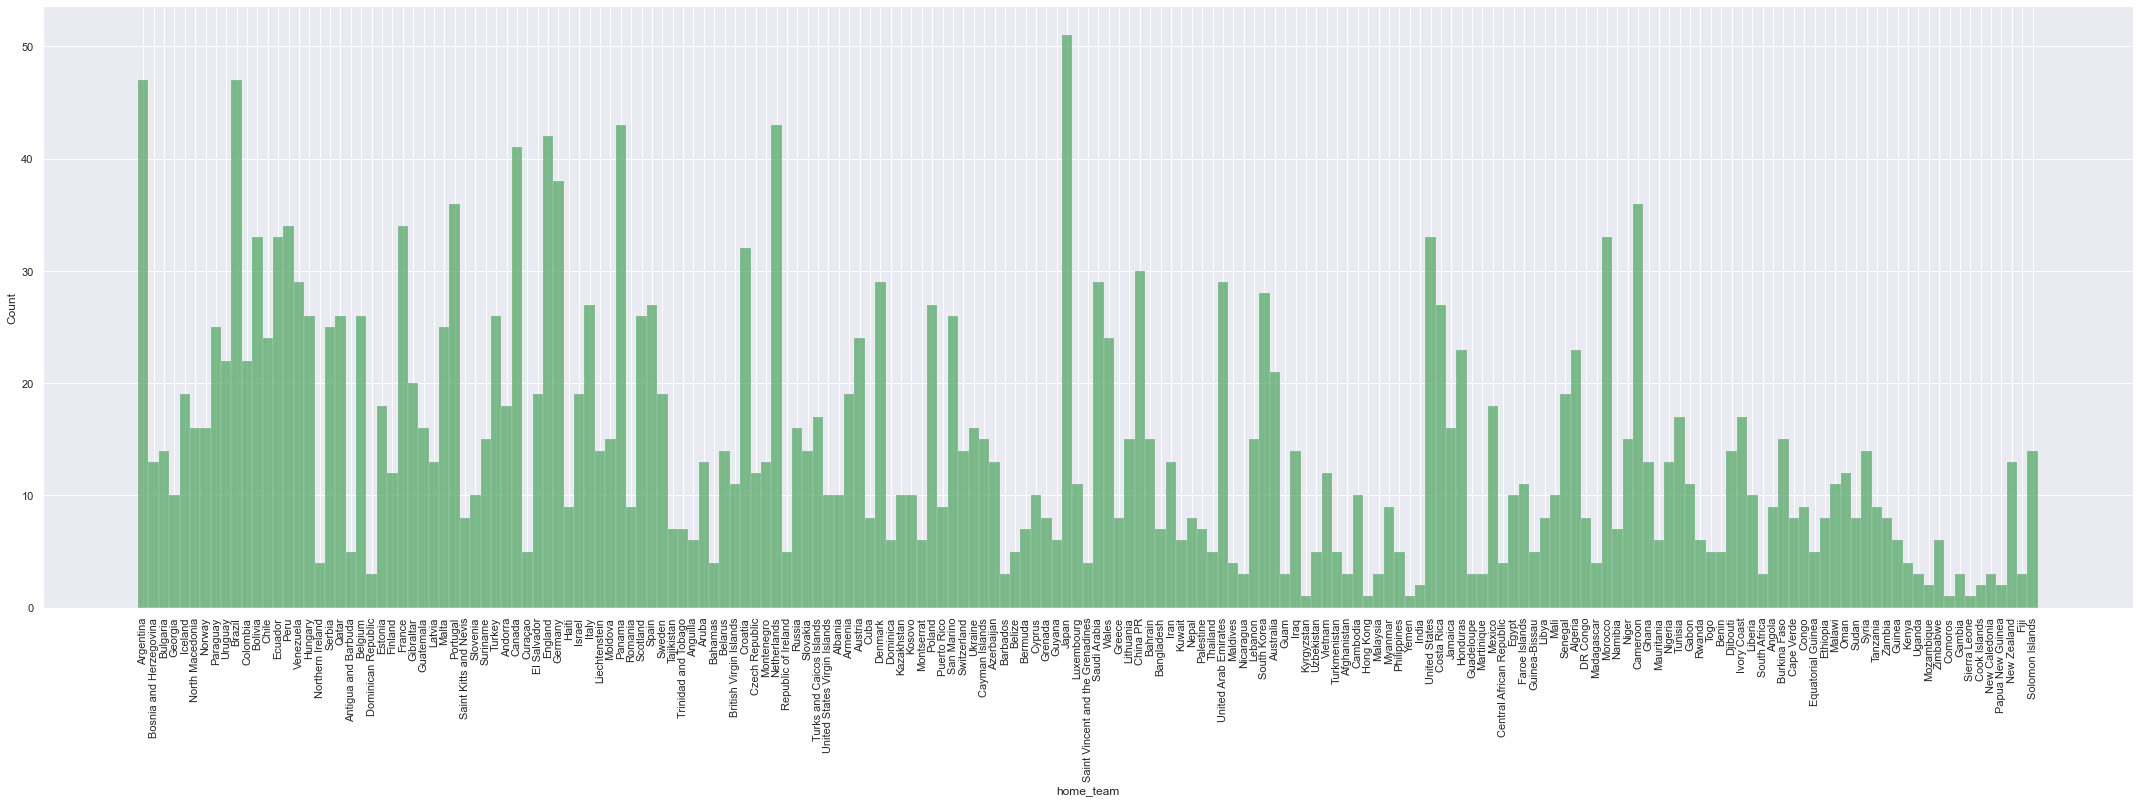

In [66]:
home_team = goalscorers[goalscorers['date'] <= '2022']
home_team = home_team[home_team['date'] >= '2020']

hist = sns.displot(data=home_team, x='home_team', color='g')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the most frequent away teams from 2020 to 2022; a period that includes events of great global impact, such as the COVID-19 pandemic, the Taliban seizure of power in Afghanistan and the Russia-Ukraine conflict.

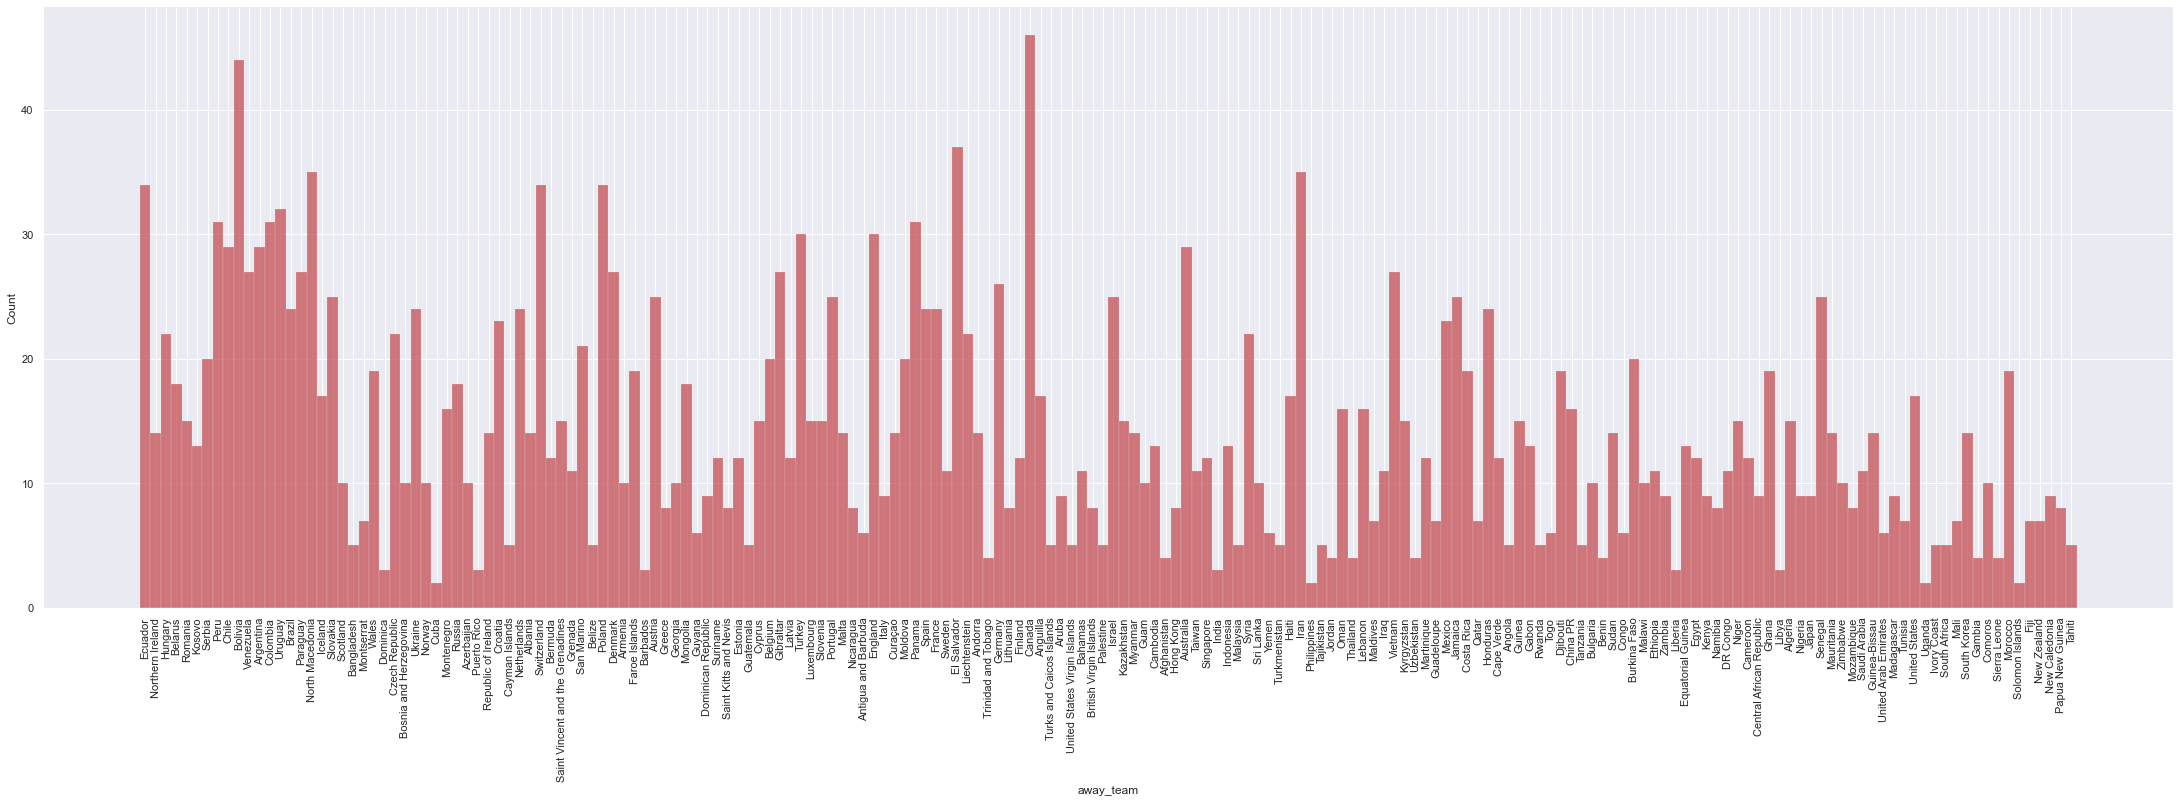

In [67]:
away_team = goalscorers[goalscorers['date'] <= '2022']
away_team = away_team[away_team['date'] >= '2020']

hist = sns.displot(data=away_team, x='away_team', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see the teams that scored the most goals from 2020 to 2022; a period that includes events of great global impact, such as the COVID-19 pandemic, the Taliban seizure of power in Afghanistan and the Russia-Ukraine conflict.

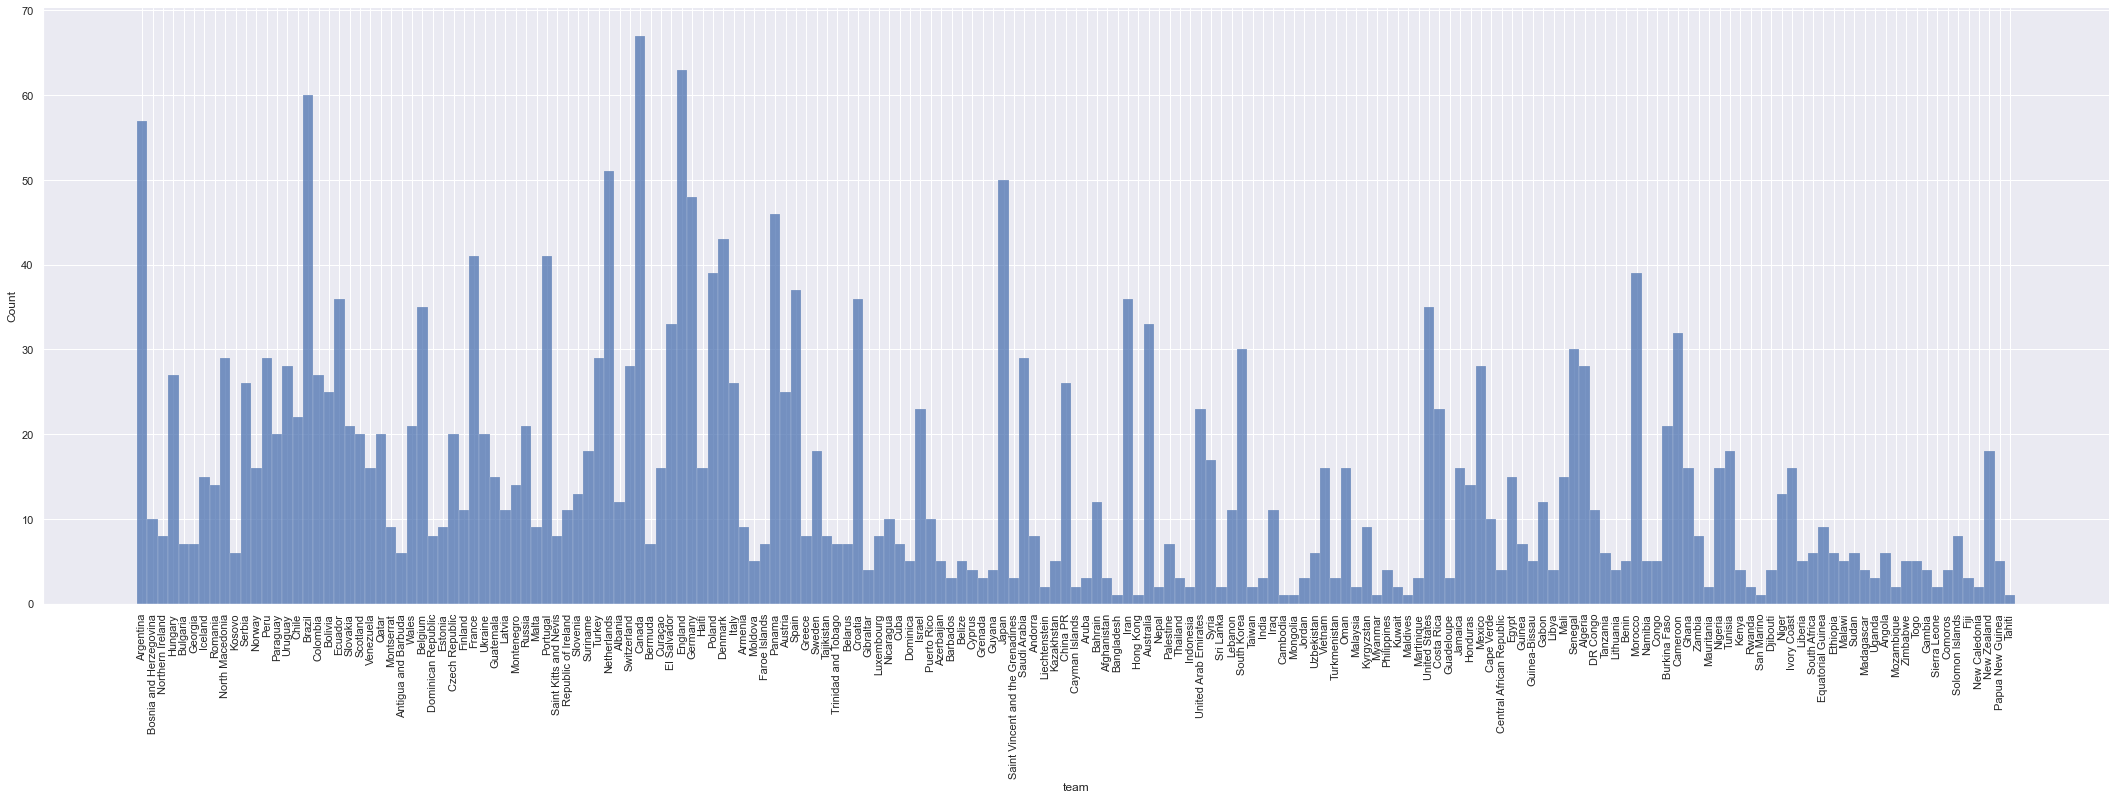

In [68]:
goal_dist = goalscorers[goalscorers['date'] <= '2022']
goal_dist = goal_dist[goal_dist['date'] >= '2020']

hist = sns.displot(data=goal_dist, x='team', color='b')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

## **Shootouts**

In [69]:
shootouts['date'] = pd.to_datetime(shootouts['date'])
shootouts['date'] = shootouts['date'].dt.strftime('%Y')
shootouts

date    home_team         away_team       winner
0    1967        India            Taiwan       Taiwan
1    1971  South Korea  Vietnam Republic  South Korea
2    1972  South Korea              Iraq         Iraq
3    1972     Thailand       South Korea  South Korea
4    1972     Thailand          Cambodia     Thailand
..    ...          ...               ...          ...
542  2022        Japan           Croatia      Croatia
543  2022      Morocco             Spain      Morocco
544  2022      Croatia            Brazil      Croatia
545  2022  Netherlands         Argentina    Argentina
546  2022    Argentina            France    Argentina

[547 rows x 4 columns]

### **Analysis of Frequencies by Years comprising World Events**

#### **From 1947 to 1991**

Below we can see the frequency of teams that won on penalties between the years 1947 to 1991, a period that became known as the “Cold War”.

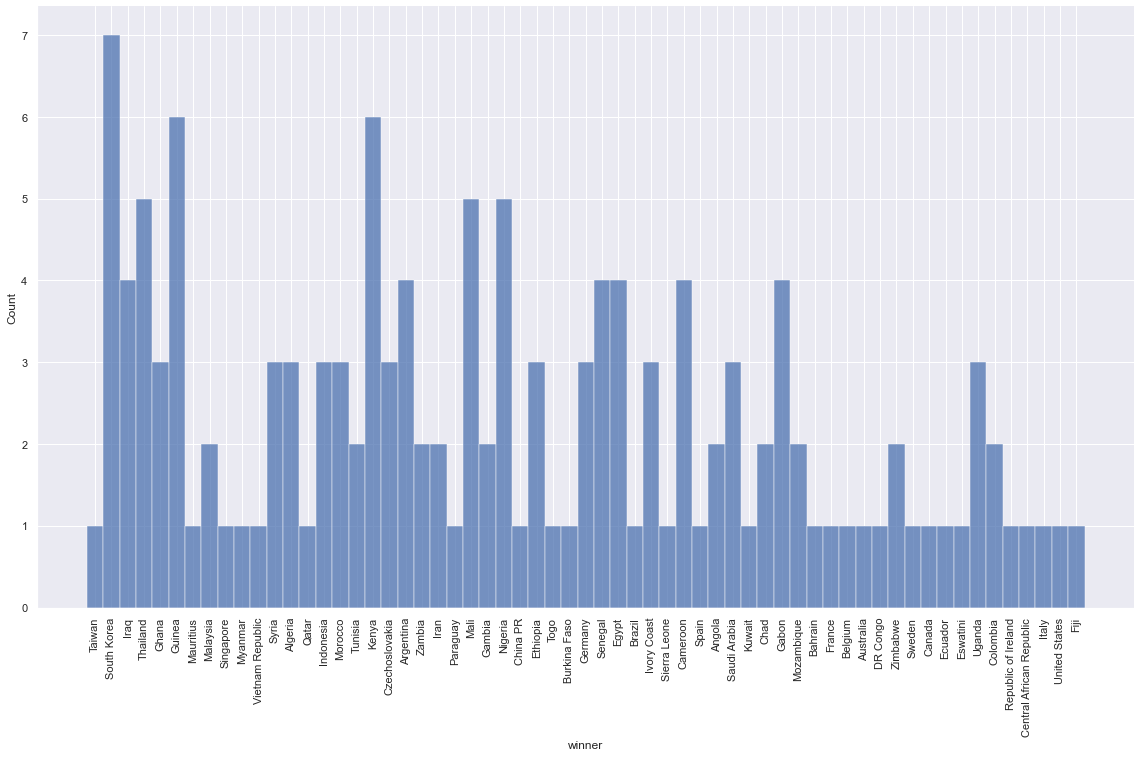

In [70]:
penaltis_win_freq = shootouts[shootouts['date'] <= '1991']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] > '1947']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.figure.set_size_inches(20,10)
hist.set_xticklabels(rotation=90)

#### **From 1992 to 1993**

Below we can see the teams that won the most in penalties between the years 1992 to 1993; period in which the Maastricht Treaty was signed with the institution of the European Union.

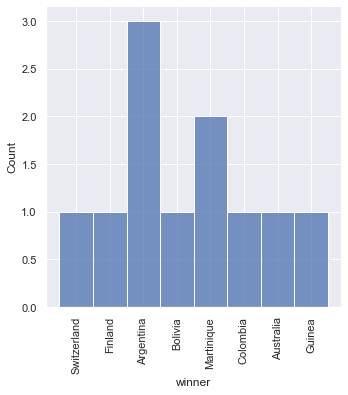

In [71]:
penaltis_win_freq = shootouts[shootouts['date'] <= '1993']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] > '1992']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.set_xticklabels(rotation=90)

#### **From 1994 to 1999**

Below we can see the teams that won the most in penalties between the years 1994 to 1999; a period that includes major world events of impact, such as the Genocide in Rwanda, the Attack on Oklahoma City, the Asian financial crisis and the Kosovo War.

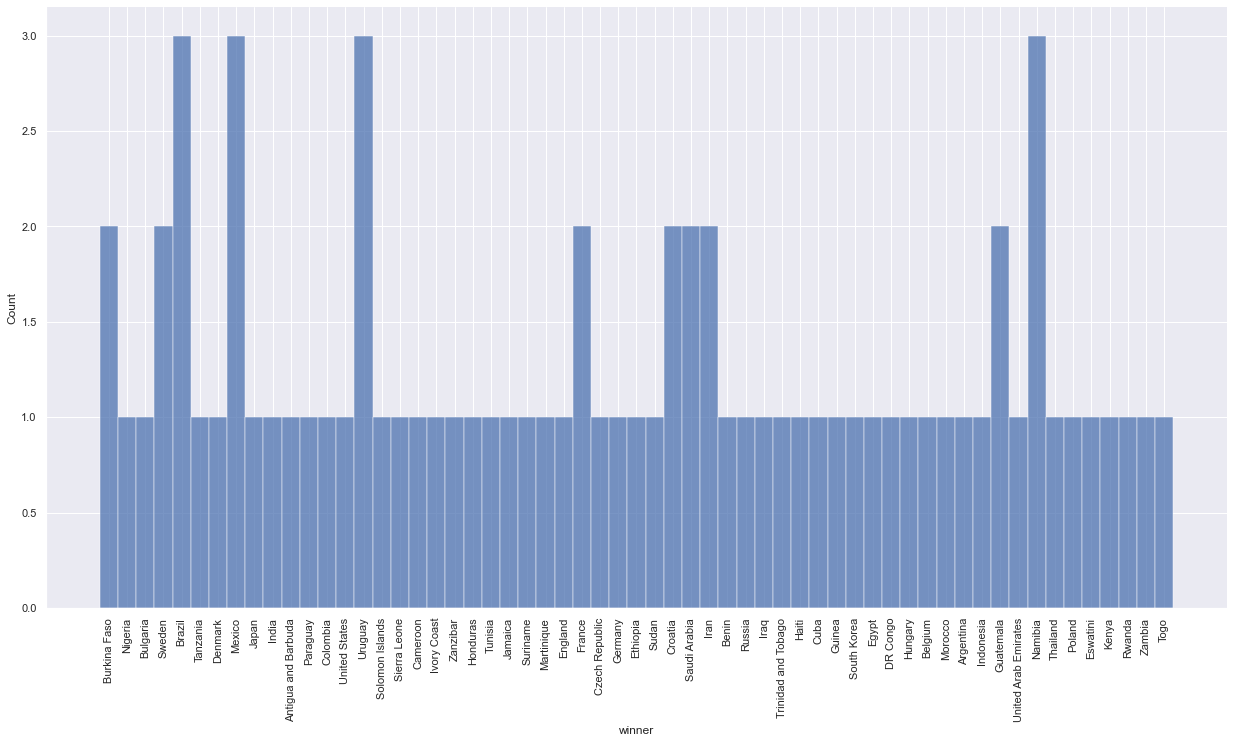

In [72]:
penaltis_win_freq = shootouts[shootouts['date'] <= '1999']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '1994']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.figure.set_size_inches(20,10)
hist.set_xticklabels(rotation=90)

#### **From 2000 to 2003**

Below we can see the teams that won the most in penalties between the years 2000 to 2003; a period that includes major world events of impact, such as the turn of the millennium, the September 11 attacks, the wars in Afghanistan and Iraq, among others.

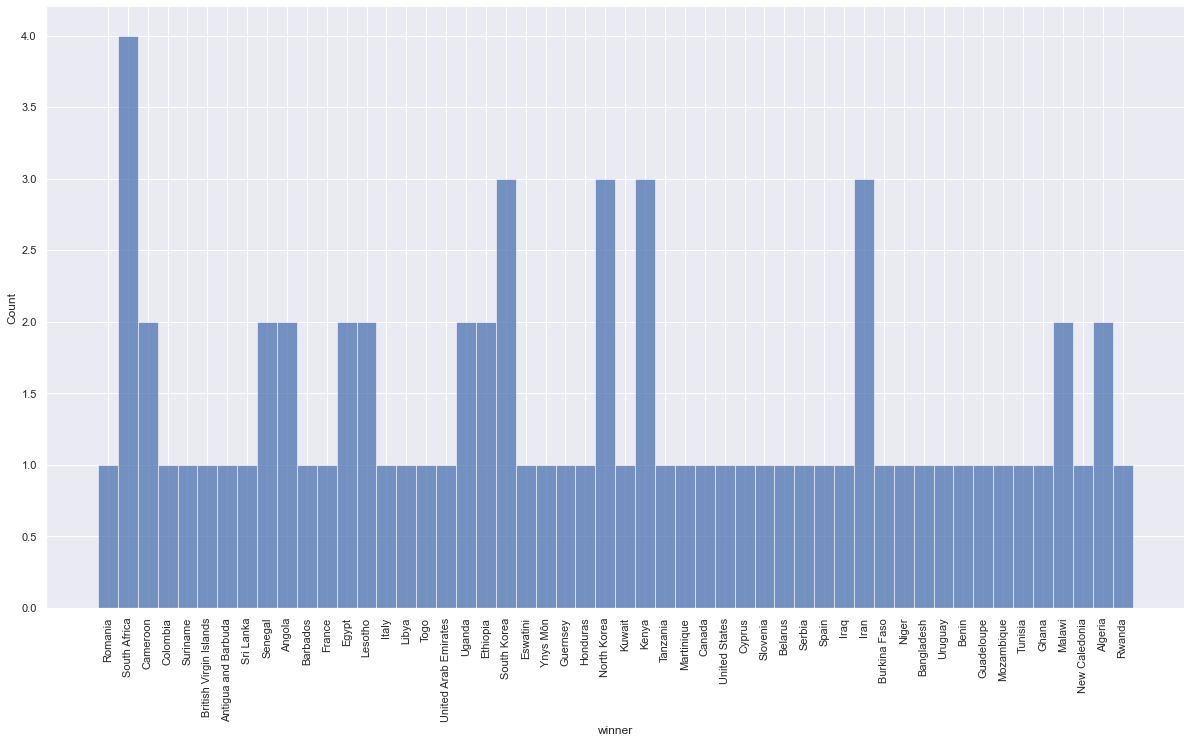

In [73]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2003']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '2000']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.figure.set_size_inches(20,10)
hist.set_xticklabels(rotation=90)

#### **From 2004 to 2005**

Below we can see the teams that won the most in penalties between the years 2004 to 2005; a period that includes major world events of impact, such as the attacks in Madrid and London.

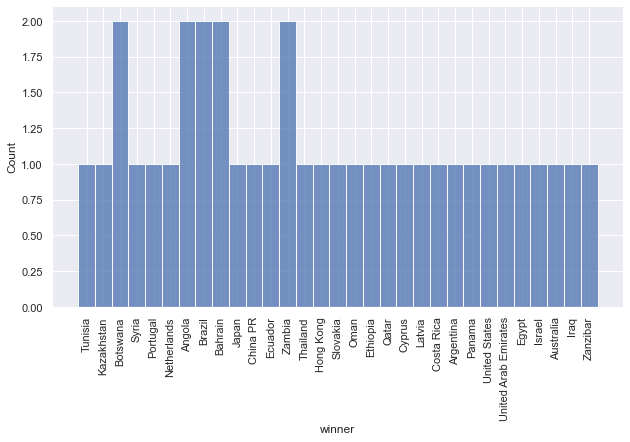

In [74]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2005']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '2004']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.figure.set_size_inches(10,5)
hist.set_xticklabels(rotation=90)

#### **From 2006 to 2007**

Below we can see the teams that won the most in penalties between the years 2006 to 2007; a period that includes major world events of impact, such as the publication of Muhammad's cartoons in a Danish newspaper and the release by the UN of a report indicating that human activities are responsible for climate change.

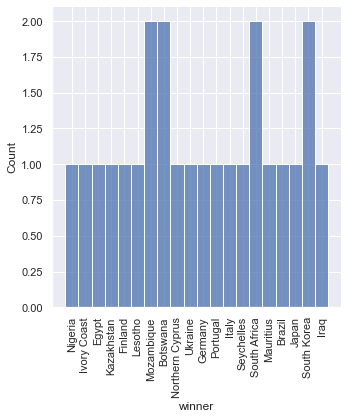

In [75]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2007']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '2006']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.set_xticklabels(rotation=90)

#### **From 2007 to 2008**

Below we can see the teams that won the most in penalties between the years 2007 to 2008; a period that includes events of great global impact, such as the global economic crisis.

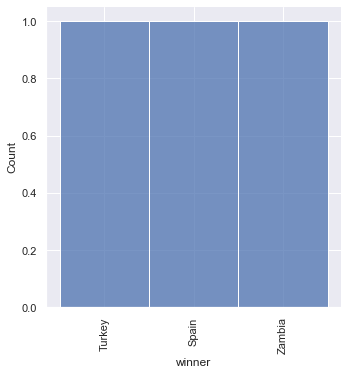

In [76]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2008']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] > '2007']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.set_xticklabels(rotation=90)

#### **From 2009 to 2010**

Below we can see the teams that won the most in penalties between the years 2009 to 2010; a period that includes events of great global impact, such as the United Nations Conference on Climate Change in 2009 and the 2010 earthquake in Haiti.

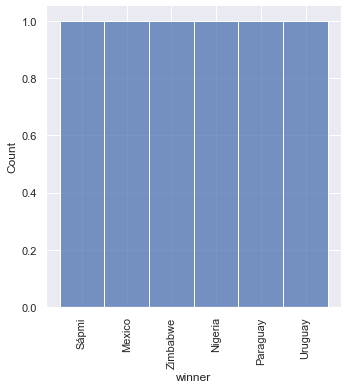

In [77]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2010']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '2009']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.set_xticklabels(rotation=90)

#### **From 2011 to 2013**

Below we can see the teams that won the most in penalties between the years 2011 to 2013; a period that includes events of great global impact, such as the Arab Spring, the death of Osama Bin Laden and the attack on the Boston Marathon.

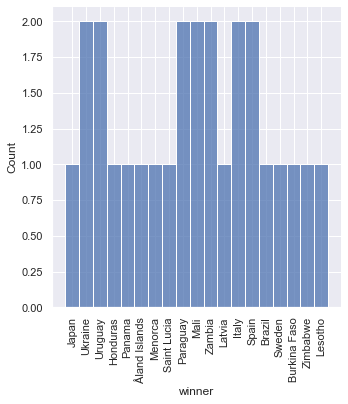

In [78]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2013']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '2011']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.set_xticklabels(rotation=90)

#### **From 2014 to 2016**

Below we can see the teams that won the most in penalties between the years 2014 to 2016; a period that includes events of great global impact, such as the Ebola virus epidemic, the attacks in Paris and the Brexit referendum in the United Kingdom.

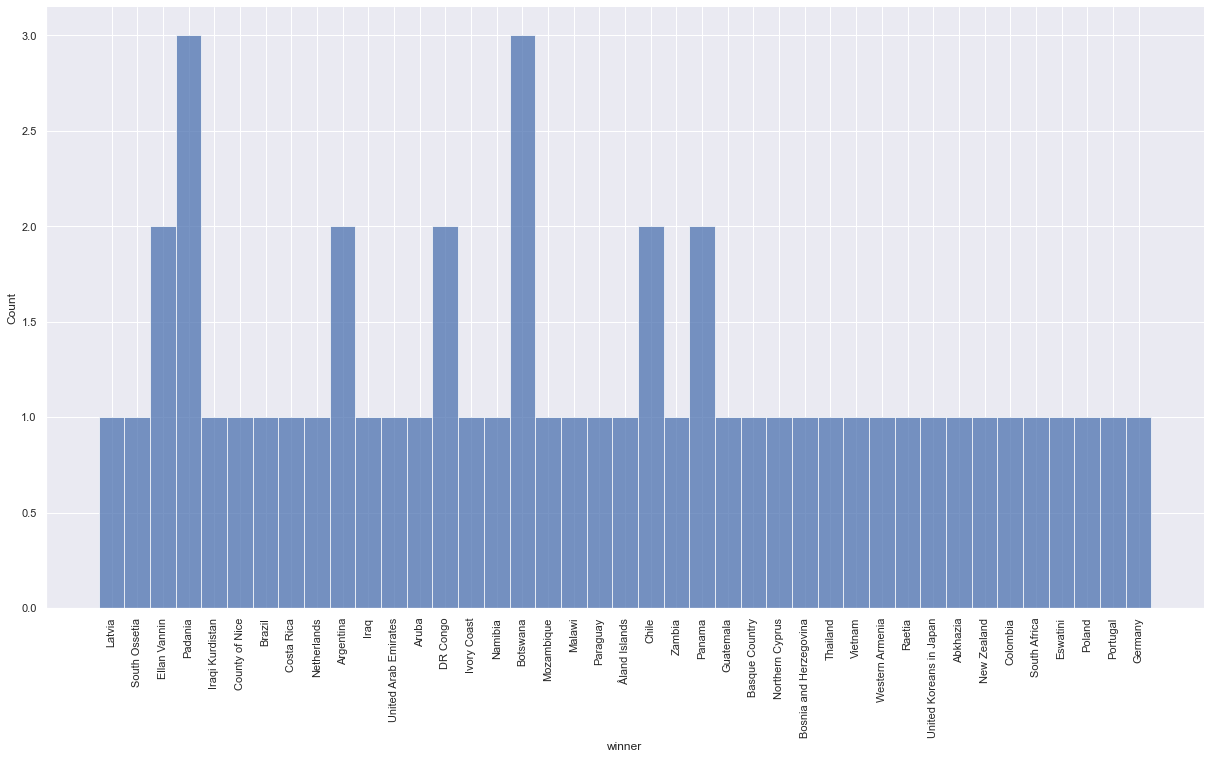

In [79]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2016']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '2014']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.figure.set_size_inches(20,10)
hist.set_xticklabels(rotation=90)

#### **From 2018 to 2019**

Below we can see the teams that won the most on penalties between the years 2018 to 2019; a period that includes events of great global impact, such as the protests in Hong Kong and the historic Summit between the United States and North Korea.

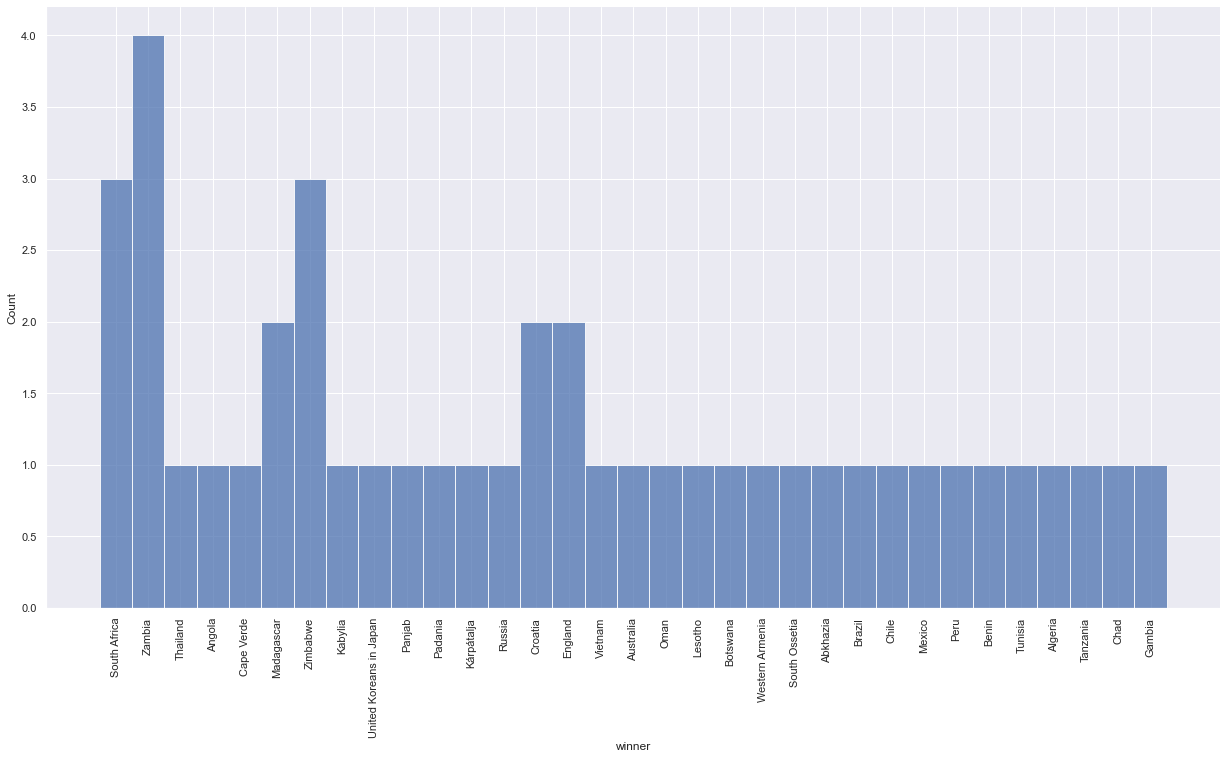

In [80]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2019']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '2018']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.figure.set_size_inches(20,10)
hist.set_xticklabels(rotation=90)

#### **From 2020 to 2022**

Below we can see the teams that won the most on penalties between the years 2020 to 2022; a period that includes events of great global impact, such as the COVID-19 pandemic, the Taliban seizure of power in Afghanistan and the Russia-Ukraine conflict.

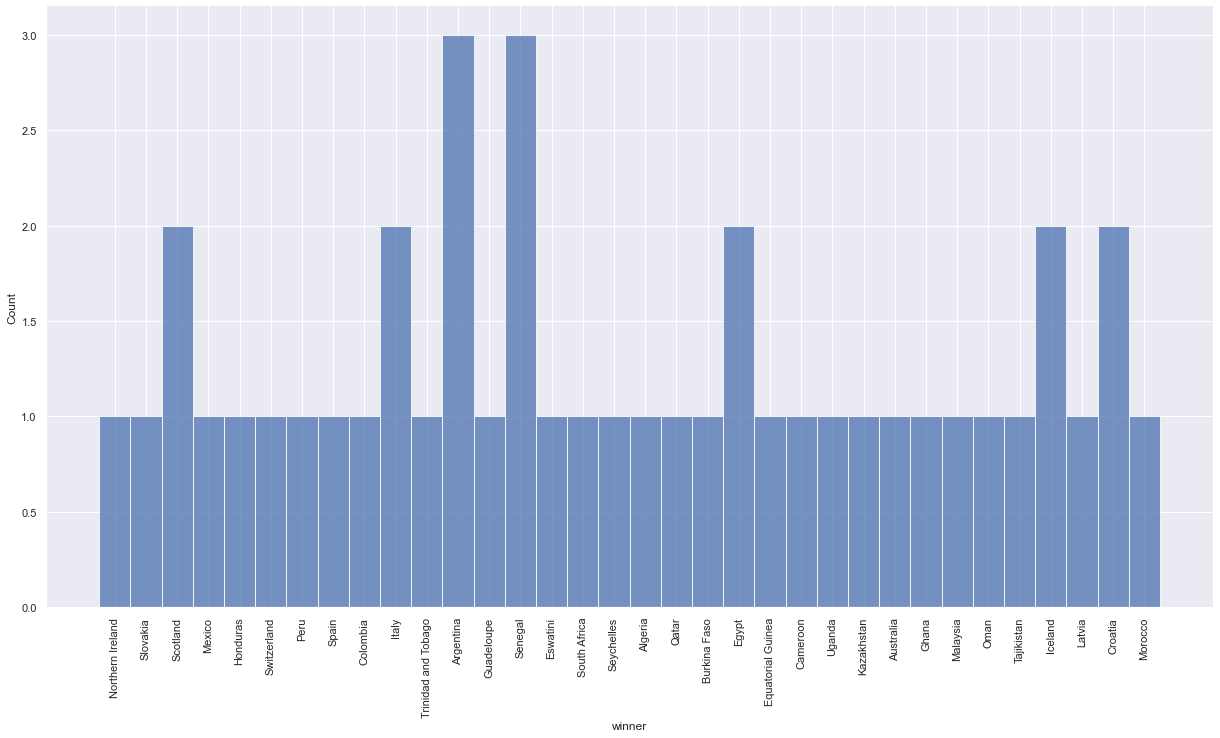

In [81]:
penaltis_win_freq = shootouts[shootouts['date'] <= '2022']
penaltis_win_freq = penaltis_win_freq[penaltis_win_freq['date'] >= '2020']

hist = sns.displot(data=penaltis_win_freq, x='winner', color='b')
hist.figure.set_size_inches(20,10)
hist.set_xticklabels(rotation=90)

## **Results** 

In [82]:
results['date'] = pd.to_datetime(results['date'])
results['date'] = results['date'].dt.strftime('%Y')
results

date                     home_team                 away_team  \
0      1872                      Scotland                   England   
1      1873                       England                  Scotland   
2      1874                      Scotland                   England   
3      1875                       England                  Scotland   
4      1876                      Scotland                   England   
...     ...                           ...                       ...   
44552  2023                         Haiti                   Bermuda   
44553  2023                        Guyana                Montserrat   
44554  2023                       Bonaire  Turks and Caicos Islands   
44555  2023  United States Virgin Islands              Sint Maarten   
44556  2023                        Rwanda                     Benin   

       home_score  away_score                            tournament  \
0               0           0                              Friendly   
1               4           2                              Friendly   
2               2           1                              Friendly   
3               2           2                              Friendly   
4               3           0                              Friendly   
...           ...         ...                                   ...   
44552           3           1               CONCACAF Nations League   
44553           0           0               CONCACAF Nations League   
44554           1           2               CONCACAF Nations League   
44555           1           2               CONCACAF Nations League   
44556           1           1  African Cup of Nations qualification   

                city                       country  neutral  goal_dif  \
0            Glasgow                      Scotland    False         0   
1             London                       England    False         2   
2            Glasgow                      Scotland    False         1   
3             London                       England    False         0   
4            Glasgow                      Scotland    False         3   
...              ...                           ...      ...       ...   
44552  San Cristóbal            Dominican Republic     True         2   
44553     Bridgetown                      Barbados     True         0   
44554         Rincon                       Bonaire    False        -1   
44555    Saint Croix  United States Virgin Islands    False        -1   
44556         Kigali                        Rwanda    False         0   

       total_goals  year  
0                0  1872  
1                6  1873  
2                3  1874  
3                4  1875  
4                3  1876  
...            ...   ...  
44552            4  2023  
44553            0  2023  
44554            3  2023  
44555            3  2023  
44556            2  2023  

[44557 rows x 12 columns]

### **Analysis of Frequencies by Years comprising World Events**

#### **Until 1918**

Below we can see the frequency of the countries that hosted the most games until 1918 (end of World War I)

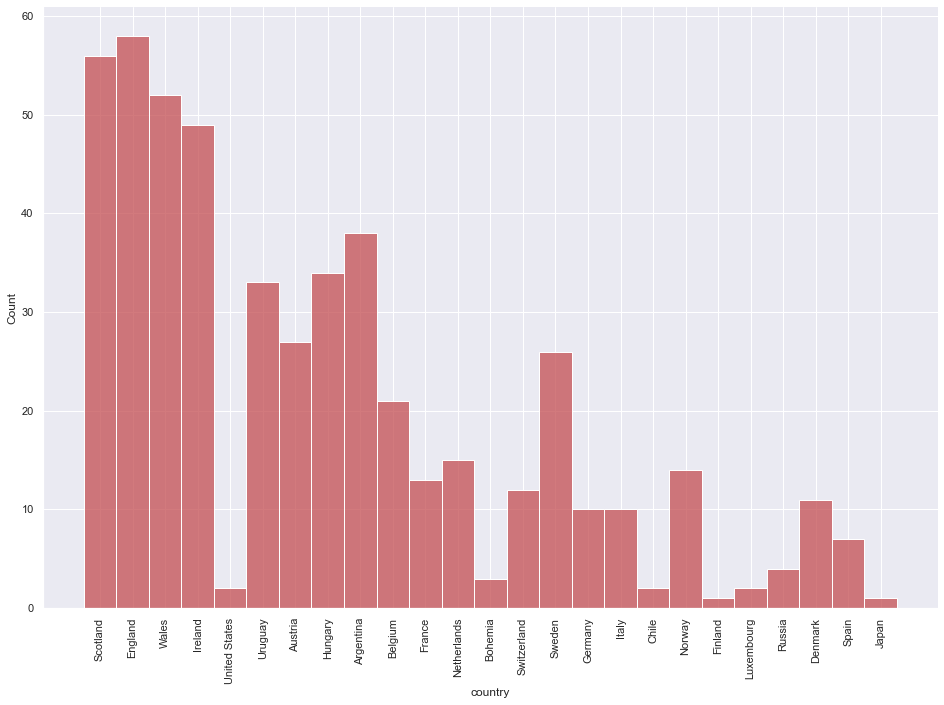

In [83]:
freq_country = results[results['date'] <= '1918']
hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(15,10)
hist.set_xticklabels(rotation=90)

#### **From 1918 to 1939**

Below we can see the countries that hosted the most games from 1918 to 1939, where this period is known as the "interwar period".

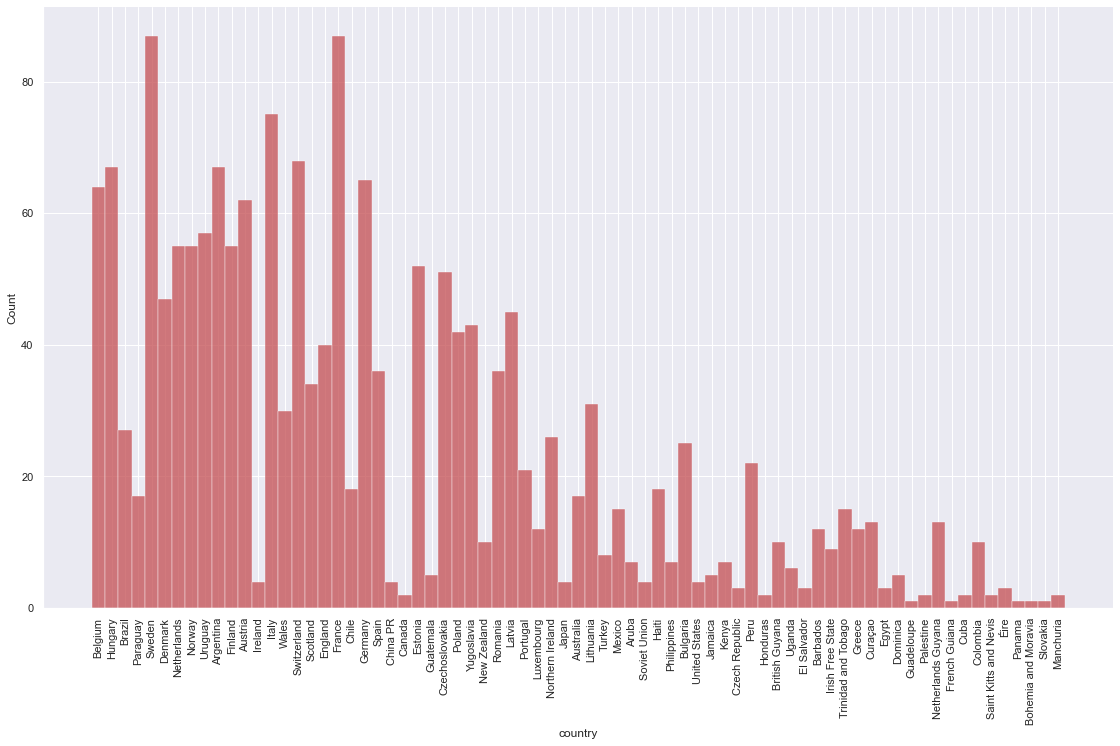

In [84]:
freq_country = results[results['date'] <= '1939']
freq_country = freq_country[freq_country['date'] > '1918']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(20,10)
hist.set_xticklabels(rotation=90)

#### **From 1939 to 1945**

Below we can see the countries that hosted the most games between the years 1939 to 1945 (World War II).

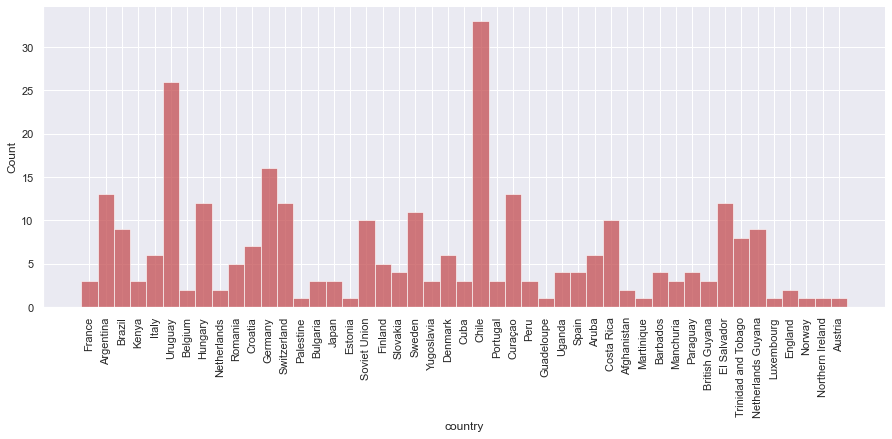

In [85]:
freq_country = results[results['date'] <= '1945']
freq_country = freq_country[freq_country['date'] > '1939']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(15,5)
hist.set_xticklabels(rotation=90)

#### **Post-war Period 1945 to 1947**

Below we can see the countries that hosted the most games between the post-war period from 1945 to 1947.

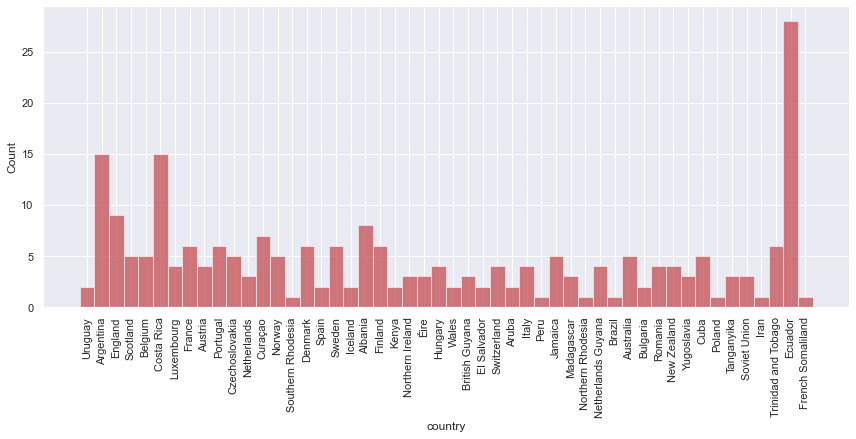

In [86]:
freq_country = results[results['date'] <= '1947']
freq_country = freq_country[freq_country['date'] > '1945']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(15,5)
hist.set_xticklabels(rotation=90)

#### **From 1947 to 1991**

Below we can see countries that hosted the most games between the years 1947 to 1980, where this period is known as the "Cold War".

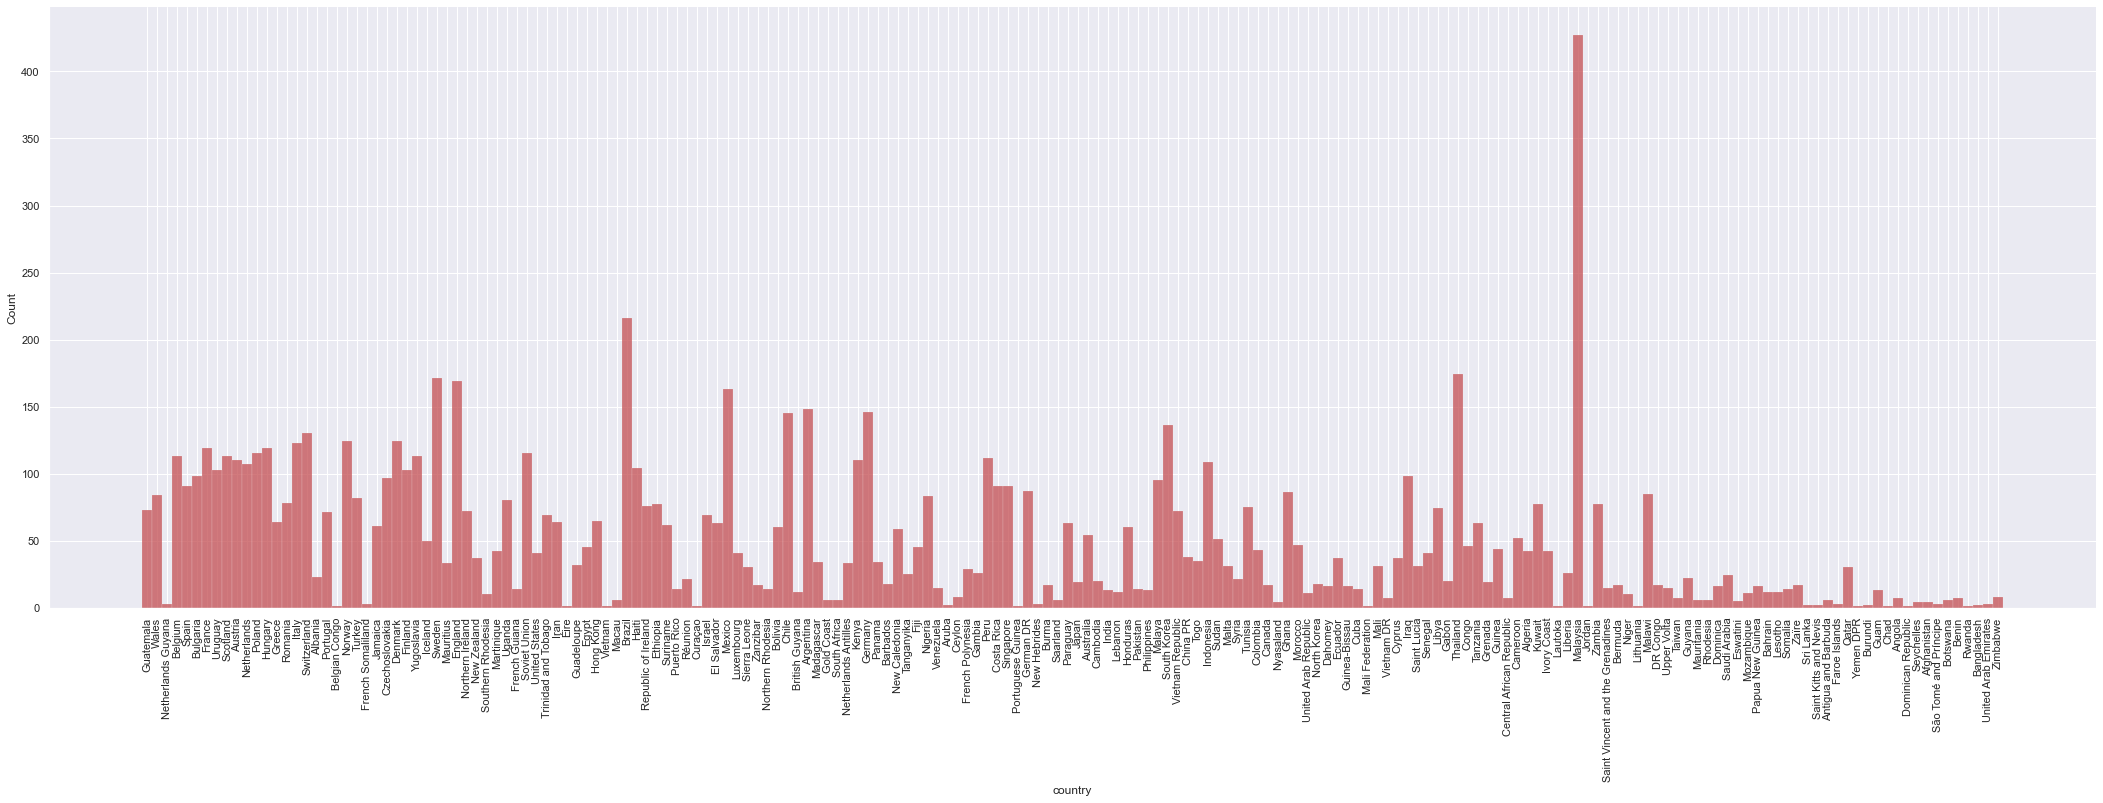

In [87]:
freq_country = results[results['date'] <= '1980']
freq_country = freq_country[freq_country['date'] > '1947']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

Below we can see countries that hosted the most games between the years 1980 to 1991, where this period is known as the "Cold War".

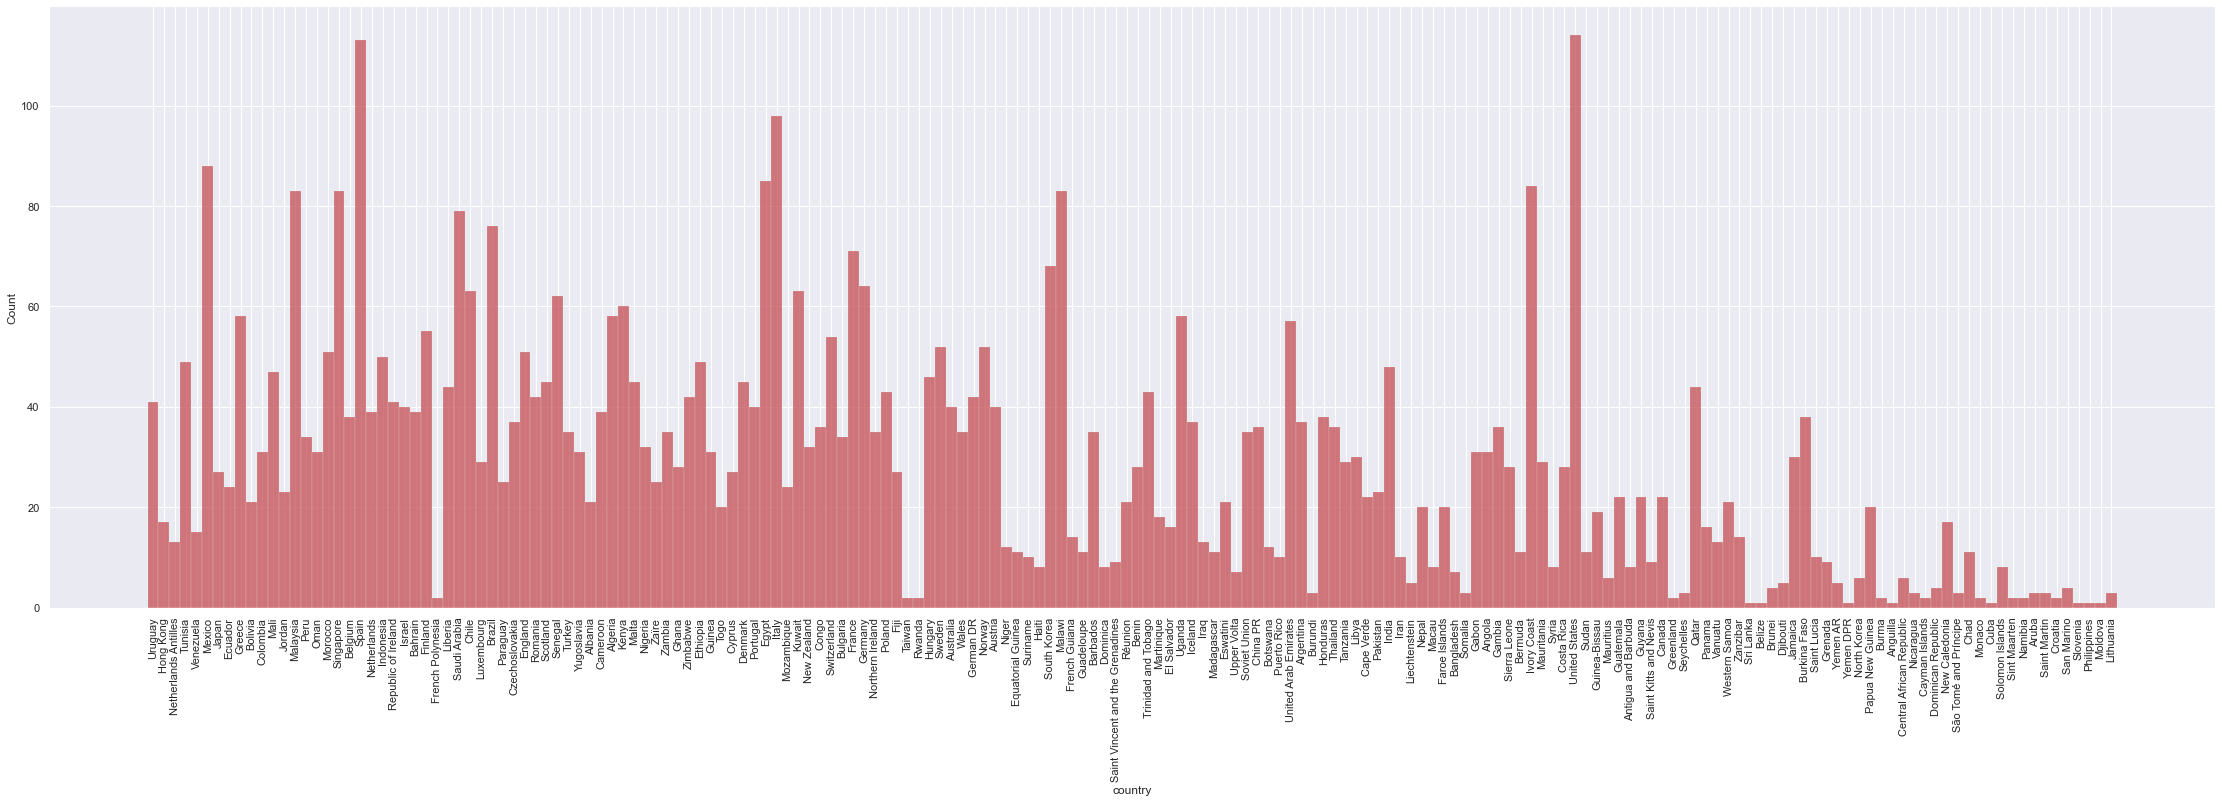

In [88]:
freq_country = results[results['date'] <= '1991']
freq_country = freq_country[freq_country['date'] > '1980']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 1992 to 1993**

Below we can see the countries that hosted the most games between the years 1992 to 1993; period in which the Maastricht Treaty was signed with the institution of the European Union.

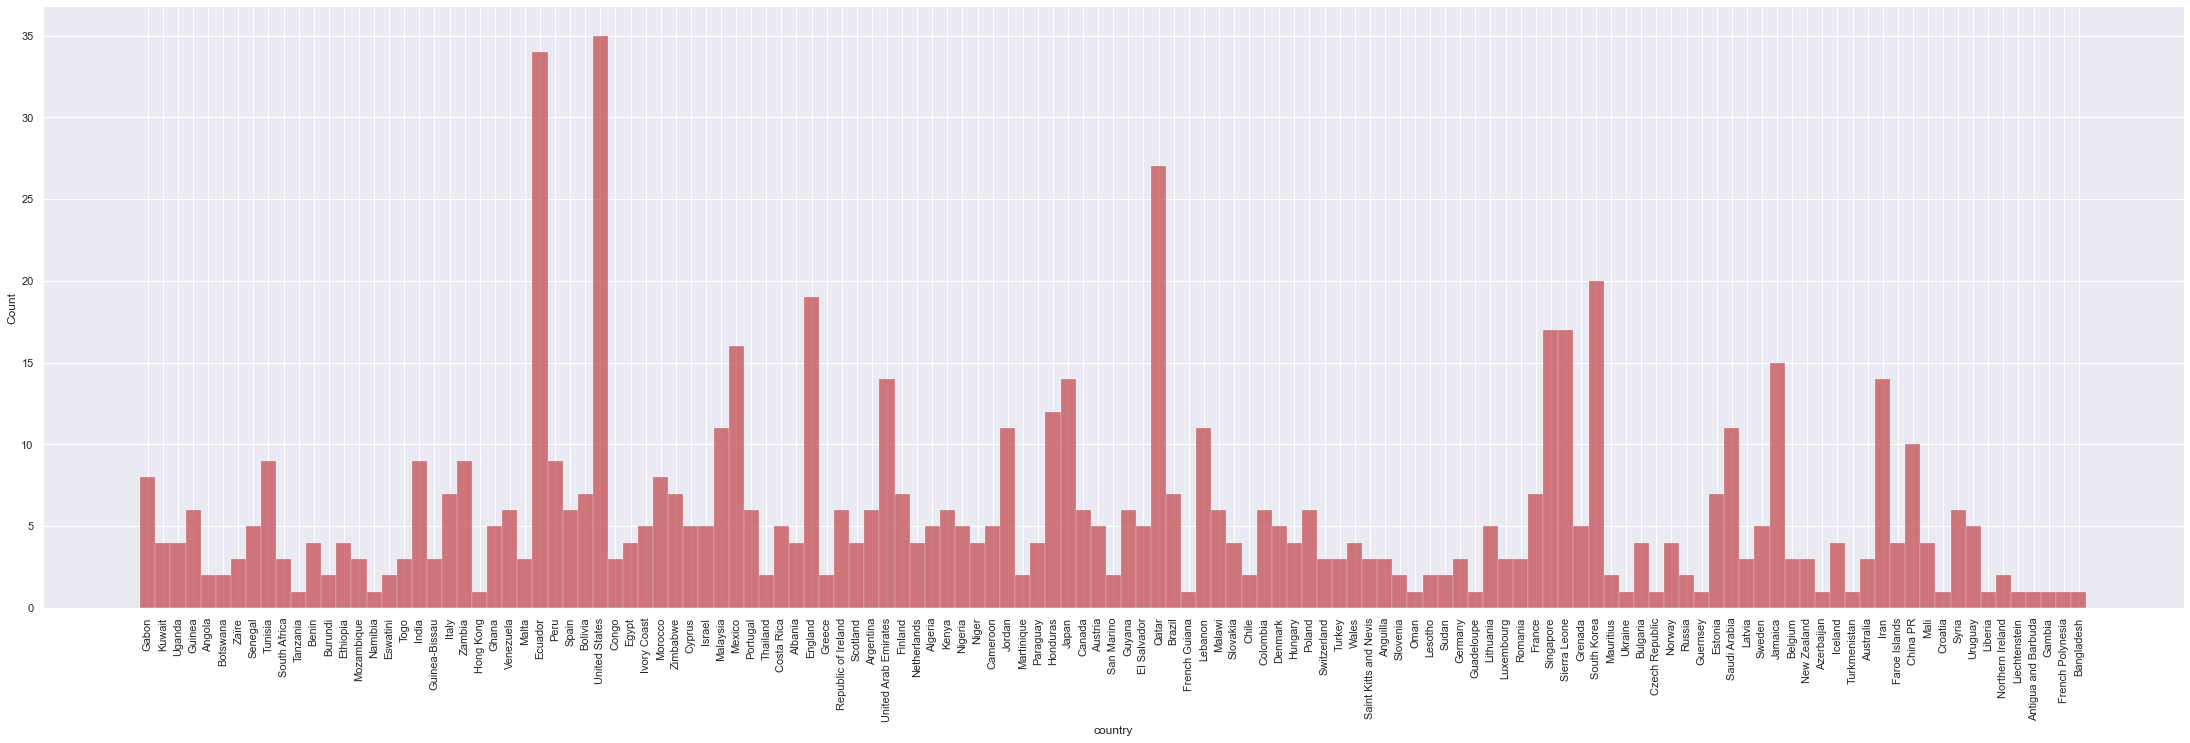

In [89]:
freq_country = results[results['date'] <= '1993']
freq_country = freq_country[freq_country['date'] > '1992']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 1994 to 1999**

Below we can see countries that hosted the most games between the years 1994 to 1999; a period that includes major world events of impact, such as the Genocide in Rwanda, the Attack on Oklahoma City, the Asian financial crisis and the Kosovo War.

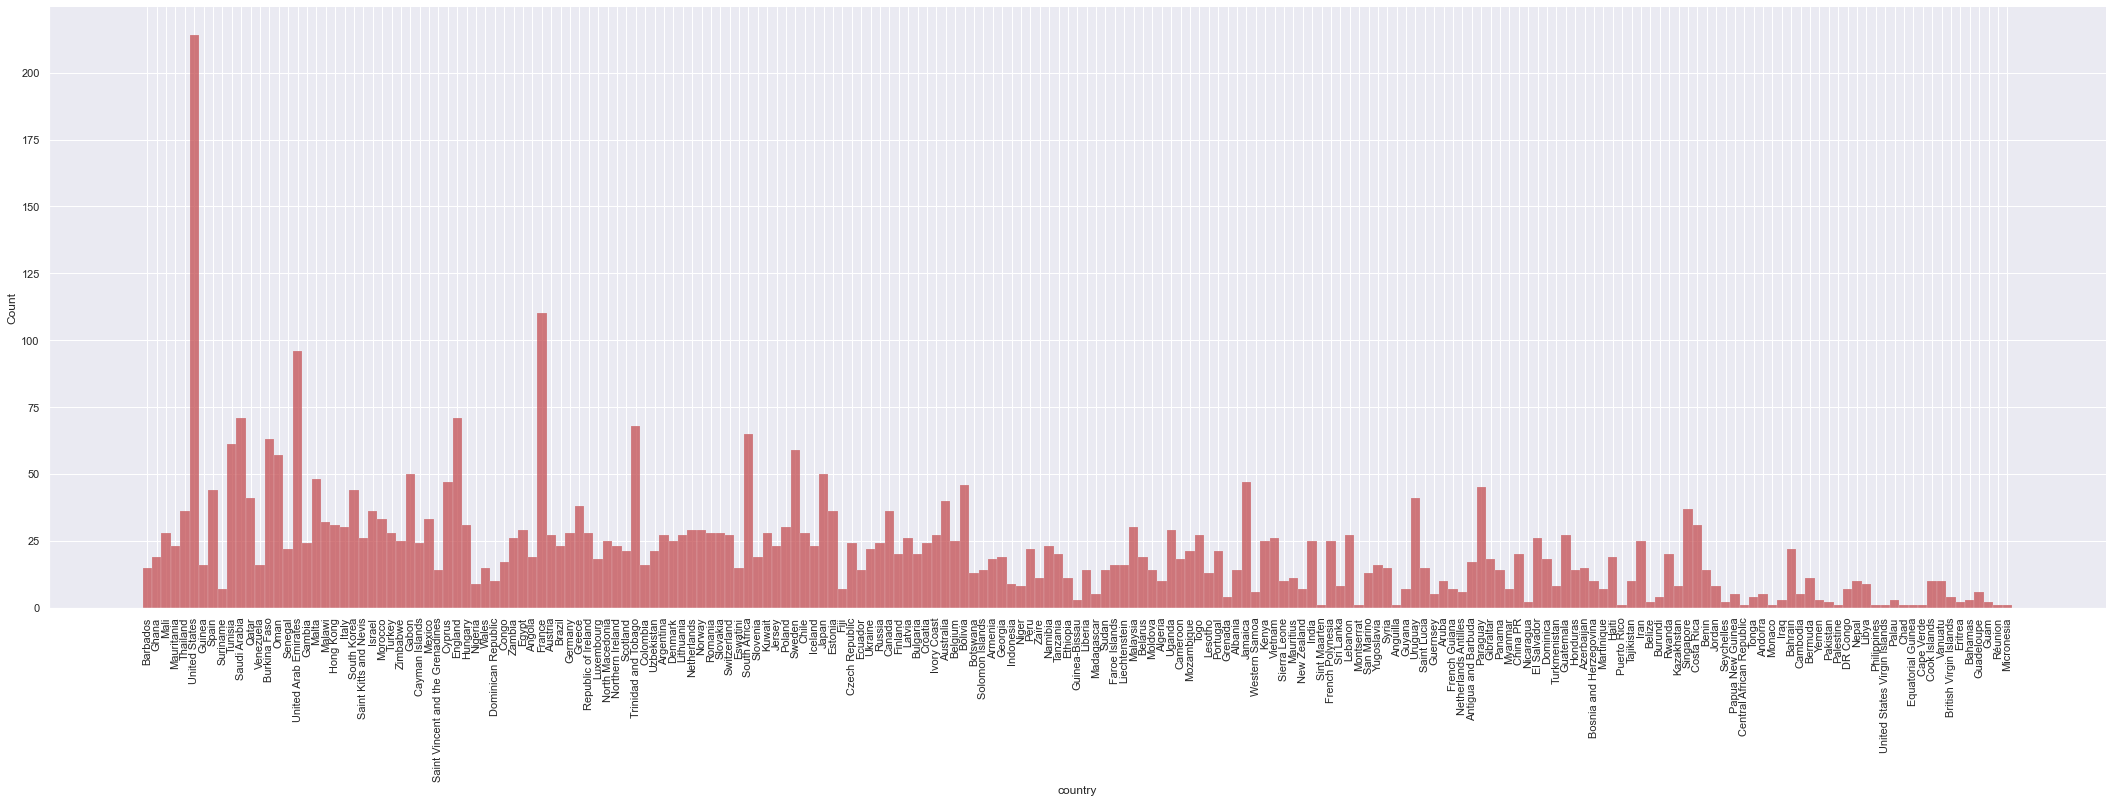

In [90]:
freq_country = results[results['date'] <= '1999']
freq_country = freq_country[freq_country['date'] >= '1994']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2000 to 2003**

Below we can see countries that hosted the most games between the years 2000 to 2003; a period that includes major world events of impact, such as the turn of the millennium, the September 11 attacks, the wars in Afghanistan and Iraq, among others.

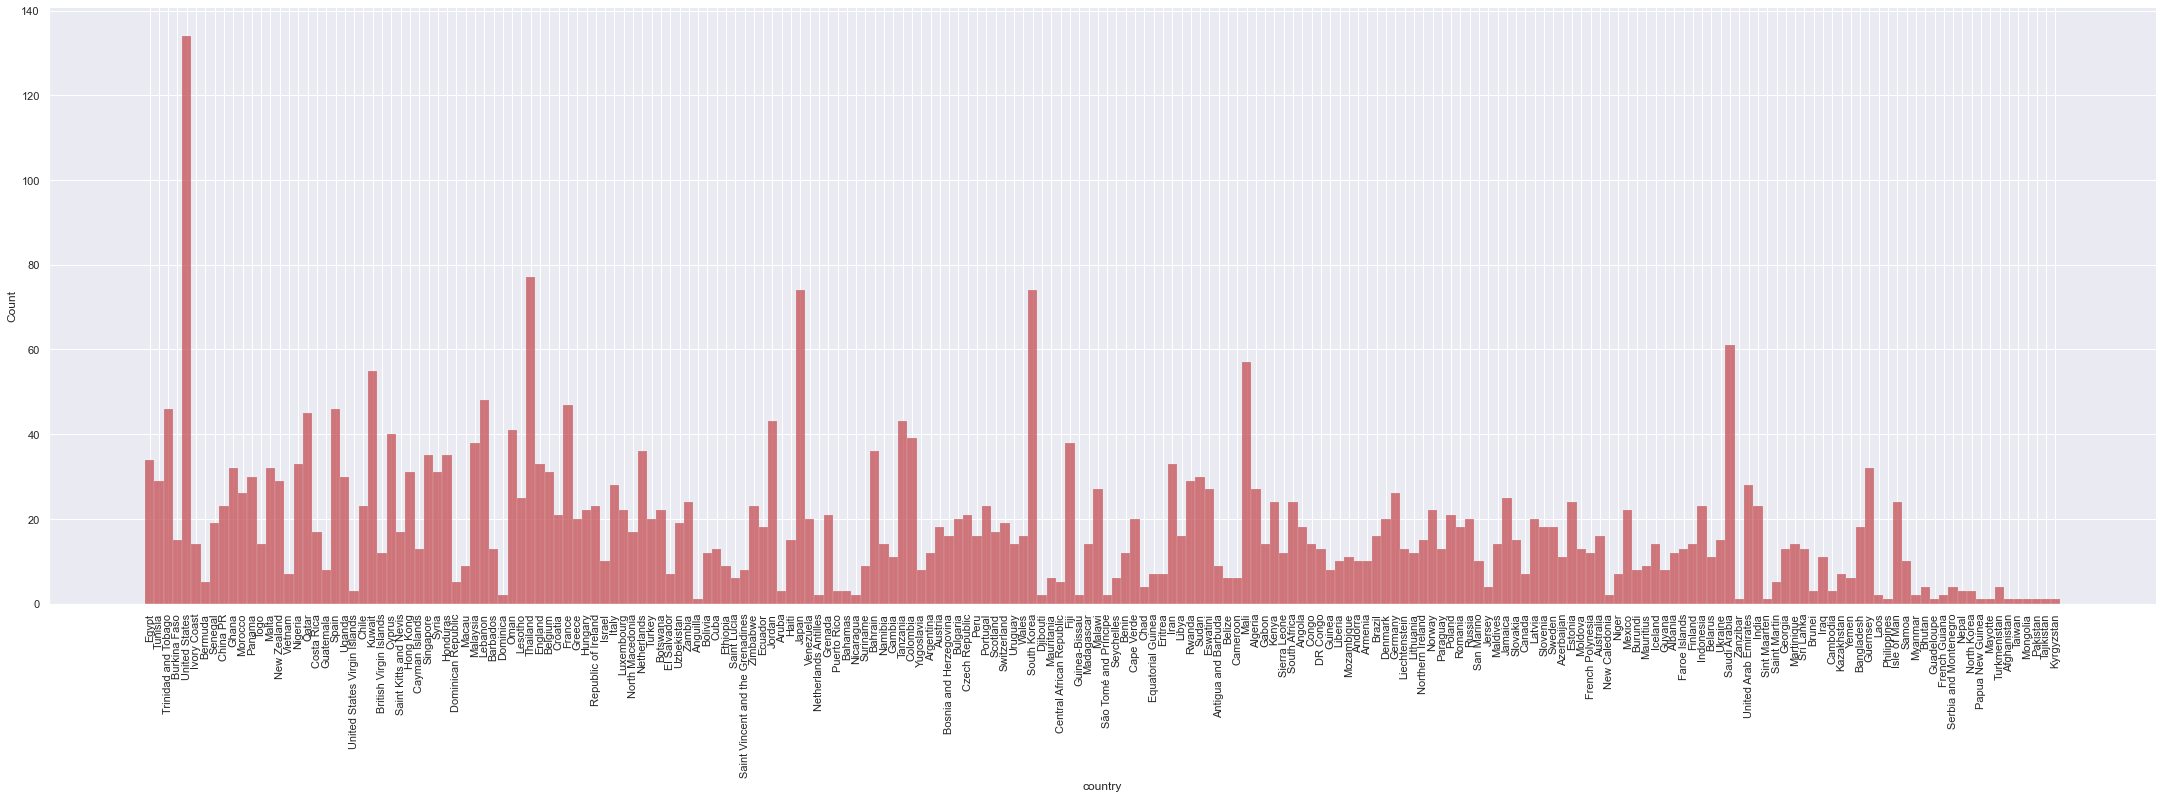

In [91]:
freq_country = results[results['date'] <= '2003']
freq_country = freq_country[freq_country['date'] >= '2000']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2004 to 2005**

Below we can see the countries that hosted the most games between the years 2004 to 2005; a period that includes major world events of impact, such as the attacks in Madrid and London.

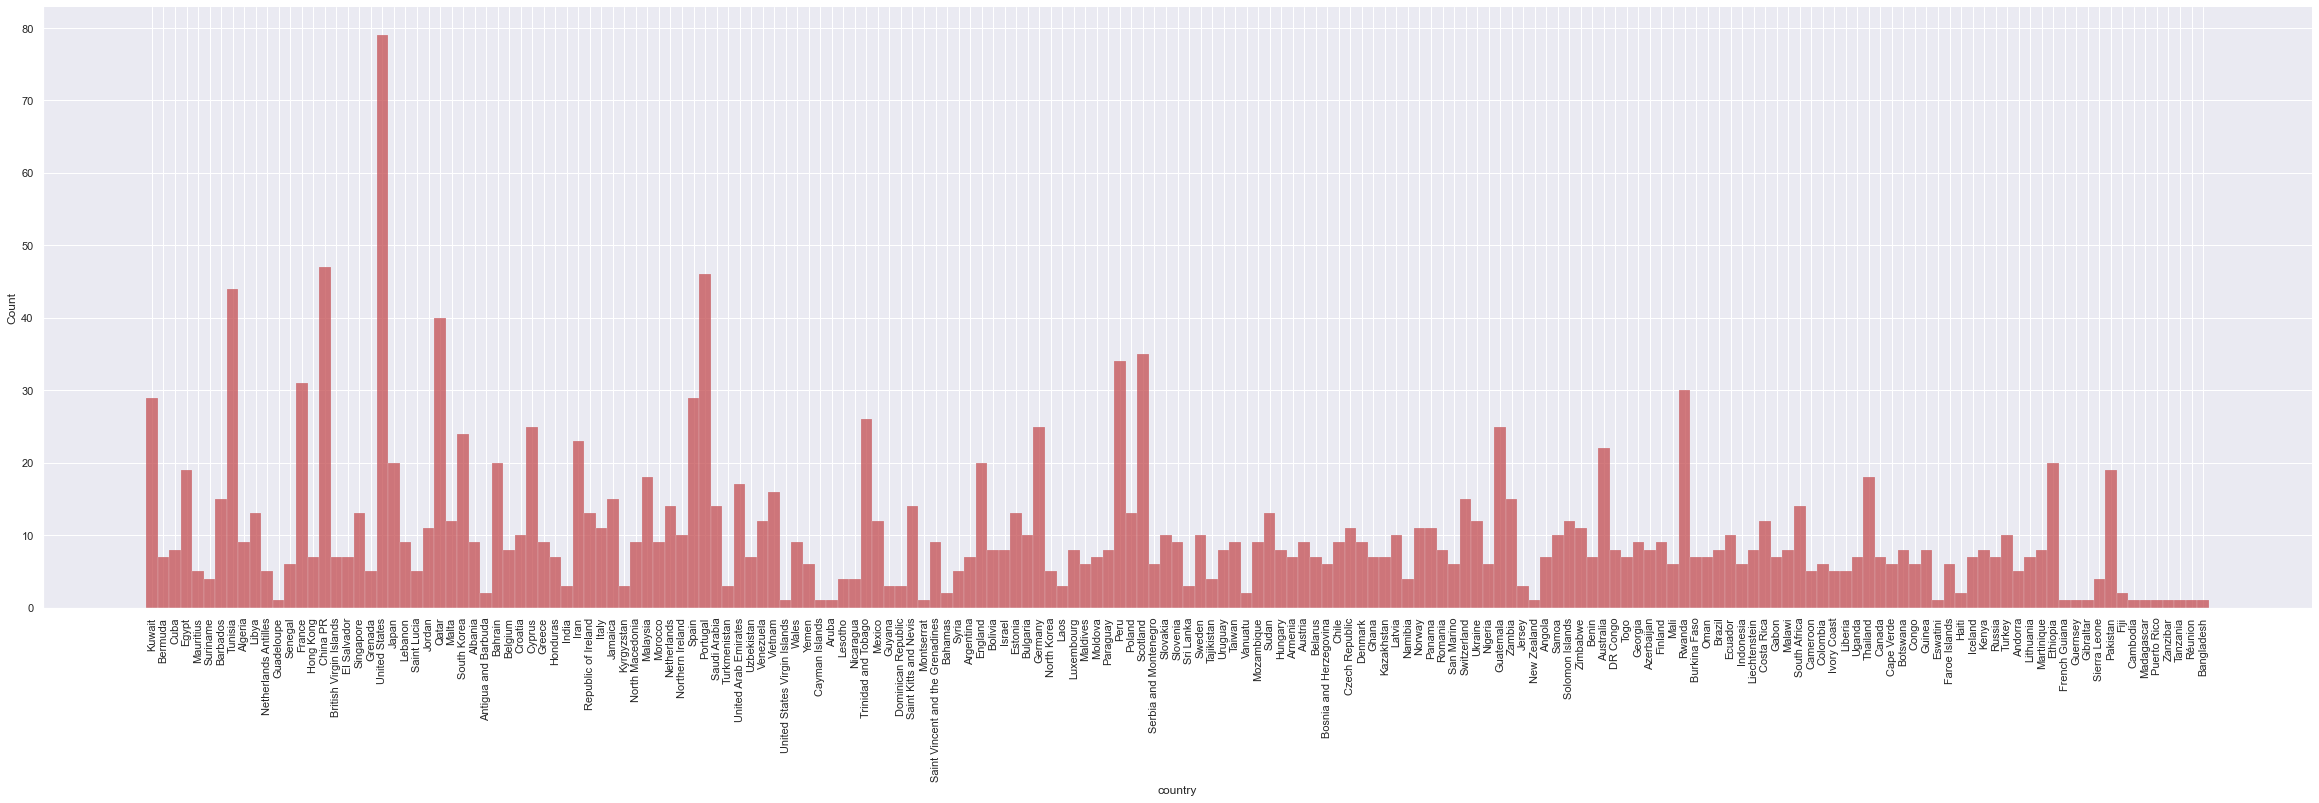

In [92]:
freq_country = results[results['date'] <= '2005']
freq_country = freq_country[freq_country['date'] >= '2004']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2006 to 2007**

Below we can see the countries that hosted the most games between the years 2006 to 2007; a period that includes major world events of impact, such as the publication of Muhammad's cartoons in a Danish newspaper and the release by the UN of a report indicating that human activities are responsible for climate change.

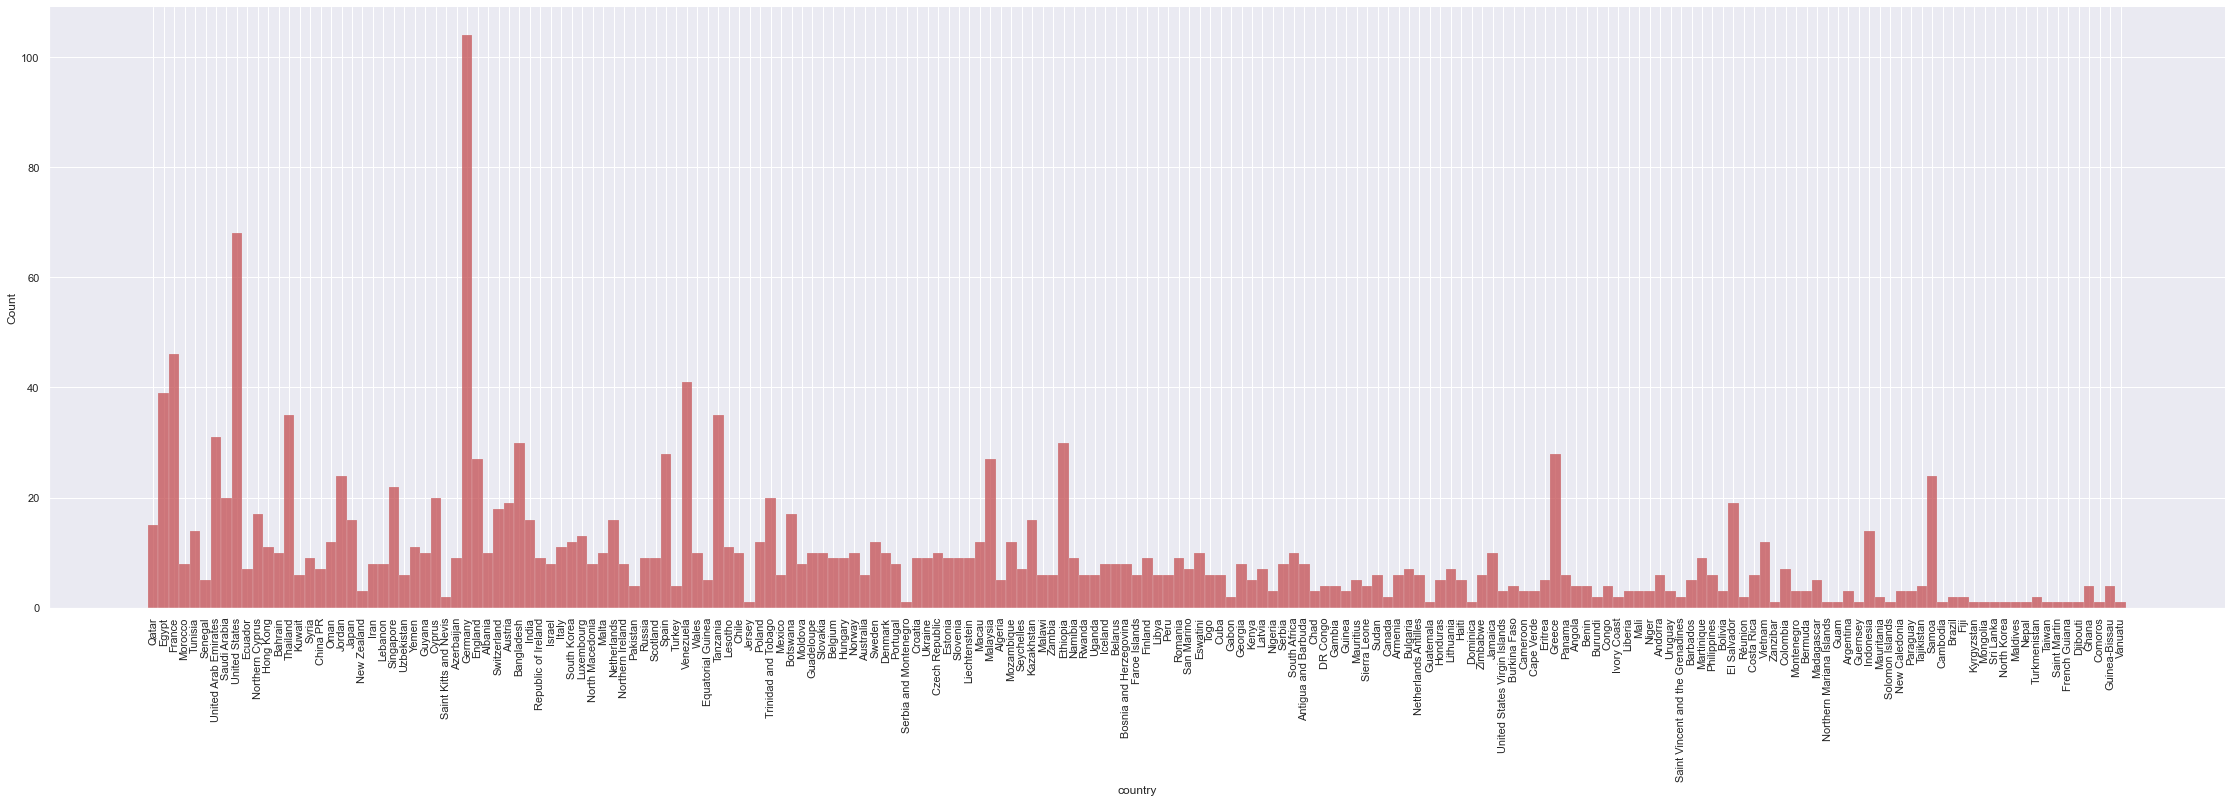

In [93]:
freq_country = results[results['date'] <= '2007']
freq_country = freq_country[freq_country['date'] >= '2006']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2007 to 2008**

Below we can see the countries that hosted the most games between the years 2007 to 2008; a period that includes events of great global impact, such as the global economic crisis.

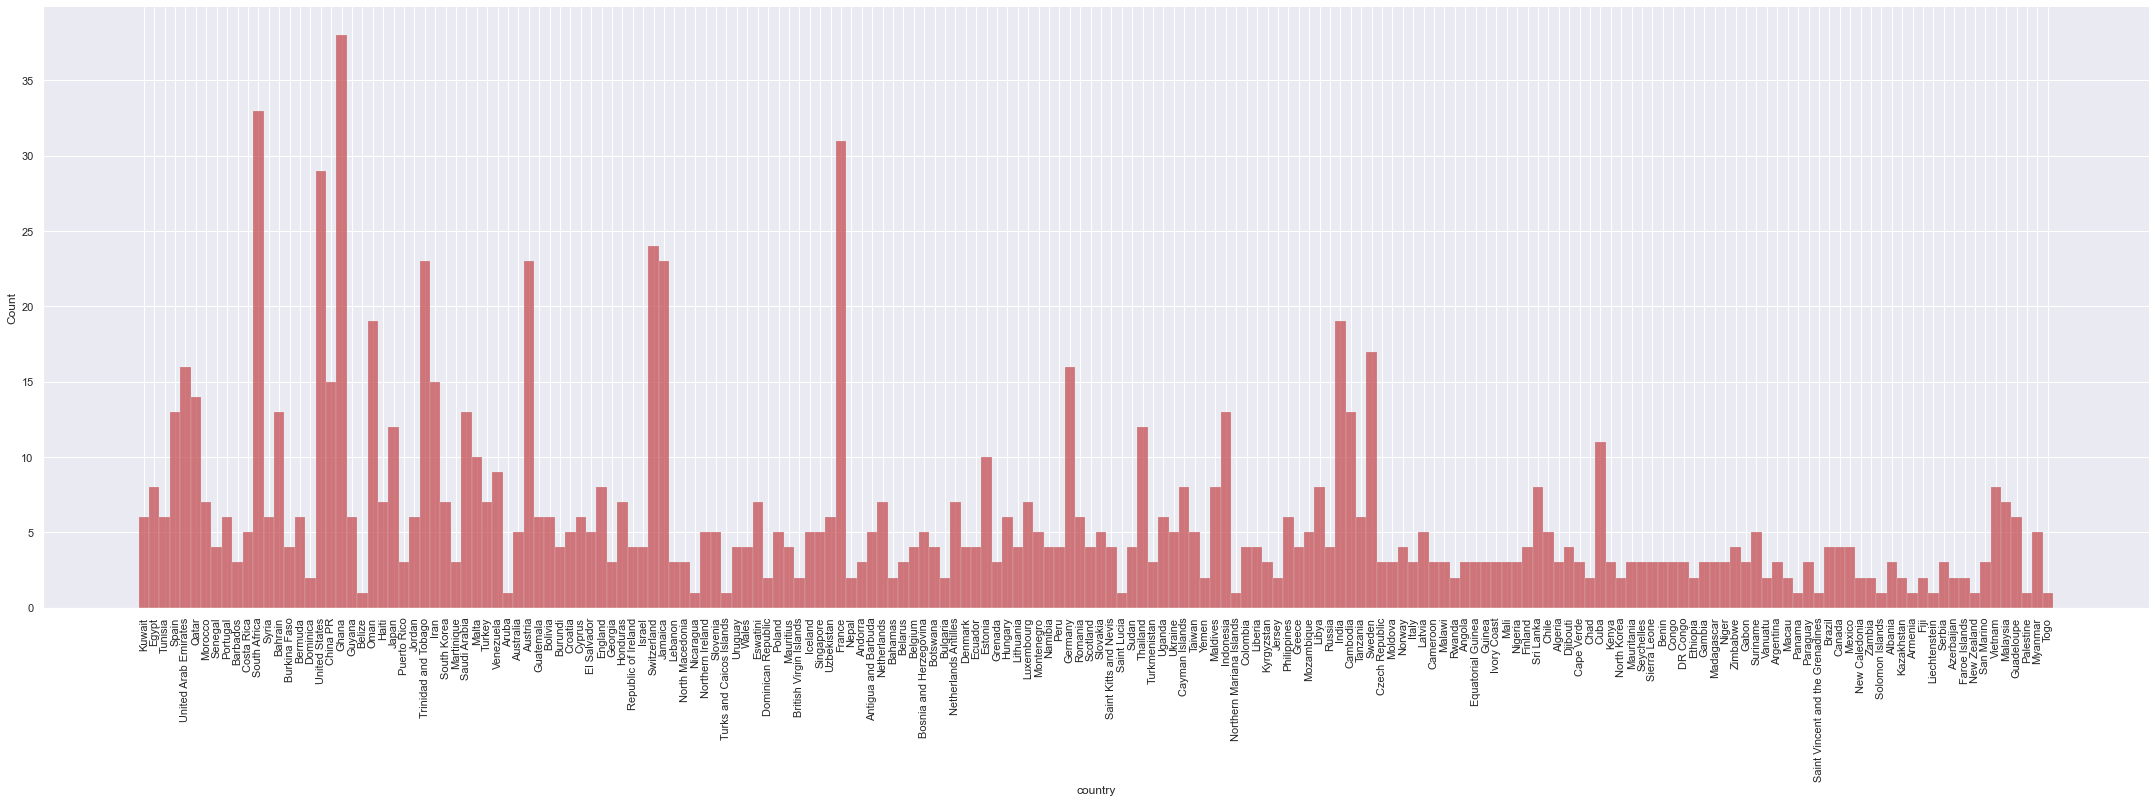

In [94]:
freq_country = results[results['date'] <= '2008']
freq_country = freq_country[freq_country['date'] > '2007']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2009 to 2010**

Below we can see the countries that hosted the most games between the years 2009 to 2010; a period that includes events of great global impact, such as the United Nations Conference on Climate Change in 2009 and the 2010 earthquake in Haiti.

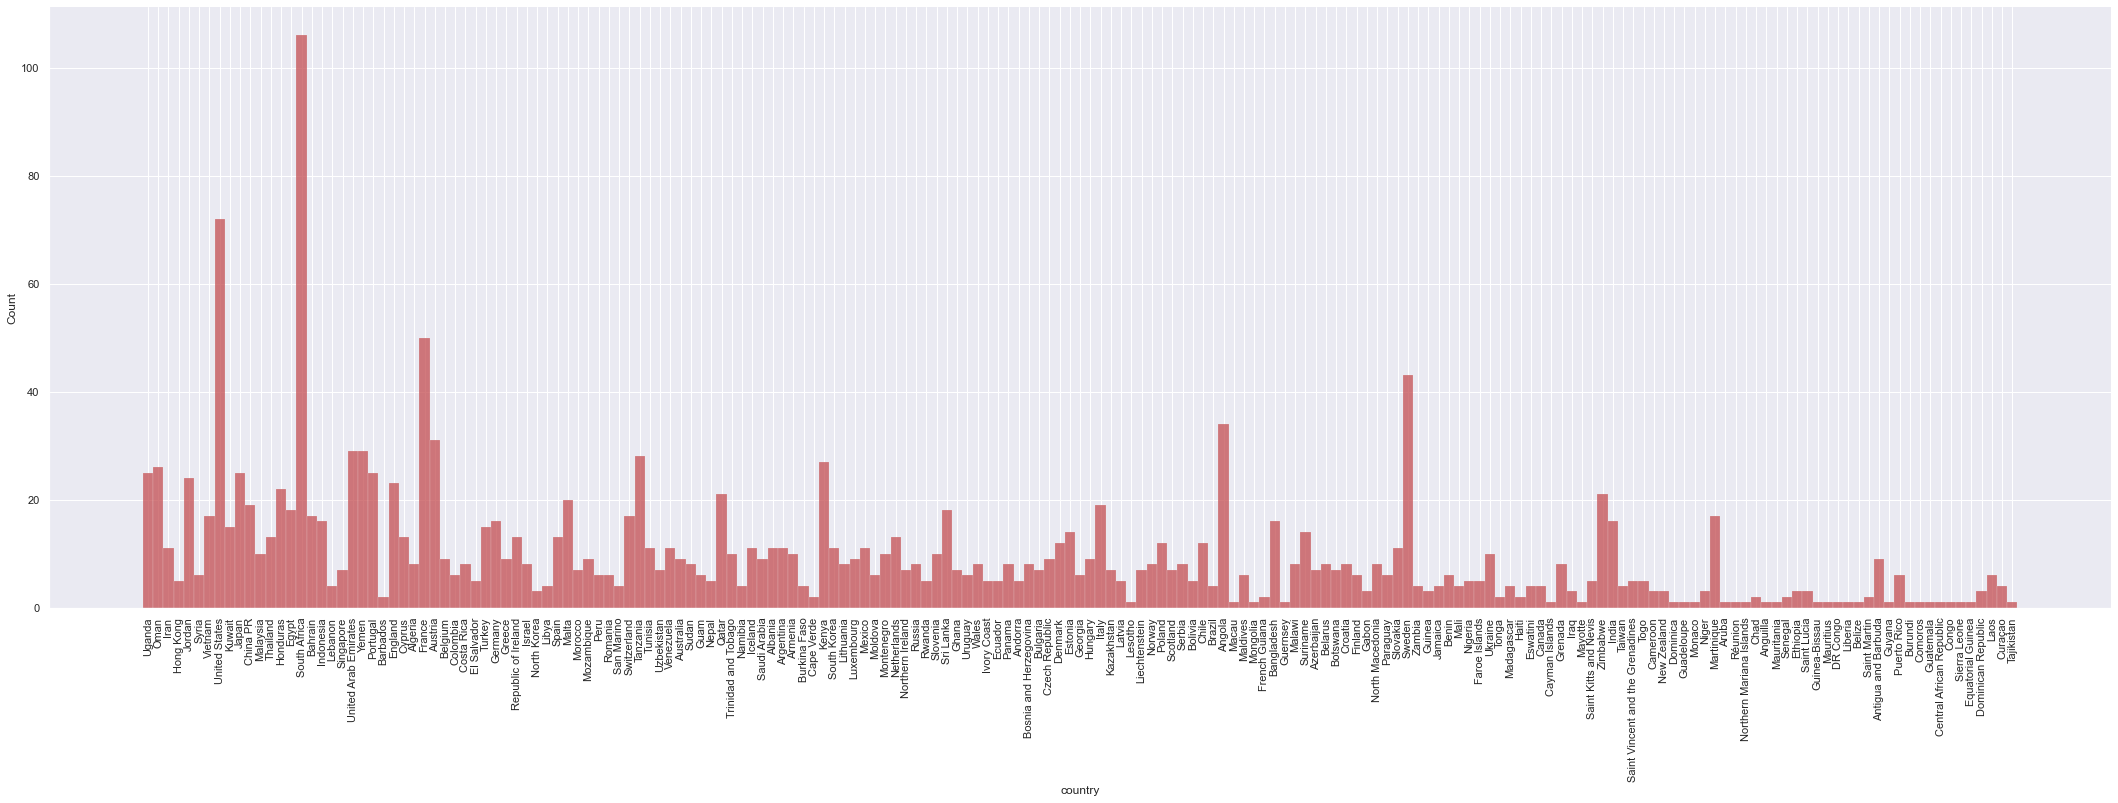

In [95]:
freq_country = results[results['date'] <= '2010']
freq_country = freq_country[freq_country['date'] >= '2009']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2011 to 2013**

Below we can see the countries that hosted the most games between the years 2011 to 2013; a period that includes events of great global impact, such as the Arab Spring, the death of Osama Bin Laden and the attack on the Boston Marathon.

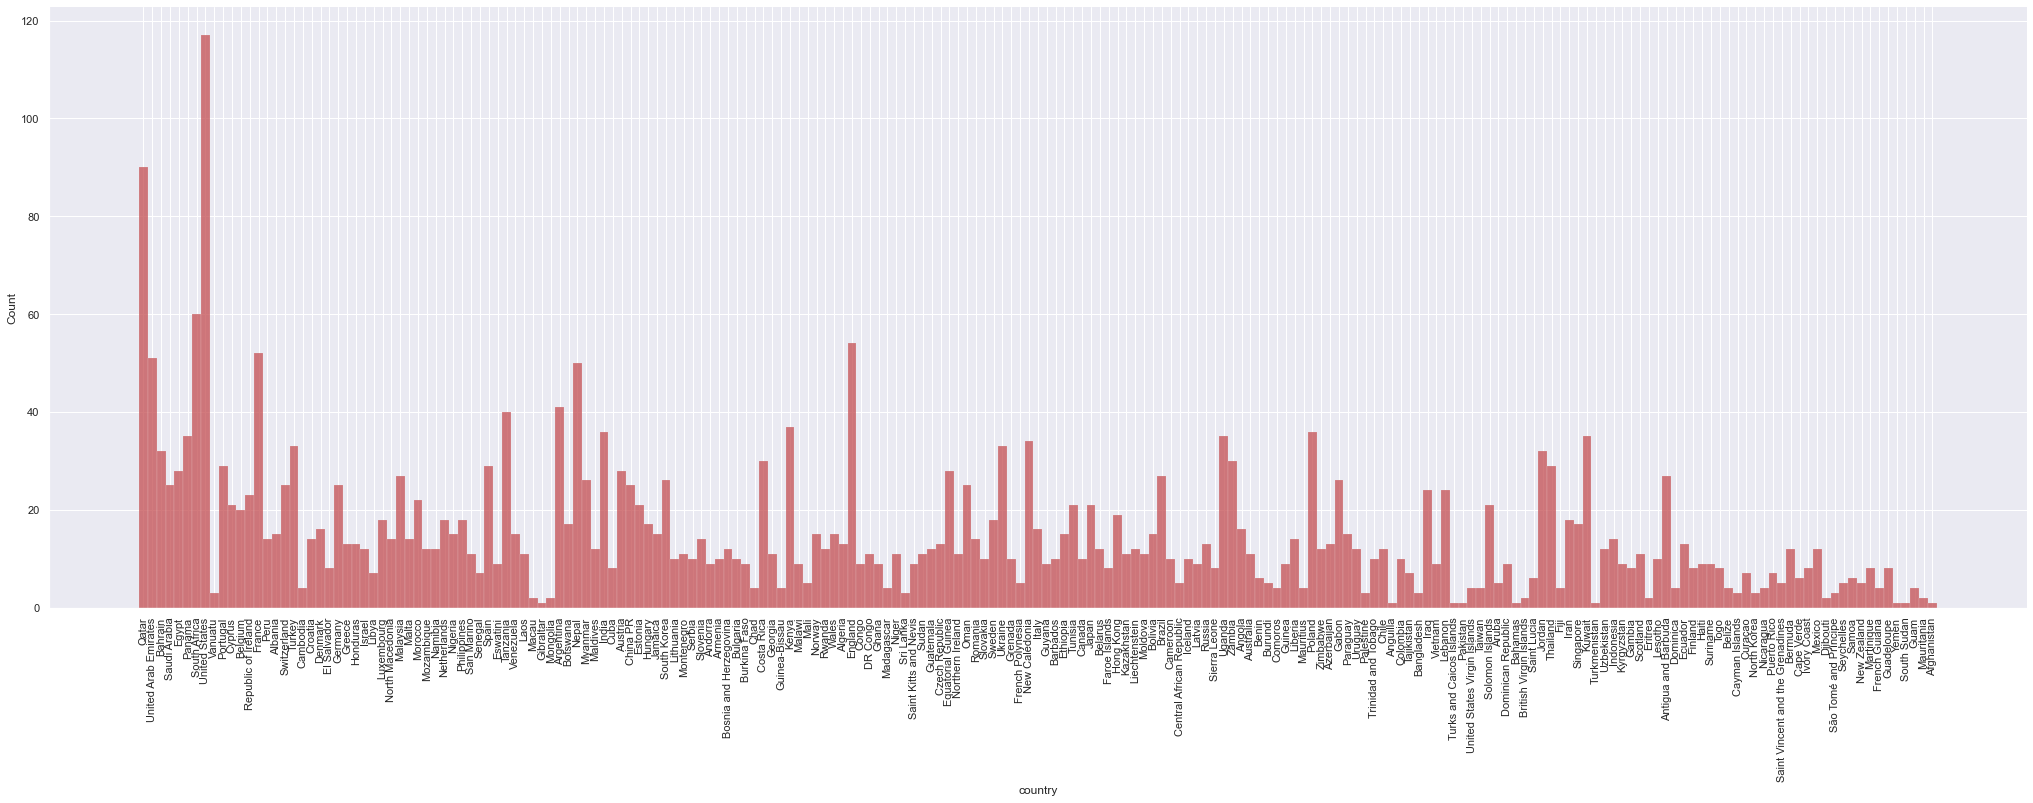

In [96]:
freq_country = results[results['date'] <= '2013']
freq_country = freq_country[freq_country['date'] >= '2011']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2014 to 2016**

Below we can see the countries that hosted the most games between the years 2014 to 2016; a period that includes events of great global impact, such as the Ebola virus epidemic, the attacks in Paris and the Brexit referendum in the United Kingdom.

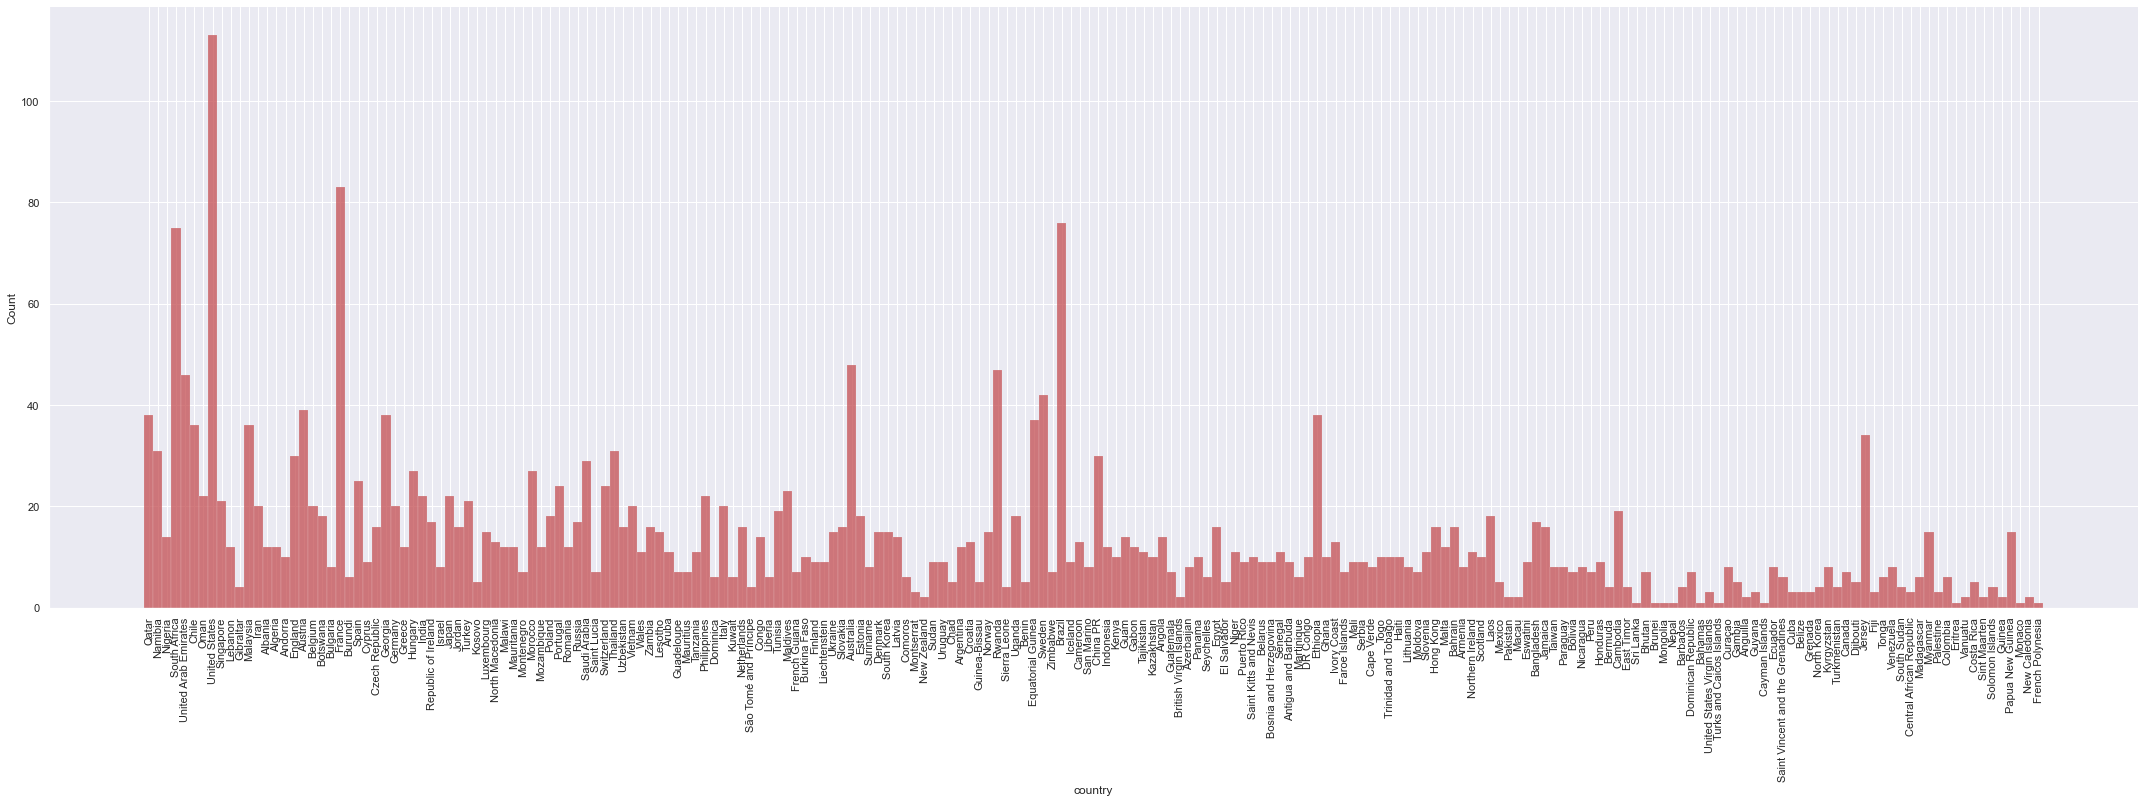

In [97]:
freq_country = results[results['date'] <= '2016']
freq_country = freq_country[freq_country['date'] >= '2014']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2018 to 2019**

Below we can see countries that hosted the most games between the years 2018 to 2019; a period that includes events of great global impact, such as the protests in Hong Kong and the historic Summit between the United States and North Korea.

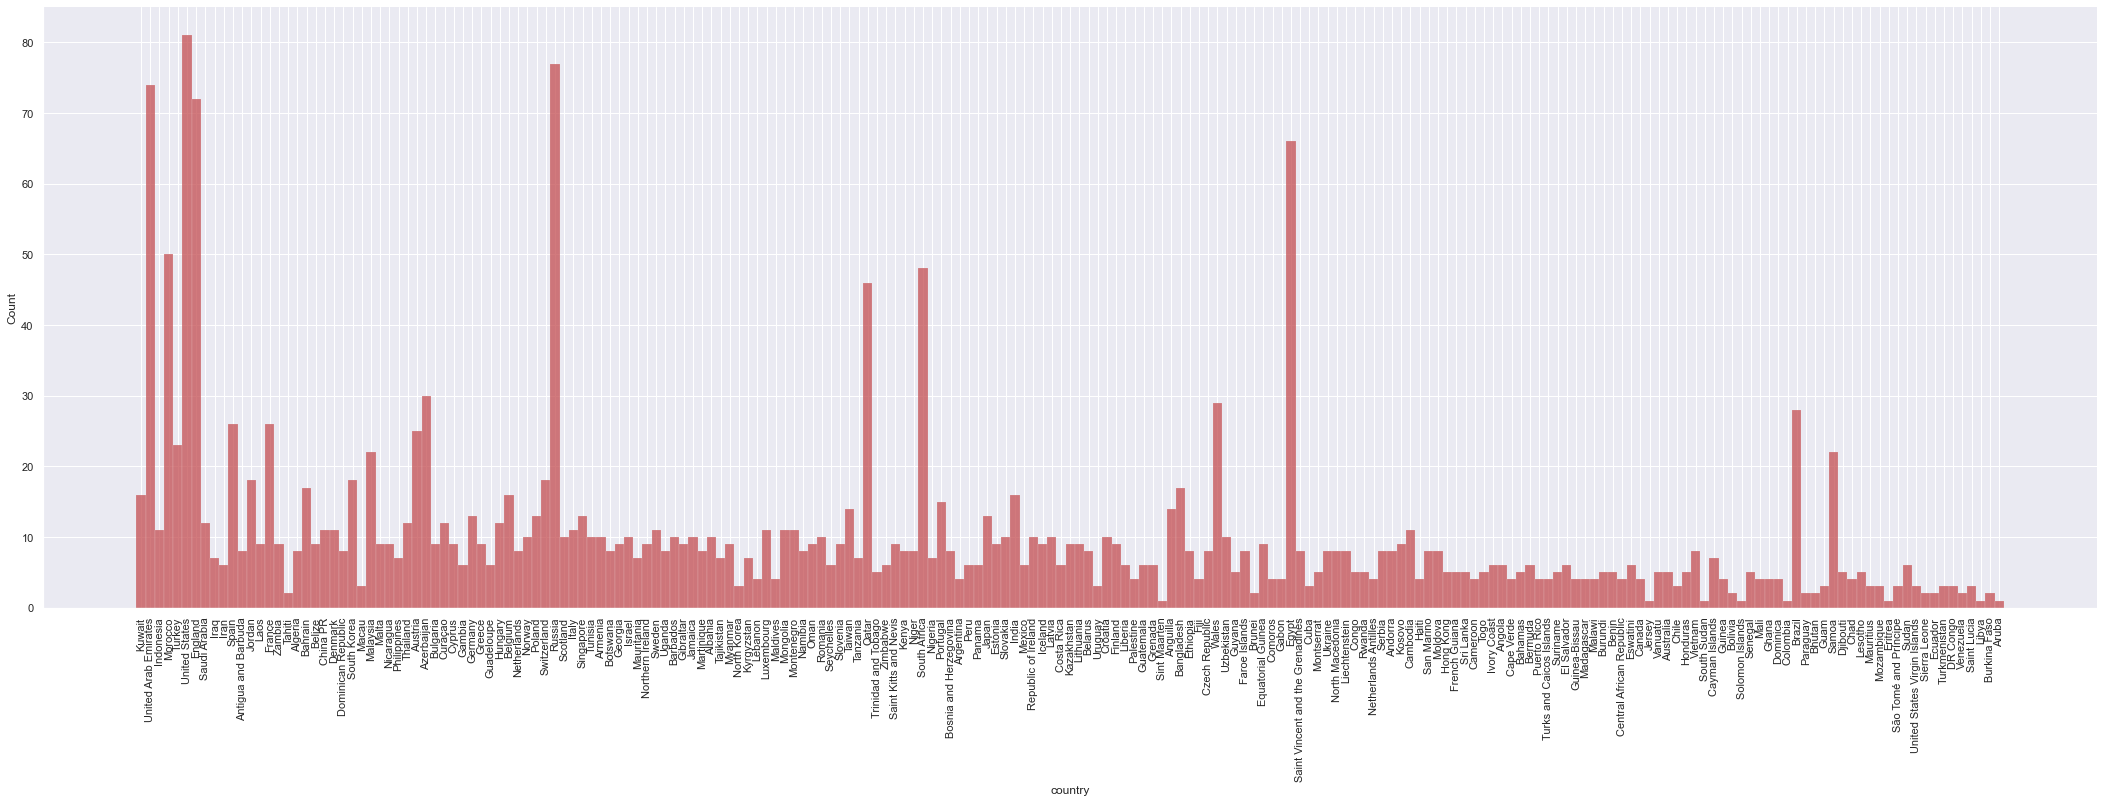

In [98]:
freq_country = results[results['date'] <= '2019']
freq_country = freq_country[freq_country['date'] >= '2018']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)

#### **From 2020 to 2023**

Below we can see the countries that hosted the most games between the years 2020 to 2023; a period that includes events of great global impact, such as the COVID-19 pandemic, the Taliban seizure of power in Afghanistan and the Russia-Ukraine conflict.

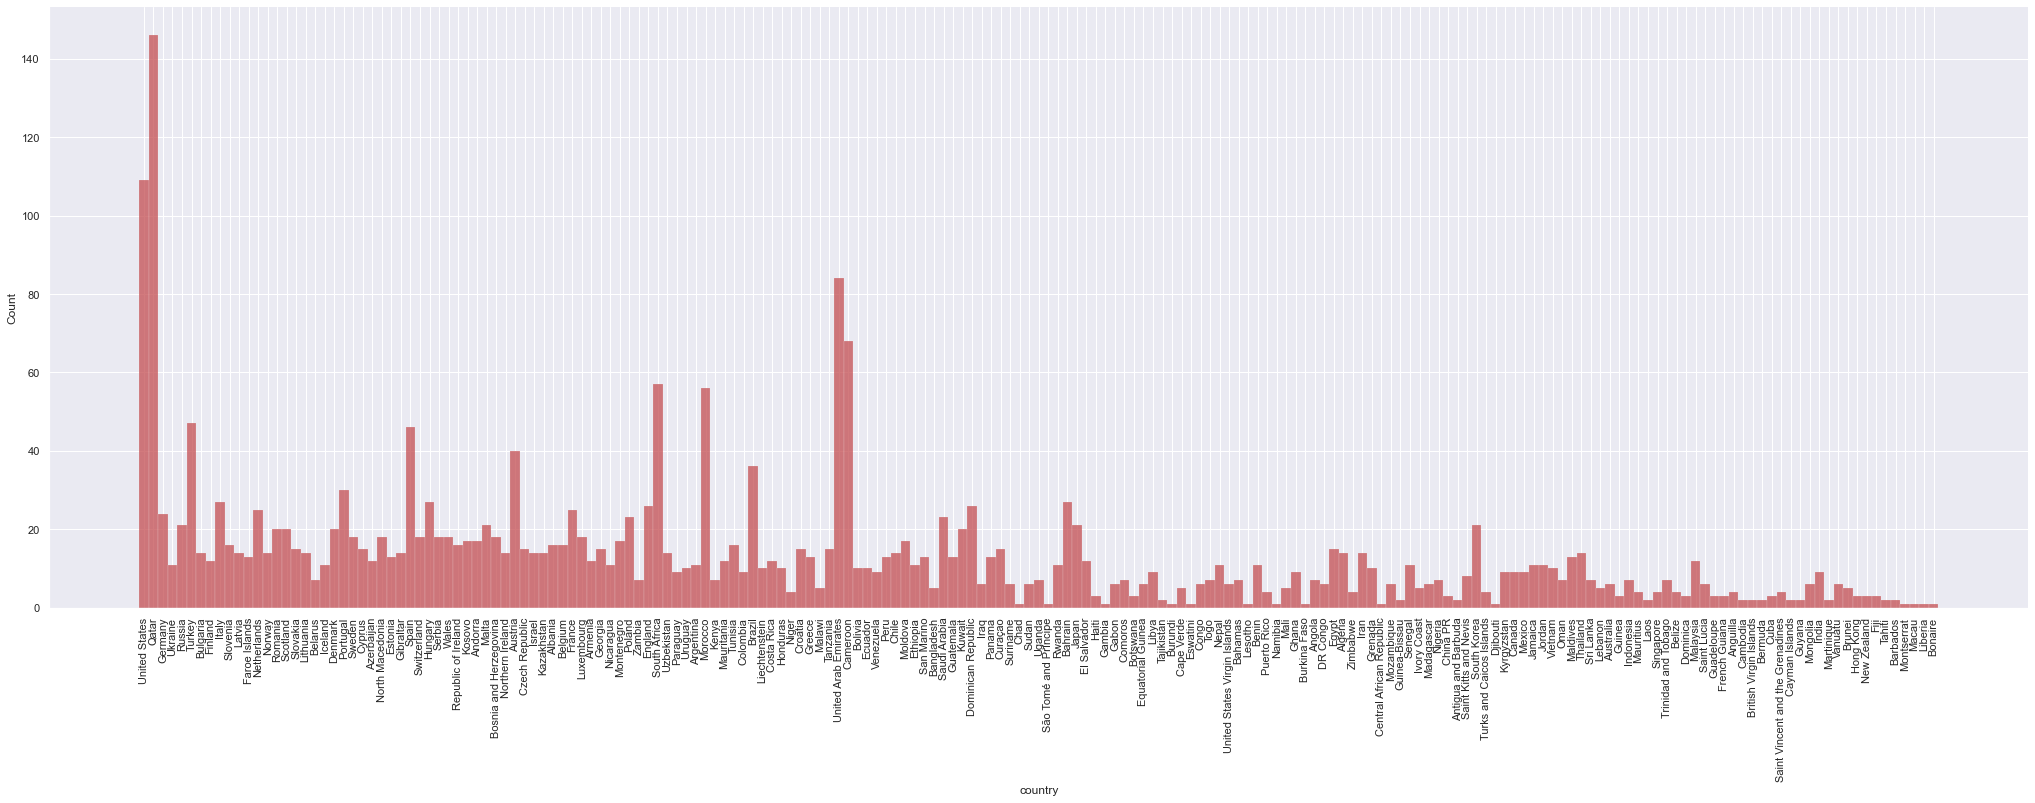

In [99]:
freq_country = results[results['date'] <= '2023']
freq_country = freq_country[freq_country['date'] >= '2020']

hist = sns.displot(data=freq_country, x='country', color='r')
hist.figure.set_size_inches(40,10)
hist.set_xticklabels(rotation=90)


# **Gráfico de Linha**

## **Goalscorers**

### **1. Penalty Goal Rate per Year**


Penalty goals ratio is calculated by dividing penalty goals by total goals

In [100]:
penalty_rate = pd.crosstab(goalscorers.year, goalscorers.penalty)
penalty_rate['rate'] = penalty_rate[1] / penalty_rate[0]
penalty_rate

penalty  False  True      rate
year                          
1916        16     2  0.125000
1917        17     4  0.235294
1919        27     0  0.000000
1920        15     1  0.066667
1921        14     0  0.000000
...        ...   ...       ...
2018       147    22  0.149660
2019      1428   131  0.091737
2020        82    15  0.182927
2021      1848   203  0.109848
2022       452    50  0.110619

[97 rows x 3 columns]

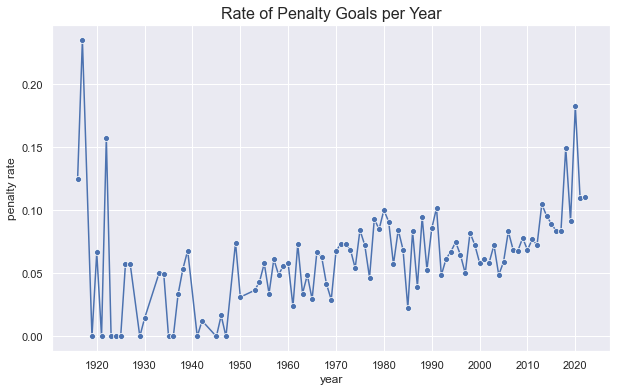

In [101]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=penalty_rate, x='year', y='rate', marker='o')
plt.locator_params(axis='x', nbins=20)
ax.set_title("Rate of Penalty Goals per Year", size=16)
ax.set_ylabel("penalty rate")

# Show
plt.show()

## **Results** 

### **1. Goal Rate per Year**


Goal rate is calculated by dividing the number of goals by the number of games in one year

Matches before 1930 were removed becouse of lower number games

In [102]:
# All goals by year
total_goals = results.groupby(by='year')['total_goals'].sum()
# All matches by year
total_matches = results.year.value_counts()
# Goal rate by year
goal_rate = total_goals / total_matches
goal_rate = goal_rate.to_frame().reset_index()
goal_rate.rename(columns={'index': 'year', 0:'goal_rate'}, inplace=True)
# Remove matches before 1930
mask = goal_rate.year >= 1930
goal_rate = goal_rate[mask]
goal_rate

year  goal_rate
58   1930   4.323232
59   1931   4.237113
60   1932   3.923077
61   1933   3.967742
62   1934   4.814815
..    ...        ...
147  2019   2.869078
148  2020   2.471572
149  2021   2.746556
150  2022   2.479781
151  2023   2.536082

[94 rows x 2 columns]

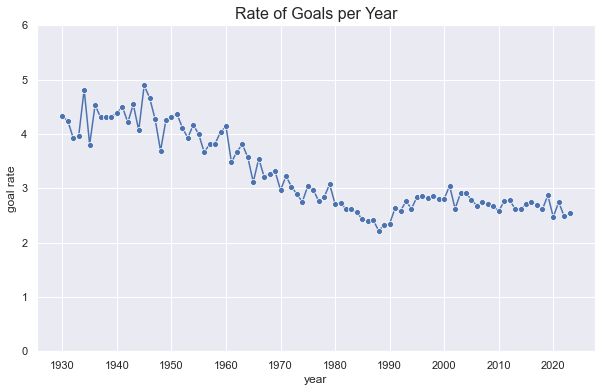

In [103]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=goal_rate, x='year', y='goal_rate', marker='o')
plt.locator_params(axis='x', nbins=20)
ax.set_title("Rate of Goals per Year", size=16)
ax.set_ylabel("goal rate")
ax.set_yticks(list(range(0, 7)))

# Show
plt.show()

# **Gráfico de Barra**

## **Goalscorers**

### **1. Best goalscorers**


Calculated by absolute frequency

In [104]:
# Calculate absolute frequency of wins
goalscorers_count = goalscorers.scorer.value_counts().to_frame().reset_index()
goalscorers_count.rename(columns={'index': 'scorer', 'scorer':'count'}, inplace=True)
goalscorers_count.head()

scorer  count
0   Cristiano Ronaldo     91
1  Robert Lewandowski     56
2        Lionel Messi     54
3            Ali Daei     49
4      Miroslav Klose     48

**Observation: Data not updated, Lionel Messi and Ali Daei has more than 100 goals**

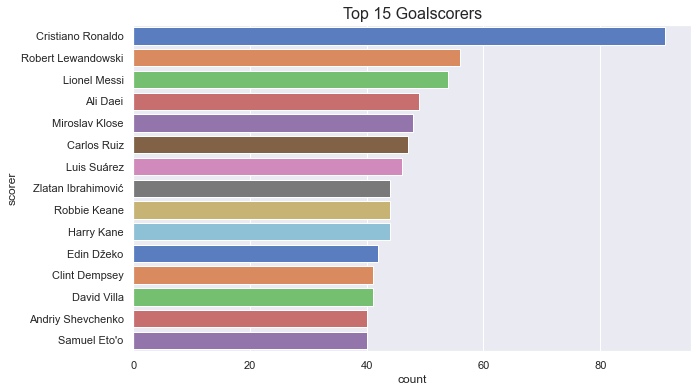

In [105]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=goalscorers_count.head(15), x='count', y='scorer', palette='muted')
ax.set_title("Top 15 Goalscorers", size=16)


# Show
plt.show()

## **Shootouts**

### **1. Teams who played the most penalty shootouts**


Calculated by absolute frequency

In [106]:
# Calculate the absolute frequency
shootouts_rate_domain = shootouts.home_team.value_counts().add(shootouts.away_team.value_counts(), fill_value=0)
# Filter low result
shootouts_rate_domain = shootouts_rate_domain.to_frame().reset_index()
shootouts_rate_domain.rename(columns={'index': 'country', 0:'total_penalties'}, inplace=True)
shootouts_rate_domain.sort_values(by='total_penalties', ascending=False, inplace=True)
shootouts_rate_domain.head()

country  total_penalties
200        Zambia             24.0
165   South Korea             23.0
164  South Africa             23.0
5       Argentina             22.0
51          Egypt             22.0

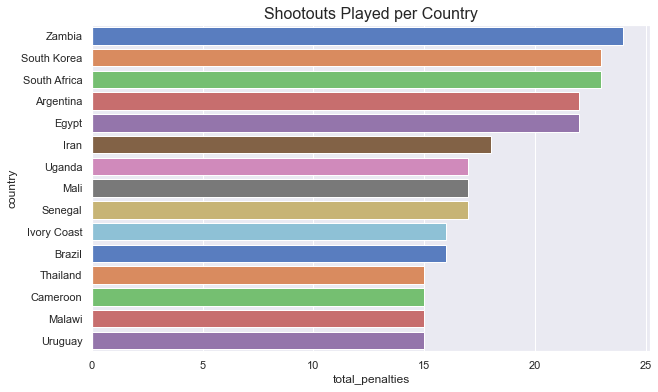

In [107]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=shootouts_rate_domain.head(15), x='total_penalties', y='country', palette='muted')
ax.set_title("Shootouts Played per Country", size=16)


# Show
plt.show()

### **2. Teams who won the most penalty shootouts**


Calculated by absolute frequency

In [108]:
# Calculate absolute frequency of wins
shootouts_count = shootouts.winner.value_counts().to_frame().reset_index()
shootouts_count.rename(columns={'index': 'country'}, inplace=True)
shootouts_count.head()

country  winner
0     Argentina      14
1   South Korea      13
2         Egypt      13
3        Zambia      13
4  South Africa      11

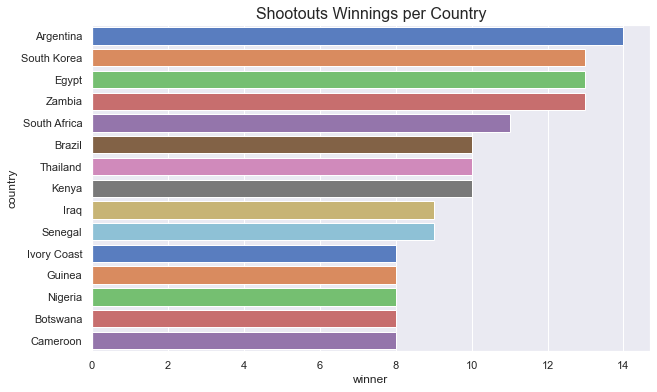

In [109]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=shootouts_count.head(15), x='winner', y='country', palette='muted')
ax.set_title("Shootouts Winnings per Country", size=16)


# Show
plt.show()

### **3. Teams with best peformance in penalty shootouts**


Division of win frequency by total frequency

In [122]:
shootouts_frequency = shootouts_rate_domain.merge(shootouts_count, left_on='country', right_on='country')
shootouts_frequency['ratio'] = shootouts_frequency.winner / shootouts_frequency.total_penalties

# filter countries that played more than 6 shootouts
mask = shootouts_frequency.total_penalties > 6
shootouts_frequency = shootouts_frequency[mask]

shootouts_frequency.head()

country  total_penalties  winner     ratio
0        Zambia             24.0      13  0.541667
1   South Korea             23.0      13  0.565217
2  South Africa             23.0      11  0.478261
3     Argentina             22.0      14  0.636364
4         Egypt             22.0      13  0.590909

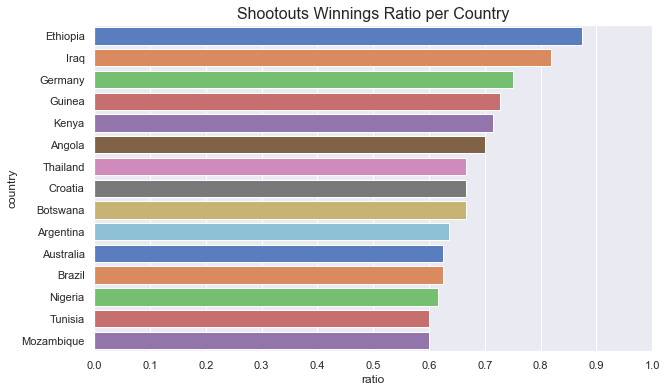

In [126]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=shootouts_frequency.sort_values(by='ratio', ascending=False).head(15), x='ratio', y='country', palette='muted')
ax.set_title("Shootouts Winnings Ratio per Country", size=16)
ax.set_xticks(np.array(range(0, 11))/10)


# Show
plt.show()

## **Bonus - Elo Ranking** 

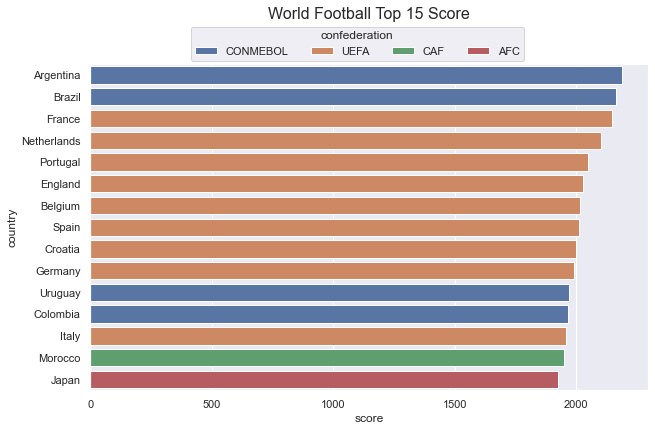

In [150]:
# Visualization
plt.figure(figsize=(10,6))
ax = sns.barplot(data=country_ranking.sort_values(by=2023, ascending=False).head(15), x=2023, y='country', hue='confederation', dodge=False)
ax.set_title("World Football Top 15 Score", y=1.12, size=16)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.17, 1.132), ncol=4)
ax.set_xlabel("score")

# Show
plt.show()

# **Bonus - Flourish Visualization (Elo Ranking)**

The flourish software was used to make a bar chart race of the elo ranking score over the years.

You can acess the visualization running the cell bellow or clicking on the following link: 
- **https://public.flourish.studio/visualisation/13571359/?utm_source=embed&utm_campaign=visualisation/13571359**.

In [151]:
%%HTML
<iframe src='https://flo.uri.sh/visualisation/13571359/embed' title='Interactive or visual content' class='flourish-embed-iframe' frameborder='0' scrolling='no' style='width:100%;height:600px;' sandbox='allow-same-origin allow-forms allow-scripts allow-downloads allow-popups allow-popups-to-escape-sandbox allow-top-navigation-by-user-activation'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/13571359/?utm_source=embed&utm_campaign=visualisation/13571359' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>